GB-traffic signs data: [sit](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
import keras.utils as np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from matplotlib import pyplot as plt


%matplotlib inline
NUM_CLASSES = 43
IMG_SIZE = 48

Using TensorFlow backend.


In [2]:
import os
from pathlib import PurePath

def preprocess_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)
    
    # crop image at center point according to min size
    min_side = min(img.shape[:-1])
    center = img.shape[0] // 2, img.shape[1] // 2
    img = img[center[0] - min_side // 2:center[0] + min_side // 2,
           center[1] - min_side // 2:center[1] + min_side // 2, :]
    
    # resize 
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    
    return img

# get class label
def get_class(img_path):
    return int(PurePath(img_path).parts[-2])

### Preprocess Data

In [15]:
try:
    with h5py.File('X.h5') as hf:
        X, Y = hf['imgs'][:], hf['labels'][:]
    print("Load images from X.h5")
    
except(IOError, OSError, KeyError):
    print('Error in reading X.h5 processing all images!')
    ROOT_DIR = '/media/yinyunjie/WD_HDD/dataSets/GT-traffic-signs/data/Final_Training/Images/'
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(ROOT_DIR, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)
            
            if len(imgs) % 1000 == 0:
                print('Processd {}/{}'.format(len(imgs), len(all_img_paths)))
        except(IOError, OSError):
            print('Missed', img_path)
            pass
        
    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] # one-hot
    
    # save data and labels
    with h5py.File('X.h5', 'w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Error in reading X.h5 processing all images!


Processd 1000/39209


Processd 2000/39209


Processd 3000/39209


Processd 4000/39209


Processd 5000/39209


Processd 6000/39209


Processd 7000/39209


Processd 8000/39209


Processd 9000/39209


Processd 10000/39209


Processd 11000/39209


Processd 12000/39209


Processd 13000/39209


Processd 14000/39209


Processd 15000/39209


Processd 16000/39209


Processd 17000/39209


Processd 18000/39209


Processd 19000/39209


Processd 20000/39209


Processd 21000/39209


Processd 22000/39209


Processd 23000/39209


Processd 24000/39209


Processd 25000/39209


Processd 26000/39209


Processd 27000/39209


Processd 28000/39209


Processd 29000/39209


Processd 30000/39209


Processd 31000/39209


Processd 32000/39209


Processd 33000/39209


Processd 34000/39209


Processd 35000/39209


Processd 36000/39209


Processd 37000/39209


Processd 38000/39209


Processd 39000/39209


### CNN Model

In [12]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

model = cnn_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [13]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [16]:
def lr_schedule(epoch):
    return lr * (0.1 * int(epoch / 10))

batch_size = 32
nb_epoch = 3

history = model.fit(X, Y,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[LearningRateScheduler(lr_schedule),
                               ModelCheckpoint('model.h5', save_best_only=True)]
                    )

Train on 31367 samples, validate on 7842 samples
Epoch 1/3


   32/31367 [..............................] - ETA: 22:29 - loss: 3.7610 - acc: 0.0000e+00

   64/31367 [..............................] - ETA: 16:29 - loss: 3.7582 - acc: 0.0156    

   96/31367 [..............................] - ETA: 14:03 - loss: 3.7644 - acc: 0.0208

  128/31367 [..............................] - ETA: 12:30 - loss: 3.7663 - acc: 0.0234

  160/31367 [..............................] - ETA: 11:33 - loss: 3.7689 - acc: 0.0250

  192/31367 [..............................] - ETA: 10:54 - loss: 3.7638 - acc: 0.0417

  224/31367 [..............................] - ETA: 10:26 - loss: 3.7642 - acc: 0.0357

  256/31367 [..............................] - ETA: 10:06 - loss: 3.7680 - acc: 0.0312

  288/31367 [..............................] - ETA: 9:49 - loss: 3.7677 - acc: 0.0278 

  320/31367 [..............................] - ETA: 9:36 - loss: 3.7698 - acc: 0.0250

  352/31367 [..............................] - ETA: 9:26 - loss: 3.7689 - acc: 0.0256

  384/31367 [..............................] - ETA: 9:17 - loss: 3.7660 - acc: 0.0286

  416/31367 [..............................] - ETA: 9:09 - loss: 3.7668 - acc: 0.0264

  448/31367 [..............................] - ETA: 9:02 - loss: 3.7682 - acc: 0.0268

  480/31367 [..............................] - ETA: 8:56 - loss: 3.7670 - acc: 0.0271

  512/31367 [..............................] - ETA: 8:51 - loss: 3.7654 - acc: 0.0273

  544/31367 [..............................] - ETA: 8:46 - loss: 3.7659 - acc: 0.0294

  576/31367 [..............................] - ETA: 8:42 - loss: 3.7647 - acc: 0.0295

  608/31367 [..............................] - ETA: 8:38 - loss: 3.7650 - acc: 0.0280

  640/31367 [..............................] - ETA: 8:34 - loss: 3.7651 - acc: 0.0266

  672/31367 [..............................] - ETA: 8:31 - loss: 3.7655 - acc: 0.0268

  704/31367 [..............................] - ETA: 8:28 - loss: 3.7674 - acc: 0.0256

  736/31367 [..............................] - ETA: 8:25 - loss: 3.7681 - acc: 0.0245

  768/31367 [..............................] - ETA: 8:23 - loss: 3.7672 - acc: 0.0247

  800/31367 [..............................] - ETA: 8:20 - loss: 3.7680 - acc: 0.0238

  832/31367 [..............................] - ETA: 8:18 - loss: 3.7689 - acc: 0.0228

  864/31367 [..............................] - ETA: 8:16 - loss: 3.7688 - acc: 0.0231

  896/31367 [..............................] - ETA: 8:14 - loss: 3.7692 - acc: 0.0234

  928/31367 [..............................] - ETA: 8:12 - loss: 3.7692 - acc: 0.0248

  960/31367 [..............................] - ETA: 8:11 - loss: 3.7690 - acc: 0.0240

  992/31367 [..............................] - ETA: 8:09 - loss: 3.7687 - acc: 0.0242

 1024/31367 [..............................] - ETA: 8:07 - loss: 3.7693 - acc: 0.0244

 1056/31367 [>.............................] - ETA: 8:05 - loss: 3.7699 - acc: 0.0237

 1088/31367 [>.............................] - ETA: 8:04 - loss: 3.7702 - acc: 0.0230

 1120/31367 [>.............................] - ETA: 8:02 - loss: 3.7708 - acc: 0.0223

 1152/31367 [>.............................] - ETA: 8:01 - loss: 3.7709 - acc: 0.0226

 1184/31367 [>.............................] - ETA: 8:00 - loss: 3.7716 - acc: 0.0220

 1216/31367 [>.............................] - ETA: 7:59 - loss: 3.7717 - acc: 0.0214

 1248/31367 [>.............................] - ETA: 7:57 - loss: 3.7715 - acc: 0.0216

 1280/31367 [>.............................] - ETA: 7:56 - loss: 3.7715 - acc: 0.0211

 1312/31367 [>.............................] - ETA: 7:55 - loss: 3.7714 - acc: 0.0221

 1344/31367 [>.............................] - ETA: 7:54 - loss: 3.7717 - acc: 0.0216

 1376/31367 [>.............................] - ETA: 7:53 - loss: 3.7712 - acc: 0.0218

 1408/31367 [>.............................] - ETA: 7:52 - loss: 3.7715 - acc: 0.0213

 1440/31367 [>.............................] - ETA: 7:51 - loss: 3.7713 - acc: 0.0215

 1472/31367 [>.............................] - ETA: 7:49 - loss: 3.7716 - acc: 0.0217

 1504/31367 [>.............................] - ETA: 7:49 - loss: 3.7715 - acc: 0.0226

 1536/31367 [>.............................] - ETA: 7:47 - loss: 3.7713 - acc: 0.0221

 1568/31367 [>.............................] - ETA: 7:47 - loss: 3.7712 - acc: 0.0217

 1600/31367 [>.............................] - ETA: 7:46 - loss: 3.7710 - acc: 0.0219

 1632/31367 [>.............................] - ETA: 7:45 - loss: 3.7711 - acc: 0.0214

 1664/31367 [>.............................] - ETA: 7:44 - loss: 3.7713 - acc: 0.0216

 1696/31367 [>.............................] - ETA: 7:43 - loss: 3.7709 - acc: 0.0224

 1728/31367 [>.............................] - ETA: 7:42 - loss: 3.7709 - acc: 0.0220

 1760/31367 [>.............................] - ETA: 7:41 - loss: 3.7712 - acc: 0.0216

 1792/31367 [>.............................] - ETA: 7:40 - loss: 3.7712 - acc: 0.0223

 1824/31367 [>.............................] - ETA: 7:40 - loss: 3.7712 - acc: 0.0230

 1856/31367 [>.............................] - ETA: 7:39 - loss: 3.7711 - acc: 0.0226

 1888/31367 [>.............................] - ETA: 7:38 - loss: 3.7713 - acc: 0.0222

 1920/31367 [>.............................] - ETA: 7:37 - loss: 3.7711 - acc: 0.0229

 1952/31367 [>.............................] - ETA: 7:36 - loss: 3.7711 - acc: 0.0225

 1984/31367 [>.............................] - ETA: 7:36 - loss: 3.7715 - acc: 0.0227

 2016/31367 [>.............................] - ETA: 7:35 - loss: 3.7715 - acc: 0.0223

 2048/31367 [>.............................] - ETA: 7:34 - loss: 3.7709 - acc: 0.0225

 2080/31367 [>.............................] - ETA: 7:33 - loss: 3.7712 - acc: 0.0221

 2112/31367 [=>............................] - ETA: 7:32 - loss: 3.7710 - acc: 0.0232

 2144/31367 [=>............................] - ETA: 7:32 - loss: 3.7710 - acc: 0.0233

 2176/31367 [=>............................] - ETA: 7:31 - loss: 3.7708 - acc: 0.0234

 2208/31367 [=>............................] - ETA: 7:30 - loss: 3.7705 - acc: 0.0240

 2240/31367 [=>............................] - ETA: 7:29 - loss: 3.7705 - acc: 0.0237

 2272/31367 [=>............................] - ETA: 7:29 - loss: 3.7707 - acc: 0.0238

 2304/31367 [=>............................] - ETA: 7:28 - loss: 3.7707 - acc: 0.0234

 2336/31367 [=>............................] - ETA: 7:27 - loss: 3.7704 - acc: 0.0231

 2368/31367 [=>............................] - ETA: 7:27 - loss: 3.7703 - acc: 0.0228

 2400/31367 [=>............................] - ETA: 7:26 - loss: 3.7702 - acc: 0.0229

 2432/31367 [=>............................] - ETA: 7:25 - loss: 3.7703 - acc: 0.0226

 2464/31367 [=>............................] - ETA: 7:25 - loss: 3.7705 - acc: 0.0227

 2496/31367 [=>............................] - ETA: 7:24 - loss: 3.7707 - acc: 0.0224

 2528/31367 [=>............................] - ETA: 7:24 - loss: 3.7708 - acc: 0.0222

 2560/31367 [=>............................] - ETA: 7:23 - loss: 3.7706 - acc: 0.0219

 2592/31367 [=>............................] - ETA: 7:22 - loss: 3.7705 - acc: 0.0220

 2624/31367 [=>............................] - ETA: 7:21 - loss: 3.7699 - acc: 0.0225

 2656/31367 [=>............................] - ETA: 7:21 - loss: 3.7696 - acc: 0.0226

 2688/31367 [=>............................] - ETA: 7:20 - loss: 3.7698 - acc: 0.0223

 2720/31367 [=>............................] - ETA: 7:19 - loss: 3.7700 - acc: 0.0221

 2752/31367 [=>............................] - ETA: 7:19 - loss: 3.7701 - acc: 0.0222

 2784/31367 [=>............................] - ETA: 7:18 - loss: 3.7703 - acc: 0.0219

 2816/31367 [=>............................] - ETA: 7:18 - loss: 3.7702 - acc: 0.0217

 2848/31367 [=>............................] - ETA: 7:17 - loss: 3.7702 - acc: 0.0218

 2880/31367 [=>............................] - ETA: 7:16 - loss: 3.7701 - acc: 0.0215

 2912/31367 [=>............................] - ETA: 7:16 - loss: 3.7702 - acc: 0.0216

 2944/31367 [=>............................] - ETA: 7:15 - loss: 3.7700 - acc: 0.0214

 2976/31367 [=>............................] - ETA: 7:15 - loss: 3.7697 - acc: 0.0215

 3008/31367 [=>............................] - ETA: 7:14 - loss: 3.7697 - acc: 0.0213

 3040/31367 [=>............................] - ETA: 7:13 - loss: 3.7698 - acc: 0.0211

 3072/31367 [=>............................] - ETA: 7:13 - loss: 3.7696 - acc: 0.0215

 3104/31367 [=>............................] - ETA: 7:12 - loss: 3.7696 - acc: 0.0213

 3136/31367 [=>............................] - ETA: 7:12 - loss: 3.7694 - acc: 0.0217

 3168/31367 [==>...........................] - ETA: 7:11 - loss: 3.7696 - acc: 0.0215

 3200/31367 [==>...........................] - ETA: 7:10 - loss: 3.7696 - acc: 0.0213

 3232/31367 [==>...........................] - ETA: 7:10 - loss: 3.7696 - acc: 0.0213

 3264/31367 [==>...........................] - ETA: 7:09 - loss: 3.7695 - acc: 0.0211

 3296/31367 [==>...........................] - ETA: 7:09 - loss: 3.7695 - acc: 0.0212

 3328/31367 [==>...........................] - ETA: 7:08 - loss: 3.7694 - acc: 0.0210

 3360/31367 [==>...........................] - ETA: 7:07 - loss: 3.7697 - acc: 0.0208

 3392/31367 [==>...........................] - ETA: 7:07 - loss: 3.7699 - acc: 0.0209

 3424/31367 [==>...........................] - ETA: 7:06 - loss: 3.7699 - acc: 0.0213

 3456/31367 [==>...........................] - ETA: 7:06 - loss: 3.7700 - acc: 0.0211

 3488/31367 [==>...........................] - ETA: 7:05 - loss: 3.7699 - acc: 0.0212

 3520/31367 [==>...........................] - ETA: 7:05 - loss: 3.7701 - acc: 0.0213

 3552/31367 [==>...........................] - ETA: 7:04 - loss: 3.7699 - acc: 0.0214

 3584/31367 [==>...........................] - ETA: 7:03 - loss: 3.7697 - acc: 0.0215

 3616/31367 [==>...........................] - ETA: 7:03 - loss: 3.7700 - acc: 0.0213

 3648/31367 [==>...........................] - ETA: 7:02 - loss: 3.7699 - acc: 0.0211

 3680/31367 [==>...........................] - ETA: 7:02 - loss: 3.7698 - acc: 0.0209

 3712/31367 [==>...........................] - ETA: 7:01 - loss: 3.7697 - acc: 0.0207

 3744/31367 [==>...........................] - ETA: 7:01 - loss: 3.7696 - acc: 0.0208

 3776/31367 [==>...........................] - ETA: 7:00 - loss: 3.7692 - acc: 0.0220

 3808/31367 [==>...........................] - ETA: 6:59 - loss: 3.7691 - acc: 0.0218

 3840/31367 [==>...........................] - ETA: 6:59 - loss: 3.7692 - acc: 0.0224

 3872/31367 [==>...........................] - ETA: 6:58 - loss: 3.7694 - acc: 0.0222

 3904/31367 [==>...........................] - ETA: 6:58 - loss: 3.7695 - acc: 0.0225

 3936/31367 [==>...........................] - ETA: 6:57 - loss: 3.7696 - acc: 0.0226

 3968/31367 [==>...........................] - ETA: 6:57 - loss: 3.7696 - acc: 0.0229

 4000/31367 [==>...........................] - ETA: 6:56 - loss: 3.7697 - acc: 0.0230

 4032/31367 [==>...........................] - ETA: 6:56 - loss: 3.7695 - acc: 0.0231

 4064/31367 [==>...........................] - ETA: 6:55 - loss: 3.7695 - acc: 0.0229

 4096/31367 [==>...........................] - ETA: 6:54 - loss: 3.7697 - acc: 0.0227

 4128/31367 [==>...........................] - ETA: 6:54 - loss: 3.7696 - acc: 0.0228

 4160/31367 [==>...........................] - ETA: 6:53 - loss: 3.7695 - acc: 0.0228

 4192/31367 [===>..........................] - ETA: 6:53 - loss: 3.7694 - acc: 0.0229

 4224/31367 [===>..........................] - ETA: 6:52 - loss: 3.7696 - acc: 0.0230

 4256/31367 [===>..........................] - ETA: 6:52 - loss: 3.7696 - acc: 0.0230

 4288/31367 [===>..........................] - ETA: 6:51 - loss: 3.7697 - acc: 0.0229

 4320/31367 [===>..........................] - ETA: 6:51 - loss: 3.7694 - acc: 0.0229

 4352/31367 [===>..........................] - ETA: 6:50 - loss: 3.7695 - acc: 0.0227

 4384/31367 [===>..........................] - ETA: 6:49 - loss: 3.7694 - acc: 0.0230

 4416/31367 [===>..........................] - ETA: 6:49 - loss: 3.7695 - acc: 0.0229

 4448/31367 [===>..........................] - ETA: 6:48 - loss: 3.7694 - acc: 0.0227

 4480/31367 [===>..........................] - ETA: 6:48 - loss: 3.7695 - acc: 0.0228

 4512/31367 [===>..........................] - ETA: 6:47 - loss: 3.7694 - acc: 0.0228

 4544/31367 [===>..........................] - ETA: 6:47 - loss: 3.7695 - acc: 0.0227

 4576/31367 [===>..........................] - ETA: 6:46 - loss: 3.7696 - acc: 0.0227

 4608/31367 [===>..........................] - ETA: 6:46 - loss: 3.7698 - acc: 0.0228

 4640/31367 [===>..........................] - ETA: 6:45 - loss: 3.7698 - acc: 0.0231

 4672/31367 [===>..........................] - ETA: 6:45 - loss: 3.7698 - acc: 0.0233

 4704/31367 [===>..........................] - ETA: 6:44 - loss: 3.7698 - acc: 0.0232

 4736/31367 [===>..........................] - ETA: 6:44 - loss: 3.7699 - acc: 0.0232

 4768/31367 [===>..........................] - ETA: 6:43 - loss: 3.7700 - acc: 0.0233

 4800/31367 [===>..........................] - ETA: 6:42 - loss: 3.7699 - acc: 0.0235

 4832/31367 [===>..........................] - ETA: 6:42 - loss: 3.7700 - acc: 0.0236

 4864/31367 [===>..........................] - ETA: 6:41 - loss: 3.7698 - acc: 0.0238

 4896/31367 [===>..........................] - ETA: 6:41 - loss: 3.7699 - acc: 0.0241

 4928/31367 [===>..........................] - ETA: 6:40 - loss: 3.7698 - acc: 0.0241

 4960/31367 [===>..........................] - ETA: 6:40 - loss: 3.7698 - acc: 0.0240

 4992/31367 [===>..........................] - ETA: 6:39 - loss: 3.7700 - acc: 0.0238

 5024/31367 [===>..........................] - ETA: 6:39 - loss: 3.7700 - acc: 0.0239

 5056/31367 [===>..........................] - ETA: 6:38 - loss: 3.7700 - acc: 0.0237

 5088/31367 [===>..........................] - ETA: 6:38 - loss: 3.7700 - acc: 0.0240

 5120/31367 [===>..........................] - ETA: 6:37 - loss: 3.7701 - acc: 0.0238

 5152/31367 [===>..........................] - ETA: 6:37 - loss: 3.7702 - acc: 0.0239

 5184/31367 [===>..........................] - ETA: 6:36 - loss: 3.7701 - acc: 0.0241

 5216/31367 [===>..........................] - ETA: 6:36 - loss: 3.7703 - acc: 0.0240

 5248/31367 [====>.........................] - ETA: 6:35 - loss: 3.7703 - acc: 0.0240

 5280/31367 [====>.........................] - ETA: 6:35 - loss: 3.7702 - acc: 0.0239

 5312/31367 [====>.........................] - ETA: 6:34 - loss: 3.7702 - acc: 0.0237

 5344/31367 [====>.........................] - ETA: 6:34 - loss: 3.7702 - acc: 0.0238

 5376/31367 [====>.........................] - ETA: 6:33 - loss: 3.7702 - acc: 0.0238

 5408/31367 [====>.........................] - ETA: 6:33 - loss: 3.7701 - acc: 0.0239

 5440/31367 [====>.........................] - ETA: 6:32 - loss: 3.7702 - acc: 0.0239

 5472/31367 [====>.........................] - ETA: 6:32 - loss: 3.7703 - acc: 0.0238

 5504/31367 [====>.........................] - ETA: 6:31 - loss: 3.7702 - acc: 0.0236

 5536/31367 [====>.........................] - ETA: 6:31 - loss: 3.7703 - acc: 0.0235

 5568/31367 [====>.........................] - ETA: 6:30 - loss: 3.7703 - acc: 0.0233

 5600/31367 [====>.........................] - ETA: 6:29 - loss: 3.7702 - acc: 0.0234

 5632/31367 [====>.........................] - ETA: 6:29 - loss: 3.7701 - acc: 0.0234

 5664/31367 [====>.........................] - ETA: 6:28 - loss: 3.7701 - acc: 0.0233

 5696/31367 [====>.........................] - ETA: 6:28 - loss: 3.7701 - acc: 0.0233

 5728/31367 [====>.........................] - ETA: 6:27 - loss: 3.7701 - acc: 0.0232

 5760/31367 [====>.........................] - ETA: 6:27 - loss: 3.7701 - acc: 0.0231

 5792/31367 [====>.........................] - ETA: 6:26 - loss: 3.7702 - acc: 0.0230

 5824/31367 [====>.........................] - ETA: 6:26 - loss: 3.7701 - acc: 0.0228

 5856/31367 [====>.........................] - ETA: 6:25 - loss: 3.7703 - acc: 0.0227

 5888/31367 [====>.........................] - ETA: 6:25 - loss: 3.7703 - acc: 0.0226

 5920/31367 [====>.........................] - ETA: 6:24 - loss: 3.7703 - acc: 0.0226

 5952/31367 [====>.........................] - ETA: 6:24 - loss: 3.7704 - acc: 0.0225

 5984/31367 [====>.........................] - ETA: 6:23 - loss: 3.7702 - acc: 0.0227

 6016/31367 [====>.........................] - ETA: 6:23 - loss: 3.7703 - acc: 0.0226

 6048/31367 [====>.........................] - ETA: 6:22 - loss: 3.7703 - acc: 0.0225

 6080/31367 [====>.........................] - ETA: 6:22 - loss: 3.7701 - acc: 0.0227

 6112/31367 [====>.........................] - ETA: 6:21 - loss: 3.7703 - acc: 0.0226

 6144/31367 [====>.........................] - ETA: 6:21 - loss: 3.7701 - acc: 0.0225

 6176/31367 [====>.........................] - ETA: 6:20 - loss: 3.7702 - acc: 0.0225

 6208/31367 [====>.........................] - ETA: 6:20 - loss: 3.7701 - acc: 0.0227

 6240/31367 [====>.........................] - ETA: 6:19 - loss: 3.7702 - acc: 0.0226

 6272/31367 [====>.........................] - ETA: 6:19 - loss: 3.7702 - acc: 0.0225

 6304/31367 [=====>........................] - ETA: 6:18 - loss: 3.7703 - acc: 0.0224

 6336/31367 [=====>........................] - ETA: 6:18 - loss: 3.7703 - acc: 0.0224

 6368/31367 [=====>........................] - ETA: 6:17 - loss: 3.7704 - acc: 0.0223

 6400/31367 [=====>........................] - ETA: 6:17 - loss: 3.7704 - acc: 0.0223

 6432/31367 [=====>........................] - ETA: 6:16 - loss: 3.7704 - acc: 0.0224

 6464/31367 [=====>........................] - ETA: 6:16 - loss: 3.7704 - acc: 0.0224

 6496/31367 [=====>........................] - ETA: 6:15 - loss: 3.7706 - acc: 0.0225

 6528/31367 [=====>........................] - ETA: 6:15 - loss: 3.7705 - acc: 0.0225

 6560/31367 [=====>........................] - ETA: 6:14 - loss: 3.7706 - acc: 0.0224

 6592/31367 [=====>........................] - ETA: 6:14 - loss: 3.7707 - acc: 0.0223

 6624/31367 [=====>........................] - ETA: 6:13 - loss: 3.7705 - acc: 0.0226

 6656/31367 [=====>........................] - ETA: 6:13 - loss: 3.7706 - acc: 0.0227

 6688/31367 [=====>........................] - ETA: 6:12 - loss: 3.7707 - acc: 0.0226

 6720/31367 [=====>........................] - ETA: 6:12 - loss: 3.7707 - acc: 0.0226

 6752/31367 [=====>........................] - ETA: 6:11 - loss: 3.7706 - acc: 0.0225

 6784/31367 [=====>........................] - ETA: 6:11 - loss: 3.7706 - acc: 0.0226

 6816/31367 [=====>........................] - ETA: 6:10 - loss: 3.7707 - acc: 0.0226

 6848/31367 [=====>........................] - ETA: 6:10 - loss: 3.7707 - acc: 0.0226

 6880/31367 [=====>........................] - ETA: 6:09 - loss: 3.7707 - acc: 0.0225

 6912/31367 [=====>........................] - ETA: 6:09 - loss: 3.7707 - acc: 0.0224

 6944/31367 [=====>........................] - ETA: 6:08 - loss: 3.7707 - acc: 0.0225

 6976/31367 [=====>........................] - ETA: 6:08 - loss: 3.7707 - acc: 0.0225

 7008/31367 [=====>........................] - ETA: 6:07 - loss: 3.7707 - acc: 0.0224

 7040/31367 [=====>........................] - ETA: 6:07 - loss: 3.7706 - acc: 0.0224

 7072/31367 [=====>........................] - ETA: 6:06 - loss: 3.7706 - acc: 0.0228

 7104/31367 [=====>........................] - ETA: 6:06 - loss: 3.7706 - acc: 0.0228

 7136/31367 [=====>........................] - ETA: 6:05 - loss: 3.7705 - acc: 0.0228

 7168/31367 [=====>........................] - ETA: 6:05 - loss: 3.7706 - acc: 0.0230

 7200/31367 [=====>........................] - ETA: 6:04 - loss: 3.7706 - acc: 0.0232

 7232/31367 [=====>........................] - ETA: 6:04 - loss: 3.7706 - acc: 0.0231

 7264/31367 [=====>........................] - ETA: 6:03 - loss: 3.7706 - acc: 0.0230

 7296/31367 [=====>........................] - ETA: 6:03 - loss: 3.7705 - acc: 0.0232

 7328/31367 [======>.......................] - ETA: 6:02 - loss: 3.7706 - acc: 0.0231

 7360/31367 [======>.......................] - ETA: 6:02 - loss: 3.7706 - acc: 0.0230

 7392/31367 [======>.......................] - ETA: 6:01 - loss: 3.7705 - acc: 0.0230

 7424/31367 [======>.......................] - ETA: 6:01 - loss: 3.7706 - acc: 0.0229

 7456/31367 [======>.......................] - ETA: 6:00 - loss: 3.7706 - acc: 0.0229

 7488/31367 [======>.......................] - ETA: 6:00 - loss: 3.7705 - acc: 0.0228

 7520/31367 [======>.......................] - ETA: 5:59 - loss: 3.7706 - acc: 0.0230

 7552/31367 [======>.......................] - ETA: 5:59 - loss: 3.7707 - acc: 0.0229

 7584/31367 [======>.......................] - ETA: 5:58 - loss: 3.7706 - acc: 0.0229

 7616/31367 [======>.......................] - ETA: 5:58 - loss: 3.7707 - acc: 0.0228

 7648/31367 [======>.......................] - ETA: 5:57 - loss: 3.7709 - acc: 0.0228

 7680/31367 [======>.......................] - ETA: 5:57 - loss: 3.7709 - acc: 0.0228

 7712/31367 [======>.......................] - ETA: 5:56 - loss: 3.7710 - acc: 0.0227

 7744/31367 [======>.......................] - ETA: 5:56 - loss: 3.7710 - acc: 0.0230

 7776/31367 [======>.......................] - ETA: 5:55 - loss: 3.7709 - acc: 0.0231

 7808/31367 [======>.......................] - ETA: 5:55 - loss: 3.7709 - acc: 0.0232

 7840/31367 [======>.......................] - ETA: 5:54 - loss: 3.7709 - acc: 0.0231

 7872/31367 [======>.......................] - ETA: 5:54 - loss: 3.7709 - acc: 0.0230

 7904/31367 [======>.......................] - ETA: 5:53 - loss: 3.7709 - acc: 0.0229

 7936/31367 [======>.......................] - ETA: 5:53 - loss: 3.7710 - acc: 0.0228

 7968/31367 [======>.......................] - ETA: 5:52 - loss: 3.7711 - acc: 0.0227

 8000/31367 [======>.......................] - ETA: 5:52 - loss: 3.7712 - acc: 0.0227

 8032/31367 [======>.......................] - ETA: 5:51 - loss: 3.7712 - acc: 0.0228

 8064/31367 [======>.......................] - ETA: 5:51 - loss: 3.7712 - acc: 0.0228

 8096/31367 [======>.......................] - ETA: 5:50 - loss: 3.7712 - acc: 0.0229

 8128/31367 [======>.......................] - ETA: 5:50 - loss: 3.7711 - acc: 0.0228

 8160/31367 [======>.......................] - ETA: 5:49 - loss: 3.7710 - acc: 0.0230

 8192/31367 [======>.......................] - ETA: 5:49 - loss: 3.7709 - acc: 0.0232

 8224/31367 [======>.......................] - ETA: 5:49 - loss: 3.7709 - acc: 0.0232

 8256/31367 [======>.......................] - ETA: 5:48 - loss: 3.7710 - acc: 0.0231

 8288/31367 [======>.......................] - ETA: 5:48 - loss: 3.7711 - acc: 0.0232

 8320/31367 [======>.......................] - ETA: 5:47 - loss: 3.7710 - acc: 0.0232

 8352/31367 [======>.......................] - ETA: 5:47 - loss: 3.7711 - acc: 0.0231

 8384/31367 [=======>......................] - ETA: 5:46 - loss: 3.7710 - acc: 0.0233

 8416/31367 [=======>......................] - ETA: 5:45 - loss: 3.7710 - acc: 0.0232

 8448/31367 [=======>......................] - ETA: 5:45 - loss: 3.7710 - acc: 0.0233

 8480/31367 [=======>......................] - ETA: 5:45 - loss: 3.7711 - acc: 0.0232

 8512/31367 [=======>......................] - ETA: 5:44 - loss: 3.7711 - acc: 0.0231

 8544/31367 [=======>......................] - ETA: 5:43 - loss: 3.7711 - acc: 0.0232

 8576/31367 [=======>......................] - ETA: 5:43 - loss: 3.7712 - acc: 0.0231

 8608/31367 [=======>......................] - ETA: 5:43 - loss: 3.7712 - acc: 0.0231

 8640/31367 [=======>......................] - ETA: 5:42 - loss: 3.7712 - acc: 0.0231

 8672/31367 [=======>......................] - ETA: 5:42 - loss: 3.7712 - acc: 0.0233

 8704/31367 [=======>......................] - ETA: 5:41 - loss: 3.7712 - acc: 0.0232

 8736/31367 [=======>......................] - ETA: 5:41 - loss: 3.7713 - acc: 0.0232

 8768/31367 [=======>......................] - ETA: 5:40 - loss: 3.7713 - acc: 0.0232

 8800/31367 [=======>......................] - ETA: 5:40 - loss: 3.7712 - acc: 0.0231

 8832/31367 [=======>......................] - ETA: 5:39 - loss: 3.7711 - acc: 0.0232

 8864/31367 [=======>......................] - ETA: 5:39 - loss: 3.7711 - acc: 0.0235

 8896/31367 [=======>......................] - ETA: 5:38 - loss: 3.7711 - acc: 0.0234

 8928/31367 [=======>......................] - ETA: 5:38 - loss: 3.7711 - acc: 0.0233

 8960/31367 [=======>......................] - ETA: 5:37 - loss: 3.7712 - acc: 0.0233

 8992/31367 [=======>......................] - ETA: 5:37 - loss: 3.7712 - acc: 0.0232

 9024/31367 [=======>......................] - ETA: 5:36 - loss: 3.7712 - acc: 0.0234

 9056/31367 [=======>......................] - ETA: 5:36 - loss: 3.7712 - acc: 0.0233

 9088/31367 [=======>......................] - ETA: 5:35 - loss: 3.7712 - acc: 0.0234

 9120/31367 [=======>......................] - ETA: 5:35 - loss: 3.7711 - acc: 0.0234

 9152/31367 [=======>......................] - ETA: 5:34 - loss: 3.7710 - acc: 0.0234

 9184/31367 [=======>......................] - ETA: 5:34 - loss: 3.7710 - acc: 0.0234

 9216/31367 [=======>......................] - ETA: 5:33 - loss: 3.7710 - acc: 0.0233

 9248/31367 [=======>......................] - ETA: 5:33 - loss: 3.7711 - acc: 0.0232

 9280/31367 [=======>......................] - ETA: 5:32 - loss: 3.7712 - acc: 0.0232

 9312/31367 [=======>......................] - ETA: 5:32 - loss: 3.7712 - acc: 0.0231

 9344/31367 [=======>......................] - ETA: 5:31 - loss: 3.7712 - acc: 0.0231

 9376/31367 [=======>......................] - ETA: 5:31 - loss: 3.7712 - acc: 0.0230

 9408/31367 [=======>......................] - ETA: 5:30 - loss: 3.7712 - acc: 0.0230

 9440/31367 [========>.....................] - ETA: 5:30 - loss: 3.7712 - acc: 0.0230

 9472/31367 [========>.....................] - ETA: 5:29 - loss: 3.7712 - acc: 0.0229

 9504/31367 [========>.....................] - ETA: 5:29 - loss: 3.7712 - acc: 0.0228

 9536/31367 [========>.....................] - ETA: 5:28 - loss: 3.7713 - acc: 0.0229

 9568/31367 [========>.....................] - ETA: 5:28 - loss: 3.7714 - acc: 0.0228

 9600/31367 [========>.....................] - ETA: 5:27 - loss: 3.7713 - acc: 0.0228

 9632/31367 [========>.....................] - ETA: 5:27 - loss: 3.7714 - acc: 0.0227

 9664/31367 [========>.....................] - ETA: 5:26 - loss: 3.7714 - acc: 0.0227

 9696/31367 [========>.....................] - ETA: 5:26 - loss: 3.7714 - acc: 0.0226

 9728/31367 [========>.....................] - ETA: 5:25 - loss: 3.7713 - acc: 0.0226

 9760/31367 [========>.....................] - ETA: 5:25 - loss: 3.7713 - acc: 0.0226

 9792/31367 [========>.....................] - ETA: 5:24 - loss: 3.7713 - acc: 0.0227

 9824/31367 [========>.....................] - ETA: 5:24 - loss: 3.7713 - acc: 0.0226

 9856/31367 [========>.....................] - ETA: 5:23 - loss: 3.7713 - acc: 0.0226

 9888/31367 [========>.....................] - ETA: 5:23 - loss: 3.7713 - acc: 0.0226

 9920/31367 [========>.....................] - ETA: 5:22 - loss: 3.7713 - acc: 0.0225

 9952/31367 [========>.....................] - ETA: 5:22 - loss: 3.7713 - acc: 0.0224

 9984/31367 [========>.....................] - ETA: 5:21 - loss: 3.7713 - acc: 0.0224

10016/31367 [========>.....................] - ETA: 5:21 - loss: 3.7713 - acc: 0.0224

10048/31367 [========>.....................] - ETA: 5:20 - loss: 3.7713 - acc: 0.0223

10080/31367 [========>.....................] - ETA: 5:20 - loss: 3.7713 - acc: 0.0222

10112/31367 [========>.....................] - ETA: 5:19 - loss: 3.7713 - acc: 0.0223

10144/31367 [========>.....................] - ETA: 5:19 - loss: 3.7712 - acc: 0.0222

10176/31367 [========>.....................] - ETA: 5:18 - loss: 3.7712 - acc: 0.0221

10208/31367 [========>.....................] - ETA: 5:18 - loss: 3.7712 - acc: 0.0222

10240/31367 [========>.....................] - ETA: 5:17 - loss: 3.7711 - acc: 0.0222

10272/31367 [========>.....................] - ETA: 5:17 - loss: 3.7711 - acc: 0.0221

10304/31367 [========>.....................] - ETA: 5:16 - loss: 3.7711 - acc: 0.0220

10336/31367 [========>.....................] - ETA: 5:16 - loss: 3.7711 - acc: 0.0221

10368/31367 [========>.....................] - ETA: 5:15 - loss: 3.7711 - acc: 0.0220

10400/31367 [========>.....................] - ETA: 5:15 - loss: 3.7711 - acc: 0.0221

10432/31367 [========>.....................] - ETA: 5:14 - loss: 3.7711 - acc: 0.0221

10464/31367 [=========>....................] - ETA: 5:14 - loss: 3.7712 - acc: 0.0223

10496/31367 [=========>....................] - ETA: 5:13 - loss: 3.7711 - acc: 0.0224

10528/31367 [=========>....................] - ETA: 5:13 - loss: 3.7712 - acc: 0.0224

10560/31367 [=========>....................] - ETA: 5:12 - loss: 3.7712 - acc: 0.0224

10592/31367 [=========>....................] - ETA: 5:12 - loss: 3.7711 - acc: 0.0226

10624/31367 [=========>....................] - ETA: 5:11 - loss: 3.7711 - acc: 0.0226

10656/31367 [=========>....................] - ETA: 5:11 - loss: 3.7711 - acc: 0.0225

10688/31367 [=========>....................] - ETA: 5:10 - loss: 3.7711 - acc: 0.0225

10720/31367 [=========>....................] - ETA: 5:10 - loss: 3.7711 - acc: 0.0226

10752/31367 [=========>....................] - ETA: 5:10 - loss: 3.7711 - acc: 0.0226

10784/31367 [=========>....................] - ETA: 5:09 - loss: 3.7711 - acc: 0.0227

10816/31367 [=========>....................] - ETA: 5:09 - loss: 3.7712 - acc: 0.0227

10848/31367 [=========>....................] - ETA: 5:08 - loss: 3.7711 - acc: 0.0226

10880/31367 [=========>....................] - ETA: 5:08 - loss: 3.7712 - acc: 0.0225

10912/31367 [=========>....................] - ETA: 5:07 - loss: 3.7711 - acc: 0.0226

10944/31367 [=========>....................] - ETA: 5:07 - loss: 3.7711 - acc: 0.0227

10976/31367 [=========>....................] - ETA: 5:06 - loss: 3.7711 - acc: 0.0227

11008/31367 [=========>....................] - ETA: 5:06 - loss: 3.7712 - acc: 0.0227

11040/31367 [=========>....................] - ETA: 5:05 - loss: 3.7711 - acc: 0.0229

11072/31367 [=========>....................] - ETA: 5:05 - loss: 3.7711 - acc: 0.0229

11104/31367 [=========>....................] - ETA: 5:04 - loss: 3.7711 - acc: 0.0229

11136/31367 [=========>....................] - ETA: 5:04 - loss: 3.7711 - acc: 0.0229

11168/31367 [=========>....................] - ETA: 5:03 - loss: 3.7711 - acc: 0.0229

11200/31367 [=========>....................] - ETA: 5:03 - loss: 3.7711 - acc: 0.0229

11232/31367 [=========>....................] - ETA: 5:02 - loss: 3.7711 - acc: 0.0228

11264/31367 [=========>....................] - ETA: 5:02 - loss: 3.7711 - acc: 0.0227

11296/31367 [=========>....................] - ETA: 5:01 - loss: 3.7712 - acc: 0.0227

11328/31367 [=========>....................] - ETA: 5:01 - loss: 3.7712 - acc: 0.0228

11360/31367 [=========>....................] - ETA: 5:00 - loss: 3.7711 - acc: 0.0227

11392/31367 [=========>....................] - ETA: 5:00 - loss: 3.7712 - acc: 0.0227

11424/31367 [=========>....................] - ETA: 4:59 - loss: 3.7711 - acc: 0.0228

11456/31367 [=========>....................] - ETA: 4:59 - loss: 3.7711 - acc: 0.0229

11488/31367 [=========>....................] - ETA: 4:58 - loss: 3.7710 - acc: 0.0229

11520/31367 [==========>...................] - ETA: 4:58 - loss: 3.7710 - acc: 0.0229

11552/31367 [==========>...................] - ETA: 4:57 - loss: 3.7710 - acc: 0.0229

11584/31367 [==========>...................] - ETA: 4:57 - loss: 3.7710 - acc: 0.0229

11616/31367 [==========>...................] - ETA: 4:56 - loss: 3.7710 - acc: 0.0228

11648/31367 [==========>...................] - ETA: 4:56 - loss: 3.7709 - acc: 0.0229

11680/31367 [==========>...................] - ETA: 4:55 - loss: 3.7710 - acc: 0.0229

11712/31367 [==========>...................] - ETA: 4:55 - loss: 3.7710 - acc: 0.0229

11744/31367 [==========>...................] - ETA: 4:55 - loss: 3.7710 - acc: 0.0230

11776/31367 [==========>...................] - ETA: 4:54 - loss: 3.7710 - acc: 0.0229

11808/31367 [==========>...................] - ETA: 4:54 - loss: 3.7710 - acc: 0.0230

11840/31367 [==========>...................] - ETA: 4:53 - loss: 3.7710 - acc: 0.0229

11872/31367 [==========>...................] - ETA: 4:53 - loss: 3.7711 - acc: 0.0228

11904/31367 [==========>...................] - ETA: 4:52 - loss: 3.7710 - acc: 0.0229

11936/31367 [==========>...................] - ETA: 4:52 - loss: 3.7711 - acc: 0.0230

11968/31367 [==========>...................] - ETA: 4:51 - loss: 3.7710 - acc: 0.0231

12000/31367 [==========>...................] - ETA: 4:51 - loss: 3.7710 - acc: 0.0230

12032/31367 [==========>...................] - ETA: 4:50 - loss: 3.7710 - acc: 0.0230

12064/31367 [==========>...................] - ETA: 4:50 - loss: 3.7710 - acc: 0.0230

12096/31367 [==========>...................] - ETA: 4:49 - loss: 3.7709 - acc: 0.0229

12128/31367 [==========>...................] - ETA: 4:49 - loss: 3.7709 - acc: 0.0231

12160/31367 [==========>...................] - ETA: 4:48 - loss: 3.7709 - acc: 0.0232

12192/31367 [==========>...................] - ETA: 4:48 - loss: 3.7708 - acc: 0.0232

12224/31367 [==========>...................] - ETA: 4:47 - loss: 3.7708 - acc: 0.0232

12256/31367 [==========>...................] - ETA: 4:47 - loss: 3.7708 - acc: 0.0233

12288/31367 [==========>...................] - ETA: 4:46 - loss: 3.7708 - acc: 0.0232

12320/31367 [==========>...................] - ETA: 4:46 - loss: 3.7708 - acc: 0.0231

12352/31367 [==========>...................] - ETA: 4:45 - loss: 3.7708 - acc: 0.0231

12384/31367 [==========>...................] - ETA: 4:45 - loss: 3.7708 - acc: 0.0231

12416/31367 [==========>...................] - ETA: 4:44 - loss: 3.7708 - acc: 0.0230

12448/31367 [==========>...................] - ETA: 4:44 - loss: 3.7708 - acc: 0.0230

12480/31367 [==========>...................] - ETA: 4:43 - loss: 3.7708 - acc: 0.0230

12512/31367 [==========>...................] - ETA: 4:43 - loss: 3.7708 - acc: 0.0231

12544/31367 [==========>...................] - ETA: 4:42 - loss: 3.7708 - acc: 0.0230

12576/31367 [===========>..................] - ETA: 4:42 - loss: 3.7708 - acc: 0.0230

12608/31367 [===========>..................] - ETA: 4:41 - loss: 3.7708 - acc: 0.0229

12640/31367 [===========>..................] - ETA: 4:41 - loss: 3.7708 - acc: 0.0230

12672/31367 [===========>..................] - ETA: 4:40 - loss: 3.7708 - acc: 0.0231

12704/31367 [===========>..................] - ETA: 4:40 - loss: 3.7707 - acc: 0.0231

12736/31367 [===========>..................] - ETA: 4:39 - loss: 3.7706 - acc: 0.0230

12768/31367 [===========>..................] - ETA: 4:39 - loss: 3.7707 - acc: 0.0229

12800/31367 [===========>..................] - ETA: 4:38 - loss: 3.7707 - acc: 0.0229

12832/31367 [===========>..................] - ETA: 4:38 - loss: 3.7706 - acc: 0.0229

12864/31367 [===========>..................] - ETA: 4:37 - loss: 3.7706 - acc: 0.0229

12896/31367 [===========>..................] - ETA: 4:37 - loss: 3.7706 - acc: 0.0228

12928/31367 [===========>..................] - ETA: 4:36 - loss: 3.7706 - acc: 0.0227

12960/31367 [===========>..................] - ETA: 4:36 - loss: 3.7706 - acc: 0.0228

12992/31367 [===========>..................] - ETA: 4:35 - loss: 3.7706 - acc: 0.0227

13024/31367 [===========>..................] - ETA: 4:35 - loss: 3.7705 - acc: 0.0227

13056/31367 [===========>..................] - ETA: 4:35 - loss: 3.7705 - acc: 0.0227

13088/31367 [===========>..................] - ETA: 4:34 - loss: 3.7706 - acc: 0.0227

13120/31367 [===========>..................] - ETA: 4:34 - loss: 3.7705 - acc: 0.0227

13152/31367 [===========>..................] - ETA: 4:33 - loss: 3.7705 - acc: 0.0227

13184/31367 [===========>..................] - ETA: 4:33 - loss: 3.7705 - acc: 0.0227

13216/31367 [===========>..................] - ETA: 4:32 - loss: 3.7705 - acc: 0.0227

13248/31367 [===========>..................] - ETA: 4:32 - loss: 3.7705 - acc: 0.0226

13280/31367 [===========>..................] - ETA: 4:31 - loss: 3.7705 - acc: 0.0226

13312/31367 [===========>..................] - ETA: 4:31 - loss: 3.7706 - acc: 0.0226

13344/31367 [===========>..................] - ETA: 4:30 - loss: 3.7706 - acc: 0.0226

13376/31367 [===========>..................] - ETA: 4:30 - loss: 3.7707 - acc: 0.0225

13408/31367 [===========>..................] - ETA: 4:29 - loss: 3.7706 - acc: 0.0225

13440/31367 [===========>..................] - ETA: 4:29 - loss: 3.7706 - acc: 0.0225

13472/31367 [===========>..................] - ETA: 4:28 - loss: 3.7706 - acc: 0.0224

13504/31367 [===========>..................] - ETA: 4:28 - loss: 3.7705 - acc: 0.0224

13536/31367 [===========>..................] - ETA: 4:27 - loss: 3.7705 - acc: 0.0225

13568/31367 [===========>..................] - ETA: 4:27 - loss: 3.7705 - acc: 0.0225

13600/31367 [============>.................] - ETA: 4:26 - loss: 3.7705 - acc: 0.0225

13632/31367 [============>.................] - ETA: 4:26 - loss: 3.7705 - acc: 0.0224

13664/31367 [============>.................] - ETA: 4:25 - loss: 3.7705 - acc: 0.0225

13696/31367 [============>.................] - ETA: 4:25 - loss: 3.7705 - acc: 0.0225

13728/31367 [============>.................] - ETA: 4:24 - loss: 3.7705 - acc: 0.0226

13760/31367 [============>.................] - ETA: 4:24 - loss: 3.7705 - acc: 0.0225

13792/31367 [============>.................] - ETA: 4:23 - loss: 3.7705 - acc: 0.0225

13824/31367 [============>.................] - ETA: 4:23 - loss: 3.7704 - acc: 0.0226

13856/31367 [============>.................] - ETA: 4:22 - loss: 3.7704 - acc: 0.0227

13888/31367 [============>.................] - ETA: 4:22 - loss: 3.7704 - acc: 0.0227

13920/31367 [============>.................] - ETA: 4:21 - loss: 3.7704 - acc: 0.0227

13952/31367 [============>.................] - ETA: 4:21 - loss: 3.7704 - acc: 0.0226

13984/31367 [============>.................] - ETA: 4:21 - loss: 3.7705 - acc: 0.0227

14016/31367 [============>.................] - ETA: 4:20 - loss: 3.7705 - acc: 0.0228

14048/31367 [============>.................] - ETA: 4:20 - loss: 3.7705 - acc: 0.0229

14080/31367 [============>.................] - ETA: 4:19 - loss: 3.7704 - acc: 0.0229

14112/31367 [============>.................] - ETA: 4:19 - loss: 3.7704 - acc: 0.0230

14144/31367 [============>.................] - ETA: 4:18 - loss: 3.7704 - acc: 0.0229

14176/31367 [============>.................] - ETA: 4:18 - loss: 3.7705 - acc: 0.0229

14208/31367 [============>.................] - ETA: 4:17 - loss: 3.7705 - acc: 0.0229

14240/31367 [============>.................] - ETA: 4:17 - loss: 3.7705 - acc: 0.0229

14272/31367 [============>.................] - ETA: 4:16 - loss: 3.7705 - acc: 0.0228

14304/31367 [============>.................] - ETA: 4:16 - loss: 3.7705 - acc: 0.0229

14336/31367 [============>.................] - ETA: 4:15 - loss: 3.7705 - acc: 0.0228

14368/31367 [============>.................] - ETA: 4:15 - loss: 3.7705 - acc: 0.0228

14400/31367 [============>.................] - ETA: 4:14 - loss: 3.7705 - acc: 0.0227

14432/31367 [============>.................] - ETA: 4:14 - loss: 3.7705 - acc: 0.0227

14464/31367 [============>.................] - ETA: 4:13 - loss: 3.7705 - acc: 0.0227

14496/31367 [============>.................] - ETA: 4:13 - loss: 3.7705 - acc: 0.0227

14528/31367 [============>.................] - ETA: 4:12 - loss: 3.7705 - acc: 0.0226

14560/31367 [============>.................] - ETA: 4:12 - loss: 3.7705 - acc: 0.0226

14592/31367 [============>.................] - ETA: 4:11 - loss: 3.7705 - acc: 0.0226

14624/31367 [============>.................] - ETA: 4:11 - loss: 3.7704 - acc: 0.0226

14656/31367 [=============>................] - ETA: 4:10 - loss: 3.7704 - acc: 0.0227

14688/31367 [=============>................] - ETA: 4:10 - loss: 3.7704 - acc: 0.0226

14720/31367 [=============>................] - ETA: 4:09 - loss: 3.7704 - acc: 0.0226

14752/31367 [=============>................] - ETA: 4:09 - loss: 3.7704 - acc: 0.0226

14784/31367 [=============>................] - ETA: 4:08 - loss: 3.7704 - acc: 0.0226

14816/31367 [=============>................] - ETA: 4:08 - loss: 3.7704 - acc: 0.0225

14848/31367 [=============>................] - ETA: 4:07 - loss: 3.7704 - acc: 0.0226

14880/31367 [=============>................] - ETA: 4:07 - loss: 3.7704 - acc: 0.0225

14912/31367 [=============>................] - ETA: 4:06 - loss: 3.7703 - acc: 0.0226

14944/31367 [=============>................] - ETA: 4:06 - loss: 3.7703 - acc: 0.0227

14976/31367 [=============>................] - ETA: 4:06 - loss: 3.7703 - acc: 0.0228

15008/31367 [=============>................] - ETA: 4:05 - loss: 3.7703 - acc: 0.0227

15040/31367 [=============>................] - ETA: 4:05 - loss: 3.7703 - acc: 0.0227

15072/31367 [=============>................] - ETA: 4:04 - loss: 3.7703 - acc: 0.0227

15104/31367 [=============>................] - ETA: 4:04 - loss: 3.7704 - acc: 0.0227

15136/31367 [=============>................] - ETA: 4:03 - loss: 3.7704 - acc: 0.0227

15168/31367 [=============>................] - ETA: 4:03 - loss: 3.7703 - acc: 0.0227

15200/31367 [=============>................] - ETA: 4:02 - loss: 3.7704 - acc: 0.0227

15232/31367 [=============>................] - ETA: 4:02 - loss: 3.7704 - acc: 0.0227

15264/31367 [=============>................] - ETA: 4:01 - loss: 3.7704 - acc: 0.0227

15296/31367 [=============>................] - ETA: 4:01 - loss: 3.7703 - acc: 0.0227

15328/31367 [=============>................] - ETA: 4:00 - loss: 3.7704 - acc: 0.0227

15360/31367 [=============>................] - ETA: 4:00 - loss: 3.7704 - acc: 0.0227

15392/31367 [=============>................] - ETA: 3:59 - loss: 3.7704 - acc: 0.0227

15424/31367 [=============>................] - ETA: 3:59 - loss: 3.7704 - acc: 0.0226

15456/31367 [=============>................] - ETA: 3:58 - loss: 3.7704 - acc: 0.0226

15488/31367 [=============>................] - ETA: 3:58 - loss: 3.7704 - acc: 0.0226

15520/31367 [=============>................] - ETA: 3:57 - loss: 3.7704 - acc: 0.0226

15552/31367 [=============>................] - ETA: 3:57 - loss: 3.7704 - acc: 0.0226

15584/31367 [=============>................] - ETA: 3:56 - loss: 3.7705 - acc: 0.0225

15616/31367 [=============>................] - ETA: 3:56 - loss: 3.7704 - acc: 0.0225

15648/31367 [=============>................] - ETA: 3:55 - loss: 3.7704 - acc: 0.0225

15680/31367 [=============>................] - ETA: 3:55 - loss: 3.7705 - acc: 0.0225

15712/31367 [==============>...............] - ETA: 3:54 - loss: 3.7705 - acc: 0.0225

15744/31367 [==============>...............] - ETA: 3:54 - loss: 3.7706 - acc: 0.0224

15776/31367 [==============>...............] - ETA: 3:53 - loss: 3.7705 - acc: 0.0224

15808/31367 [==============>...............] - ETA: 3:53 - loss: 3.7705 - acc: 0.0225

15840/31367 [==============>...............] - ETA: 3:52 - loss: 3.7705 - acc: 0.0225

15872/31367 [==============>...............] - ETA: 3:52 - loss: 3.7705 - acc: 0.0225

15904/31367 [==============>...............] - ETA: 3:52 - loss: 3.7705 - acc: 0.0224

15936/31367 [==============>...............] - ETA: 3:51 - loss: 3.7705 - acc: 0.0225

15968/31367 [==============>...............] - ETA: 3:51 - loss: 3.7705 - acc: 0.0225

16000/31367 [==============>...............] - ETA: 3:50 - loss: 3.7704 - acc: 0.0225

16032/31367 [==============>...............] - ETA: 3:50 - loss: 3.7704 - acc: 0.0225

16064/31367 [==============>...............] - ETA: 3:49 - loss: 3.7704 - acc: 0.0225

16096/31367 [==============>...............] - ETA: 3:49 - loss: 3.7704 - acc: 0.0225

16128/31367 [==============>...............] - ETA: 3:48 - loss: 3.7704 - acc: 0.0225

16160/31367 [==============>...............] - ETA: 3:48 - loss: 3.7704 - acc: 0.0225

16192/31367 [==============>...............] - ETA: 3:47 - loss: 3.7704 - acc: 0.0225

16224/31367 [==============>...............] - ETA: 3:47 - loss: 3.7704 - acc: 0.0225

16256/31367 [==============>...............] - ETA: 3:46 - loss: 3.7704 - acc: 0.0225

16288/31367 [==============>...............] - ETA: 3:46 - loss: 3.7704 - acc: 0.0225

16320/31367 [==============>...............] - ETA: 3:45 - loss: 3.7704 - acc: 0.0224

16352/31367 [==============>...............] - ETA: 3:45 - loss: 3.7704 - acc: 0.0224

16384/31367 [==============>...............] - ETA: 3:44 - loss: 3.7704 - acc: 0.0223

16416/31367 [==============>...............] - ETA: 3:44 - loss: 3.7704 - acc: 0.0224

16448/31367 [==============>...............] - ETA: 3:43 - loss: 3.7704 - acc: 0.0224

16480/31367 [==============>...............] - ETA: 3:43 - loss: 3.7704 - acc: 0.0224

16512/31367 [==============>...............] - ETA: 3:42 - loss: 3.7704 - acc: 0.0223

16544/31367 [==============>...............] - ETA: 3:42 - loss: 3.7704 - acc: 0.0223

16576/31367 [==============>...............] - ETA: 3:41 - loss: 3.7704 - acc: 0.0223

16608/31367 [==============>...............] - ETA: 3:41 - loss: 3.7704 - acc: 0.0223

16640/31367 [==============>...............] - ETA: 3:40 - loss: 3.7704 - acc: 0.0222

16672/31367 [==============>...............] - ETA: 3:40 - loss: 3.7704 - acc: 0.0223

16704/31367 [==============>...............] - ETA: 3:39 - loss: 3.7704 - acc: 0.0223

16736/31367 [===============>..............] - ETA: 3:39 - loss: 3.7704 - acc: 0.0223

16768/31367 [===============>..............] - ETA: 3:38 - loss: 3.7704 - acc: 0.0222

16800/31367 [===============>..............] - ETA: 3:38 - loss: 3.7703 - acc: 0.0223

16832/31367 [===============>..............] - ETA: 3:38 - loss: 3.7703 - acc: 0.0223

16864/31367 [===============>..............] - ETA: 3:37 - loss: 3.7703 - acc: 0.0222

16896/31367 [===============>..............] - ETA: 3:37 - loss: 3.7703 - acc: 0.0222

16928/31367 [===============>..............] - ETA: 3:36 - loss: 3.7702 - acc: 0.0222

16960/31367 [===============>..............] - ETA: 3:36 - loss: 3.7703 - acc: 0.0223

16992/31367 [===============>..............] - ETA: 3:35 - loss: 3.7703 - acc: 0.0222

17024/31367 [===============>..............] - ETA: 3:35 - loss: 3.7703 - acc: 0.0222

17056/31367 [===============>..............] - ETA: 3:34 - loss: 3.7703 - acc: 0.0222

17088/31367 [===============>..............] - ETA: 3:34 - loss: 3.7703 - acc: 0.0221

17120/31367 [===============>..............] - ETA: 3:33 - loss: 3.7703 - acc: 0.0221

17152/31367 [===============>..............] - ETA: 3:33 - loss: 3.7703 - acc: 0.0221

17184/31367 [===============>..............] - ETA: 3:32 - loss: 3.7703 - acc: 0.0221

17216/31367 [===============>..............] - ETA: 3:32 - loss: 3.7703 - acc: 0.0221

17248/31367 [===============>..............] - ETA: 3:31 - loss: 3.7702 - acc: 0.0221

17280/31367 [===============>..............] - ETA: 3:31 - loss: 3.7703 - acc: 0.0221

17312/31367 [===============>..............] - ETA: 3:30 - loss: 3.7703 - acc: 0.0221

17344/31367 [===============>..............] - ETA: 3:30 - loss: 3.7702 - acc: 0.0221

17376/31367 [===============>..............] - ETA: 3:29 - loss: 3.7703 - acc: 0.0221

17408/31367 [===============>..............] - ETA: 3:29 - loss: 3.7702 - acc: 0.0221

17440/31367 [===============>..............] - ETA: 3:28 - loss: 3.7701 - acc: 0.0223

17472/31367 [===============>..............] - ETA: 3:28 - loss: 3.7702 - acc: 0.0223

17504/31367 [===============>..............] - ETA: 3:27 - loss: 3.7702 - acc: 0.0223

17536/31367 [===============>..............] - ETA: 3:27 - loss: 3.7702 - acc: 0.0222

17568/31367 [===============>..............] - ETA: 3:26 - loss: 3.7702 - acc: 0.0223

17600/31367 [===============>..............] - ETA: 3:26 - loss: 3.7702 - acc: 0.0223

17632/31367 [===============>..............] - ETA: 3:26 - loss: 3.7702 - acc: 0.0222

17664/31367 [===============>..............] - ETA: 3:25 - loss: 3.7702 - acc: 0.0222

17696/31367 [===============>..............] - ETA: 3:25 - loss: 3.7702 - acc: 0.0222

17728/31367 [===============>..............] - ETA: 3:24 - loss: 3.7702 - acc: 0.0223

17760/31367 [===============>..............] - ETA: 3:24 - loss: 3.7702 - acc: 0.0222

17792/31367 [================>.............] - ETA: 3:23 - loss: 3.7701 - acc: 0.0223

17824/31367 [================>.............] - ETA: 3:23 - loss: 3.7701 - acc: 0.0224

17856/31367 [================>.............] - ETA: 3:22 - loss: 3.7701 - acc: 0.0224

17888/31367 [================>.............] - ETA: 3:22 - loss: 3.7702 - acc: 0.0224

17920/31367 [================>.............] - ETA: 3:21 - loss: 3.7701 - acc: 0.0224

17952/31367 [================>.............] - ETA: 3:21 - loss: 3.7702 - acc: 0.0223

17984/31367 [================>.............] - ETA: 3:20 - loss: 3.7702 - acc: 0.0223

18016/31367 [================>.............] - ETA: 3:20 - loss: 3.7702 - acc: 0.0223

18048/31367 [================>.............] - ETA: 3:19 - loss: 3.7703 - acc: 0.0223

18080/31367 [================>.............] - ETA: 3:19 - loss: 3.7703 - acc: 0.0222

18112/31367 [================>.............] - ETA: 3:18 - loss: 3.7704 - acc: 0.0222

18144/31367 [================>.............] - ETA: 3:18 - loss: 3.7703 - acc: 0.0223

18176/31367 [================>.............] - ETA: 3:17 - loss: 3.7703 - acc: 0.0223

18208/31367 [================>.............] - ETA: 3:17 - loss: 3.7703 - acc: 0.0222

18240/31367 [================>.............] - ETA: 3:16 - loss: 3.7703 - acc: 0.0222

18272/31367 [================>.............] - ETA: 3:16 - loss: 3.7703 - acc: 0.0222

18304/31367 [================>.............] - ETA: 3:15 - loss: 3.7703 - acc: 0.0222

18336/31367 [================>.............] - ETA: 3:15 - loss: 3.7703 - acc: 0.0221

18368/31367 [================>.............] - ETA: 3:14 - loss: 3.7703 - acc: 0.0221

18400/31367 [================>.............] - ETA: 3:14 - loss: 3.7703 - acc: 0.0221

18432/31367 [================>.............] - ETA: 3:13 - loss: 3.7703 - acc: 0.0221

18464/31367 [================>.............] - ETA: 3:13 - loss: 3.7704 - acc: 0.0221

18496/31367 [================>.............] - ETA: 3:13 - loss: 3.7704 - acc: 0.0221

18528/31367 [================>.............] - ETA: 3:12 - loss: 3.7704 - acc: 0.0220

18560/31367 [================>.............] - ETA: 3:12 - loss: 3.7704 - acc: 0.0220

18592/31367 [================>.............] - ETA: 3:11 - loss: 3.7704 - acc: 0.0220

18624/31367 [================>.............] - ETA: 3:11 - loss: 3.7704 - acc: 0.0220

18656/31367 [================>.............] - ETA: 3:10 - loss: 3.7704 - acc: 0.0219

18688/31367 [================>.............] - ETA: 3:10 - loss: 3.7704 - acc: 0.0219

18720/31367 [================>.............] - ETA: 3:09 - loss: 3.7705 - acc: 0.0218

18752/31367 [================>.............] - ETA: 3:09 - loss: 3.7705 - acc: 0.0218

18784/31367 [================>.............] - ETA: 3:08 - loss: 3.7705 - acc: 0.0219

18816/31367 [================>.............] - ETA: 3:08 - loss: 3.7705 - acc: 0.0219

18848/31367 [=================>............] - ETA: 3:07 - loss: 3.7705 - acc: 0.0219

18880/31367 [=================>............] - ETA: 3:07 - loss: 3.7705 - acc: 0.0219

18912/31367 [=================>............] - ETA: 3:06 - loss: 3.7705 - acc: 0.0219

18944/31367 [=================>............] - ETA: 3:06 - loss: 3.7705 - acc: 0.0219

18976/31367 [=================>............] - ETA: 3:05 - loss: 3.7705 - acc: 0.0219

19008/31367 [=================>............] - ETA: 3:05 - loss: 3.7706 - acc: 0.0219

19040/31367 [=================>............] - ETA: 3:04 - loss: 3.7706 - acc: 0.0220

19072/31367 [=================>............] - ETA: 3:04 - loss: 3.7706 - acc: 0.0220

19104/31367 [=================>............] - ETA: 3:03 - loss: 3.7706 - acc: 0.0219

19136/31367 [=================>............] - ETA: 3:03 - loss: 3.7706 - acc: 0.0219

19168/31367 [=================>............] - ETA: 3:02 - loss: 3.7706 - acc: 0.0219

19200/31367 [=================>............] - ETA: 3:02 - loss: 3.7706 - acc: 0.0218

19232/31367 [=================>............] - ETA: 3:01 - loss: 3.7706 - acc: 0.0218

19264/31367 [=================>............] - ETA: 3:01 - loss: 3.7706 - acc: 0.0219

19296/31367 [=================>............] - ETA: 3:01 - loss: 3.7706 - acc: 0.0219

19328/31367 [=================>............] - ETA: 3:00 - loss: 3.7706 - acc: 0.0220

19360/31367 [=================>............] - ETA: 3:00 - loss: 3.7706 - acc: 0.0220

19392/31367 [=================>............] - ETA: 2:59 - loss: 3.7706 - acc: 0.0220

19424/31367 [=================>............] - ETA: 2:59 - loss: 3.7706 - acc: 0.0219

19456/31367 [=================>............] - ETA: 2:58 - loss: 3.7707 - acc: 0.0220

19488/31367 [=================>............] - ETA: 2:58 - loss: 3.7707 - acc: 0.0220

19520/31367 [=================>............] - ETA: 2:57 - loss: 3.7707 - acc: 0.0220

19552/31367 [=================>............] - ETA: 2:57 - loss: 3.7707 - acc: 0.0220

19584/31367 [=================>............] - ETA: 2:56 - loss: 3.7707 - acc: 0.0220

19616/31367 [=================>............] - ETA: 2:56 - loss: 3.7707 - acc: 0.0220

19648/31367 [=================>............] - ETA: 2:55 - loss: 3.7707 - acc: 0.0220

19680/31367 [=================>............] - ETA: 2:55 - loss: 3.7707 - acc: 0.0220

19712/31367 [=================>............] - ETA: 2:54 - loss: 3.7707 - acc: 0.0221

19744/31367 [=================>............] - ETA: 2:54 - loss: 3.7707 - acc: 0.0222

19776/31367 [=================>............] - ETA: 2:53 - loss: 3.7707 - acc: 0.0222

19808/31367 [=================>............] - ETA: 2:53 - loss: 3.7707 - acc: 0.0222

19840/31367 [=================>............] - ETA: 2:52 - loss: 3.7708 - acc: 0.0221

19872/31367 [==================>...........] - ETA: 2:52 - loss: 3.7708 - acc: 0.0221

19904/31367 [==================>...........] - ETA: 2:51 - loss: 3.7708 - acc: 0.0221

19936/31367 [==================>...........] - ETA: 2:51 - loss: 3.7708 - acc: 0.0221

19968/31367 [==================>...........] - ETA: 2:50 - loss: 3.7708 - acc: 0.0222

20000/31367 [==================>...........] - ETA: 2:50 - loss: 3.7708 - acc: 0.0222

20032/31367 [==================>...........] - ETA: 2:49 - loss: 3.7708 - acc: 0.0222

20064/31367 [==================>...........] - ETA: 2:49 - loss: 3.7708 - acc: 0.0222

20096/31367 [==================>...........] - ETA: 2:49 - loss: 3.7708 - acc: 0.0222

20128/31367 [==================>...........] - ETA: 2:48 - loss: 3.7708 - acc: 0.0222

20160/31367 [==================>...........] - ETA: 2:48 - loss: 3.7708 - acc: 0.0222

20192/31367 [==================>...........] - ETA: 2:47 - loss: 3.7708 - acc: 0.0222

20224/31367 [==================>...........] - ETA: 2:47 - loss: 3.7708 - acc: 0.0222

20256/31367 [==================>...........] - ETA: 2:46 - loss: 3.7708 - acc: 0.0223

20288/31367 [==================>...........] - ETA: 2:46 - loss: 3.7708 - acc: 0.0224

20320/31367 [==================>...........] - ETA: 2:45 - loss: 3.7708 - acc: 0.0224

20352/31367 [==================>...........] - ETA: 2:45 - loss: 3.7709 - acc: 0.0224

20384/31367 [==================>...........] - ETA: 2:44 - loss: 3.7709 - acc: 0.0223

20416/31367 [==================>...........] - ETA: 2:44 - loss: 3.7709 - acc: 0.0223

20448/31367 [==================>...........] - ETA: 2:43 - loss: 3.7709 - acc: 0.0223

20480/31367 [==================>...........] - ETA: 2:43 - loss: 3.7709 - acc: 0.0224

20512/31367 [==================>...........] - ETA: 2:42 - loss: 3.7709 - acc: 0.0223

20544/31367 [==================>...........] - ETA: 2:42 - loss: 3.7710 - acc: 0.0223

20576/31367 [==================>...........] - ETA: 2:41 - loss: 3.7710 - acc: 0.0223

20608/31367 [==================>...........] - ETA: 2:41 - loss: 3.7710 - acc: 0.0223

20640/31367 [==================>...........] - ETA: 2:40 - loss: 3.7710 - acc: 0.0222

20672/31367 [==================>...........] - ETA: 2:40 - loss: 3.7710 - acc: 0.0222

20704/31367 [==================>...........] - ETA: 2:39 - loss: 3.7709 - acc: 0.0222

20736/31367 [==================>...........] - ETA: 2:39 - loss: 3.7709 - acc: 0.0223

20768/31367 [==================>...........] - ETA: 2:38 - loss: 3.7710 - acc: 0.0223

20800/31367 [==================>...........] - ETA: 2:38 - loss: 3.7709 - acc: 0.0225

20832/31367 [==================>...........] - ETA: 2:37 - loss: 3.7710 - acc: 0.0224

20864/31367 [==================>...........] - ETA: 2:37 - loss: 3.7710 - acc: 0.0224

20896/31367 [==================>...........] - ETA: 2:37 - loss: 3.7710 - acc: 0.0224

20928/31367 [===================>..........] - ETA: 2:36 - loss: 3.7710 - acc: 0.0224

20960/31367 [===================>..........] - ETA: 2:36 - loss: 3.7710 - acc: 0.0224

20992/31367 [===================>..........] - ETA: 2:35 - loss: 3.7710 - acc: 0.0224

21024/31367 [===================>..........] - ETA: 2:35 - loss: 3.7710 - acc: 0.0224

21056/31367 [===================>..........] - ETA: 2:34 - loss: 3.7710 - acc: 0.0224

21088/31367 [===================>..........] - ETA: 2:34 - loss: 3.7710 - acc: 0.0224

21120/31367 [===================>..........] - ETA: 2:33 - loss: 3.7709 - acc: 0.0224

21152/31367 [===================>..........] - ETA: 2:33 - loss: 3.7709 - acc: 0.0225

21184/31367 [===================>..........] - ETA: 2:32 - loss: 3.7709 - acc: 0.0224

21216/31367 [===================>..........] - ETA: 2:32 - loss: 3.7709 - acc: 0.0224

21248/31367 [===================>..........] - ETA: 2:31 - loss: 3.7710 - acc: 0.0224

21280/31367 [===================>..........] - ETA: 2:31 - loss: 3.7710 - acc: 0.0224

21312/31367 [===================>..........] - ETA: 2:30 - loss: 3.7710 - acc: 0.0224

21344/31367 [===================>..........] - ETA: 2:30 - loss: 3.7710 - acc: 0.0224

21376/31367 [===================>..........] - ETA: 2:29 - loss: 3.7710 - acc: 0.0224

21408/31367 [===================>..........] - ETA: 2:29 - loss: 3.7711 - acc: 0.0223

21440/31367 [===================>..........] - ETA: 2:28 - loss: 3.7711 - acc: 0.0223

21472/31367 [===================>..........] - ETA: 2:28 - loss: 3.7711 - acc: 0.0223

21504/31367 [===================>..........] - ETA: 2:27 - loss: 3.7711 - acc: 0.0223

21536/31367 [===================>..........] - ETA: 2:27 - loss: 3.7711 - acc: 0.0223

21568/31367 [===================>..........] - ETA: 2:26 - loss: 3.7712 - acc: 0.0223

21600/31367 [===================>..........] - ETA: 2:26 - loss: 3.7712 - acc: 0.0222

21632/31367 [===================>..........] - ETA: 2:25 - loss: 3.7712 - acc: 0.0222

21664/31367 [===================>..........] - ETA: 2:25 - loss: 3.7712 - acc: 0.0222

21696/31367 [===================>..........] - ETA: 2:24 - loss: 3.7712 - acc: 0.0223

21728/31367 [===================>..........] - ETA: 2:24 - loss: 3.7712 - acc: 0.0223

21760/31367 [===================>..........] - ETA: 2:24 - loss: 3.7712 - acc: 0.0222

21792/31367 [===================>..........] - ETA: 2:23 - loss: 3.7712 - acc: 0.0223

21824/31367 [===================>..........] - ETA: 2:23 - loss: 3.7712 - acc: 0.0223

21856/31367 [===================>..........] - ETA: 2:22 - loss: 3.7712 - acc: 0.0223

21888/31367 [===================>..........] - ETA: 2:22 - loss: 3.7712 - acc: 0.0222

21920/31367 [===================>..........] - ETA: 2:21 - loss: 3.7712 - acc: 0.0224

21952/31367 [===================>..........] - ETA: 2:21 - loss: 3.7713 - acc: 0.0223

21984/31367 [====================>.........] - ETA: 2:20 - loss: 3.7713 - acc: 0.0223

22016/31367 [====================>.........] - ETA: 2:20 - loss: 3.7712 - acc: 0.0223

22048/31367 [====================>.........] - ETA: 2:19 - loss: 3.7712 - acc: 0.0224

22080/31367 [====================>.........] - ETA: 2:19 - loss: 3.7712 - acc: 0.0224

22112/31367 [====================>.........] - ETA: 2:18 - loss: 3.7712 - acc: 0.0224

22144/31367 [====================>.........] - ETA: 2:18 - loss: 3.7712 - acc: 0.0224

22176/31367 [====================>.........] - ETA: 2:17 - loss: 3.7712 - acc: 0.0223

22208/31367 [====================>.........] - ETA: 2:17 - loss: 3.7712 - acc: 0.0223

22240/31367 [====================>.........] - ETA: 2:16 - loss: 3.7712 - acc: 0.0224

22272/31367 [====================>.........] - ETA: 2:16 - loss: 3.7712 - acc: 0.0224

22304/31367 [====================>.........] - ETA: 2:15 - loss: 3.7712 - acc: 0.0224

22336/31367 [====================>.........] - ETA: 2:15 - loss: 3.7712 - acc: 0.0224

22368/31367 [====================>.........] - ETA: 2:14 - loss: 3.7712 - acc: 0.0224

22400/31367 [====================>.........] - ETA: 2:14 - loss: 3.7712 - acc: 0.0224

22432/31367 [====================>.........] - ETA: 2:13 - loss: 3.7712 - acc: 0.0224

22464/31367 [====================>.........] - ETA: 2:13 - loss: 3.7712 - acc: 0.0224

22496/31367 [====================>.........] - ETA: 2:12 - loss: 3.7712 - acc: 0.0224

22528/31367 [====================>.........] - ETA: 2:12 - loss: 3.7712 - acc: 0.0224

22560/31367 [====================>.........] - ETA: 2:12 - loss: 3.7712 - acc: 0.0223

22592/31367 [====================>.........] - ETA: 2:11 - loss: 3.7712 - acc: 0.0224

22624/31367 [====================>.........] - ETA: 2:11 - loss: 3.7712 - acc: 0.0224

22656/31367 [====================>.........] - ETA: 2:10 - loss: 3.7712 - acc: 0.0224

22688/31367 [====================>.........] - ETA: 2:10 - loss: 3.7712 - acc: 0.0223

22720/31367 [====================>.........] - ETA: 2:09 - loss: 3.7713 - acc: 0.0223

22752/31367 [====================>.........] - ETA: 2:09 - loss: 3.7712 - acc: 0.0223

22784/31367 [====================>.........] - ETA: 2:08 - loss: 3.7712 - acc: 0.0223

22816/31367 [====================>.........] - ETA: 2:08 - loss: 3.7712 - acc: 0.0222

22848/31367 [====================>.........] - ETA: 2:07 - loss: 3.7712 - acc: 0.0222

22880/31367 [====================>.........] - ETA: 2:07 - loss: 3.7712 - acc: 0.0222

22912/31367 [====================>.........] - ETA: 2:06 - loss: 3.7712 - acc: 0.0223

22944/31367 [====================>.........] - ETA: 2:06 - loss: 3.7712 - acc: 0.0222

22976/31367 [====================>.........] - ETA: 2:05 - loss: 3.7712 - acc: 0.0222

23008/31367 [=====================>........] - ETA: 2:05 - loss: 3.7712 - acc: 0.0223

23040/31367 [=====================>........] - ETA: 2:04 - loss: 3.7712 - acc: 0.0222

23072/31367 [=====================>........] - ETA: 2:04 - loss: 3.7712 - acc: 0.0222

23104/31367 [=====================>........] - ETA: 2:03 - loss: 3.7712 - acc: 0.0222

23136/31367 [=====================>........] - ETA: 2:03 - loss: 3.7712 - acc: 0.0222

23168/31367 [=====================>........] - ETA: 2:02 - loss: 3.7712 - acc: 0.0222

23200/31367 [=====================>........] - ETA: 2:02 - loss: 3.7712 - acc: 0.0222

23232/31367 [=====================>........] - ETA: 2:01 - loss: 3.7712 - acc: 0.0224

23264/31367 [=====================>........] - ETA: 2:01 - loss: 3.7712 - acc: 0.0224

23296/31367 [=====================>........] - ETA: 2:00 - loss: 3.7712 - acc: 0.0224

23328/31367 [=====================>........] - ETA: 2:00 - loss: 3.7712 - acc: 0.0224

23360/31367 [=====================>........] - ETA: 2:00 - loss: 3.7712 - acc: 0.0224

23392/31367 [=====================>........] - ETA: 1:59 - loss: 3.7712 - acc: 0.0225

23424/31367 [=====================>........] - ETA: 1:59 - loss: 3.7712 - acc: 0.0225

23456/31367 [=====================>........] - ETA: 1:58 - loss: 3.7712 - acc: 0.0224

23488/31367 [=====================>........] - ETA: 1:58 - loss: 3.7713 - acc: 0.0224

23520/31367 [=====================>........] - ETA: 1:57 - loss: 3.7713 - acc: 0.0224

23552/31367 [=====================>........] - ETA: 1:57 - loss: 3.7713 - acc: 0.0225

23584/31367 [=====================>........] - ETA: 1:56 - loss: 3.7713 - acc: 0.0224

23616/31367 [=====================>........] - ETA: 1:56 - loss: 3.7713 - acc: 0.0224

23648/31367 [=====================>........] - ETA: 1:55 - loss: 3.7713 - acc: 0.0224

23680/31367 [=====================>........] - ETA: 1:55 - loss: 3.7713 - acc: 0.0224

23712/31367 [=====================>........] - ETA: 1:54 - loss: 3.7713 - acc: 0.0224

23744/31367 [=====================>........] - ETA: 1:54 - loss: 3.7713 - acc: 0.0224

23776/31367 [=====================>........] - ETA: 1:53 - loss: 3.7713 - acc: 0.0224

23808/31367 [=====================>........] - ETA: 1:53 - loss: 3.7713 - acc: 0.0224

23840/31367 [=====================>........] - ETA: 1:52 - loss: 3.7713 - acc: 0.0224

23872/31367 [=====================>........] - ETA: 1:52 - loss: 3.7713 - acc: 0.0223

23904/31367 [=====================>........] - ETA: 1:51 - loss: 3.7713 - acc: 0.0223

23936/31367 [=====================>........] - ETA: 1:51 - loss: 3.7712 - acc: 0.0223

23968/31367 [=====================>........] - ETA: 1:50 - loss: 3.7712 - acc: 0.0223

24000/31367 [=====================>........] - ETA: 1:50 - loss: 3.7712 - acc: 0.0222

24032/31367 [=====================>........] - ETA: 1:49 - loss: 3.7712 - acc: 0.0222

24064/31367 [======================>.......] - ETA: 1:49 - loss: 3.7712 - acc: 0.0222

24096/31367 [======================>.......] - ETA: 1:48 - loss: 3.7712 - acc: 0.0222

24128/31367 [======================>.......] - ETA: 1:48 - loss: 3.7712 - acc: 0.0222

24160/31367 [======================>.......] - ETA: 1:48 - loss: 3.7712 - acc: 0.0222

24192/31367 [======================>.......] - ETA: 1:47 - loss: 3.7712 - acc: 0.0222

24224/31367 [======================>.......] - ETA: 1:47 - loss: 3.7712 - acc: 0.0223

24256/31367 [======================>.......] - ETA: 1:46 - loss: 3.7712 - acc: 0.0223

24288/31367 [======================>.......] - ETA: 1:46 - loss: 3.7712 - acc: 0.0223

24320/31367 [======================>.......] - ETA: 1:45 - loss: 3.7712 - acc: 0.0223

24352/31367 [======================>.......] - ETA: 1:45 - loss: 3.7712 - acc: 0.0223

24384/31367 [======================>.......] - ETA: 1:44 - loss: 3.7712 - acc: 0.0224

24416/31367 [======================>.......] - ETA: 1:44 - loss: 3.7712 - acc: 0.0223

24448/31367 [======================>.......] - ETA: 1:43 - loss: 3.7712 - acc: 0.0223

24480/31367 [======================>.......] - ETA: 1:43 - loss: 3.7712 - acc: 0.0224

24512/31367 [======================>.......] - ETA: 1:42 - loss: 3.7712 - acc: 0.0224

24544/31367 [======================>.......] - ETA: 1:42 - loss: 3.7712 - acc: 0.0224

24576/31367 [======================>.......] - ETA: 1:41 - loss: 3.7712 - acc: 0.0224

24608/31367 [======================>.......] - ETA: 1:41 - loss: 3.7712 - acc: 0.0225

24640/31367 [======================>.......] - ETA: 1:40 - loss: 3.7712 - acc: 0.0225

24672/31367 [======================>.......] - ETA: 1:40 - loss: 3.7712 - acc: 0.0225

24704/31367 [======================>.......] - ETA: 1:39 - loss: 3.7712 - acc: 0.0225

24736/31367 [======================>.......] - ETA: 1:39 - loss: 3.7712 - acc: 0.0224

24768/31367 [======================>.......] - ETA: 1:38 - loss: 3.7712 - acc: 0.0225

24800/31367 [======================>.......] - ETA: 1:38 - loss: 3.7712 - acc: 0.0225

24832/31367 [======================>.......] - ETA: 1:37 - loss: 3.7712 - acc: 0.0225

24864/31367 [======================>.......] - ETA: 1:37 - loss: 3.7712 - acc: 0.0225

24896/31367 [======================>.......] - ETA: 1:36 - loss: 3.7712 - acc: 0.0225

24928/31367 [======================>.......] - ETA: 1:36 - loss: 3.7712 - acc: 0.0225

24960/31367 [======================>.......] - ETA: 1:36 - loss: 3.7712 - acc: 0.0225

24992/31367 [======================>.......] - ETA: 1:35 - loss: 3.7712 - acc: 0.0225

25024/31367 [======================>.......] - ETA: 1:35 - loss: 3.7712 - acc: 0.0225

25056/31367 [======================>.......] - ETA: 1:34 - loss: 3.7712 - acc: 0.0225

25088/31367 [======================>.......] - ETA: 1:34 - loss: 3.7712 - acc: 0.0225

25120/31367 [=======================>......] - ETA: 1:33 - loss: 3.7712 - acc: 0.0225

25152/31367 [=======================>......] - ETA: 1:33 - loss: 3.7712 - acc: 0.0225

25184/31367 [=======================>......] - ETA: 1:32 - loss: 3.7712 - acc: 0.0225

25216/31367 [=======================>......] - ETA: 1:32 - loss: 3.7711 - acc: 0.0225

25248/31367 [=======================>......] - ETA: 1:31 - loss: 3.7711 - acc: 0.0225

25280/31367 [=======================>......] - ETA: 1:31 - loss: 3.7711 - acc: 0.0226

25312/31367 [=======================>......] - ETA: 1:30 - loss: 3.7711 - acc: 0.0226

25344/31367 [=======================>......] - ETA: 1:30 - loss: 3.7711 - acc: 0.0226

25376/31367 [=======================>......] - ETA: 1:29 - loss: 3.7711 - acc: 0.0225

25408/31367 [=======================>......] - ETA: 1:29 - loss: 3.7711 - acc: 0.0226

25440/31367 [=======================>......] - ETA: 1:28 - loss: 3.7711 - acc: 0.0225

25472/31367 [=======================>......] - ETA: 1:28 - loss: 3.7711 - acc: 0.0225

25504/31367 [=======================>......] - ETA: 1:27 - loss: 3.7711 - acc: 0.0225

25536/31367 [=======================>......] - ETA: 1:27 - loss: 3.7711 - acc: 0.0225

25568/31367 [=======================>......] - ETA: 1:26 - loss: 3.7711 - acc: 0.0224

25600/31367 [=======================>......] - ETA: 1:26 - loss: 3.7711 - acc: 0.0224

25632/31367 [=======================>......] - ETA: 1:25 - loss: 3.7711 - acc: 0.0224

25664/31367 [=======================>......] - ETA: 1:25 - loss: 3.7712 - acc: 0.0224

25696/31367 [=======================>......] - ETA: 1:24 - loss: 3.7712 - acc: 0.0224

25728/31367 [=======================>......] - ETA: 1:24 - loss: 3.7712 - acc: 0.0224

25760/31367 [=======================>......] - ETA: 1:24 - loss: 3.7712 - acc: 0.0224

25792/31367 [=======================>......] - ETA: 1:23 - loss: 3.7712 - acc: 0.0223

25824/31367 [=======================>......] - ETA: 1:23 - loss: 3.7712 - acc: 0.0223

25856/31367 [=======================>......] - ETA: 1:22 - loss: 3.7712 - acc: 0.0224

25888/31367 [=======================>......] - ETA: 1:22 - loss: 3.7712 - acc: 0.0224

25920/31367 [=======================>......] - ETA: 1:21 - loss: 3.7712 - acc: 0.0223

25952/31367 [=======================>......] - ETA: 1:21 - loss: 3.7711 - acc: 0.0223

25984/31367 [=======================>......] - ETA: 1:20 - loss: 3.7712 - acc: 0.0223

26016/31367 [=======================>......] - ETA: 1:20 - loss: 3.7711 - acc: 0.0224

26048/31367 [=======================>......] - ETA: 1:19 - loss: 3.7711 - acc: 0.0225

26080/31367 [=======================>......] - ETA: 1:19 - loss: 3.7711 - acc: 0.0225

26112/31367 [=======================>......] - ETA: 1:18 - loss: 3.7710 - acc: 0.0225

26144/31367 [========================>.....] - ETA: 1:18 - loss: 3.7710 - acc: 0.0225

26176/31367 [========================>.....] - ETA: 1:17 - loss: 3.7710 - acc: 0.0225

26208/31367 [========================>.....] - ETA: 1:17 - loss: 3.7710 - acc: 0.0225

26240/31367 [========================>.....] - ETA: 1:16 - loss: 3.7710 - acc: 0.0225

26272/31367 [========================>.....] - ETA: 1:16 - loss: 3.7710 - acc: 0.0225

26304/31367 [========================>.....] - ETA: 1:15 - loss: 3.7710 - acc: 0.0224

26336/31367 [========================>.....] - ETA: 1:15 - loss: 3.7711 - acc: 0.0224

26368/31367 [========================>.....] - ETA: 1:14 - loss: 3.7710 - acc: 0.0225

26400/31367 [========================>.....] - ETA: 1:14 - loss: 3.7711 - acc: 0.0224

26432/31367 [========================>.....] - ETA: 1:13 - loss: 3.7711 - acc: 0.0224

26464/31367 [========================>.....] - ETA: 1:13 - loss: 3.7711 - acc: 0.0224

26496/31367 [========================>.....] - ETA: 1:12 - loss: 3.7711 - acc: 0.0225

26528/31367 [========================>.....] - ETA: 1:12 - loss: 3.7711 - acc: 0.0224

26560/31367 [========================>.....] - ETA: 1:12 - loss: 3.7711 - acc: 0.0224

26592/31367 [========================>.....] - ETA: 1:11 - loss: 3.7711 - acc: 0.0224

26624/31367 [========================>.....] - ETA: 1:11 - loss: 3.7711 - acc: 0.0224

26656/31367 [========================>.....] - ETA: 1:10 - loss: 3.7711 - acc: 0.0224

26688/31367 [========================>.....] - ETA: 1:10 - loss: 3.7711 - acc: 0.0224

26720/31367 [========================>.....] - ETA: 1:09 - loss: 3.7711 - acc: 0.0224

26752/31367 [========================>.....] - ETA: 1:09 - loss: 3.7711 - acc: 0.0224

26784/31367 [========================>.....] - ETA: 1:08 - loss: 3.7711 - acc: 0.0224

26816/31367 [========================>.....] - ETA: 1:08 - loss: 3.7711 - acc: 0.0224

26848/31367 [========================>.....] - ETA: 1:07 - loss: 3.7711 - acc: 0.0224

26880/31367 [========================>.....] - ETA: 1:07 - loss: 3.7712 - acc: 0.0224

26912/31367 [========================>.....] - ETA: 1:06 - loss: 3.7712 - acc: 0.0224

26944/31367 [========================>.....] - ETA: 1:06 - loss: 3.7712 - acc: 0.0225

26976/31367 [========================>.....] - ETA: 1:05 - loss: 3.7711 - acc: 0.0224

27008/31367 [========================>.....] - ETA: 1:05 - loss: 3.7712 - acc: 0.0224

27040/31367 [========================>.....] - ETA: 1:04 - loss: 3.7712 - acc: 0.0224

27072/31367 [========================>.....] - ETA: 1:04 - loss: 3.7712 - acc: 0.0223

27104/31367 [========================>.....] - ETA: 1:03 - loss: 3.7711 - acc: 0.0223

27136/31367 [========================>.....] - ETA: 1:03 - loss: 3.7711 - acc: 0.0223

27168/31367 [========================>.....] - ETA: 1:02 - loss: 3.7711 - acc: 0.0223

27200/31367 [=========================>....] - ETA: 1:02 - loss: 3.7711 - acc: 0.0224

27232/31367 [=========================>....] - ETA: 1:01 - loss: 3.7711 - acc: 0.0223

27264/31367 [=========================>....] - ETA: 1:01 - loss: 3.7711 - acc: 0.0223

27296/31367 [=========================>....] - ETA: 1:00 - loss: 3.7711 - acc: 0.0223

27328/31367 [=========================>....] - ETA: 1:00 - loss: 3.7711 - acc: 0.0223

27360/31367 [=========================>....] - ETA: 1:00 - loss: 3.7711 - acc: 0.0223

27392/31367 [=========================>....] - ETA: 59s - loss: 3.7711 - acc: 0.0223 

27424/31367 [=========================>....] - ETA: 59s - loss: 3.7711 - acc: 0.0223

27456/31367 [=========================>....] - ETA: 58s - loss: 3.7711 - acc: 0.0223

27488/31367 [=========================>....] - ETA: 58s - loss: 3.7711 - acc: 0.0223

27520/31367 [=========================>....] - ETA: 57s - loss: 3.7712 - acc: 0.0223

27552/31367 [=========================>....] - ETA: 57s - loss: 3.7712 - acc: 0.0223

27584/31367 [=========================>....] - ETA: 56s - loss: 3.7712 - acc: 0.0223

27616/31367 [=========================>....] - ETA: 56s - loss: 3.7711 - acc: 0.0224

27648/31367 [=========================>....] - ETA: 55s - loss: 3.7712 - acc: 0.0224

27680/31367 [=========================>....] - ETA: 55s - loss: 3.7712 - acc: 0.0224

27712/31367 [=========================>....] - ETA: 54s - loss: 3.7711 - acc: 0.0224

27744/31367 [=========================>....] - ETA: 54s - loss: 3.7712 - acc: 0.0223

27776/31367 [=========================>....] - ETA: 53s - loss: 3.7712 - acc: 0.0224

27808/31367 [=========================>....] - ETA: 53s - loss: 3.7712 - acc: 0.0224

27840/31367 [=========================>....] - ETA: 52s - loss: 3.7712 - acc: 0.0224

27872/31367 [=========================>....] - ETA: 52s - loss: 3.7712 - acc: 0.0224

27904/31367 [=========================>....] - ETA: 51s - loss: 3.7712 - acc: 0.0224

27936/31367 [=========================>....] - ETA: 51s - loss: 3.7712 - acc: 0.0224

27968/31367 [=========================>....] - ETA: 50s - loss: 3.7712 - acc: 0.0224

28000/31367 [=========================>....] - ETA: 50s - loss: 3.7712 - acc: 0.0224

28032/31367 [=========================>....] - ETA: 49s - loss: 3.7712 - acc: 0.0224

28064/31367 [=========================>....] - ETA: 49s - loss: 3.7712 - acc: 0.0223

28096/31367 [=========================>....] - ETA: 48s - loss: 3.7712 - acc: 0.0223

28128/31367 [=========================>....] - ETA: 48s - loss: 3.7712 - acc: 0.0224

28160/31367 [=========================>....] - ETA: 48s - loss: 3.7712 - acc: 0.0223

28192/31367 [=========================>....] - ETA: 47s - loss: 3.7713 - acc: 0.0223

28224/31367 [=========================>....] - ETA: 47s - loss: 3.7713 - acc: 0.0223

28256/31367 [==========================>...] - ETA: 46s - loss: 3.7713 - acc: 0.0223

28288/31367 [==========================>...] - ETA: 46s - loss: 3.7712 - acc: 0.0223

28320/31367 [==========================>...] - ETA: 45s - loss: 3.7712 - acc: 0.0223

28352/31367 [==========================>...] - ETA: 45s - loss: 3.7713 - acc: 0.0223

28384/31367 [==========================>...] - ETA: 44s - loss: 3.7713 - acc: 0.0223

28416/31367 [==========================>...] - ETA: 44s - loss: 3.7712 - acc: 0.0223

28448/31367 [==========================>...] - ETA: 43s - loss: 3.7712 - acc: 0.0223

28480/31367 [==========================>...] - ETA: 43s - loss: 3.7712 - acc: 0.0223

28512/31367 [==========================>...] - ETA: 42s - loss: 3.7712 - acc: 0.0223

28544/31367 [==========================>...] - ETA: 42s - loss: 3.7712 - acc: 0.0222

28576/31367 [==========================>...] - ETA: 41s - loss: 3.7712 - acc: 0.0222

28608/31367 [==========================>...] - ETA: 41s - loss: 3.7712 - acc: 0.0222

28640/31367 [==========================>...] - ETA: 40s - loss: 3.7712 - acc: 0.0223

28672/31367 [==========================>...] - ETA: 40s - loss: 3.7711 - acc: 0.0223

28704/31367 [==========================>...] - ETA: 39s - loss: 3.7712 - acc: 0.0223

28736/31367 [==========================>...] - ETA: 39s - loss: 3.7711 - acc: 0.0223

28768/31367 [==========================>...] - ETA: 38s - loss: 3.7711 - acc: 0.0224

28800/31367 [==========================>...] - ETA: 38s - loss: 3.7711 - acc: 0.0223

28832/31367 [==========================>...] - ETA: 37s - loss: 3.7711 - acc: 0.0223

28864/31367 [==========================>...] - ETA: 37s - loss: 3.7711 - acc: 0.0223

28896/31367 [==========================>...] - ETA: 37s - loss: 3.7711 - acc: 0.0224

28928/31367 [==========================>...] - ETA: 36s - loss: 3.7711 - acc: 0.0224

28960/31367 [==========================>...] - ETA: 36s - loss: 3.7711 - acc: 0.0224

28992/31367 [==========================>...] - ETA: 35s - loss: 3.7711 - acc: 0.0225

29024/31367 [==========================>...] - ETA: 35s - loss: 3.7710 - acc: 0.0225

29056/31367 [==========================>...] - ETA: 34s - loss: 3.7710 - acc: 0.0225

29088/31367 [==========================>...] - ETA: 34s - loss: 3.7711 - acc: 0.0226

29120/31367 [==========================>...] - ETA: 33s - loss: 3.7710 - acc: 0.0226

29152/31367 [==========================>...] - ETA: 33s - loss: 3.7710 - acc: 0.0225

29184/31367 [==========================>...] - ETA: 32s - loss: 3.7710 - acc: 0.0225

29216/31367 [==========================>...] - ETA: 32s - loss: 3.7710 - acc: 0.0226

29248/31367 [==========================>...] - ETA: 31s - loss: 3.7710 - acc: 0.0226

29280/31367 [===========================>..] - ETA: 31s - loss: 3.7710 - acc: 0.0225

29312/31367 [===========================>..] - ETA: 30s - loss: 3.7711 - acc: 0.0226

29344/31367 [===========================>..] - ETA: 30s - loss: 3.7711 - acc: 0.0225

29376/31367 [===========================>..] - ETA: 29s - loss: 3.7711 - acc: 0.0225

29408/31367 [===========================>..] - ETA: 29s - loss: 3.7711 - acc: 0.0225

29440/31367 [===========================>..] - ETA: 28s - loss: 3.7711 - acc: 0.0226

29472/31367 [===========================>..] - ETA: 28s - loss: 3.7710 - acc: 0.0226

29504/31367 [===========================>..] - ETA: 27s - loss: 3.7710 - acc: 0.0225

29536/31367 [===========================>..] - ETA: 27s - loss: 3.7710 - acc: 0.0225

29568/31367 [===========================>..] - ETA: 27s - loss: 3.7710 - acc: 0.0225

29600/31367 [===========================>..] - ETA: 26s - loss: 3.7710 - acc: 0.0225

29632/31367 [===========================>..] - ETA: 26s - loss: 3.7710 - acc: 0.0225

29664/31367 [===========================>..] - ETA: 25s - loss: 3.7710 - acc: 0.0225

29696/31367 [===========================>..] - ETA: 25s - loss: 3.7710 - acc: 0.0225

29728/31367 [===========================>..] - ETA: 24s - loss: 3.7710 - acc: 0.0225

29760/31367 [===========================>..] - ETA: 24s - loss: 3.7710 - acc: 0.0225

29792/31367 [===========================>..] - ETA: 23s - loss: 3.7710 - acc: 0.0225

29824/31367 [===========================>..] - ETA: 23s - loss: 3.7710 - acc: 0.0225

29856/31367 [===========================>..] - ETA: 22s - loss: 3.7710 - acc: 0.0225

29888/31367 [===========================>..] - ETA: 22s - loss: 3.7709 - acc: 0.0226

29920/31367 [===========================>..] - ETA: 21s - loss: 3.7709 - acc: 0.0226

29952/31367 [===========================>..] - ETA: 21s - loss: 3.7709 - acc: 0.0226

29984/31367 [===========================>..] - ETA: 20s - loss: 3.7709 - acc: 0.0226

30016/31367 [===========================>..] - ETA: 20s - loss: 3.7709 - acc: 0.0226

30048/31367 [===========================>..] - ETA: 19s - loss: 3.7710 - acc: 0.0226

30080/31367 [===========================>..] - ETA: 19s - loss: 3.7710 - acc: 0.0226

30112/31367 [===========================>..] - ETA: 18s - loss: 3.7709 - acc: 0.0225

30144/31367 [===========================>..] - ETA: 18s - loss: 3.7709 - acc: 0.0225

30176/31367 [===========================>..] - ETA: 17s - loss: 3.7710 - acc: 0.0225

30208/31367 [===========================>..] - ETA: 17s - loss: 3.7710 - acc: 0.0226

30240/31367 [===========================>..] - ETA: 16s - loss: 3.7709 - acc: 0.0226

30272/31367 [===========================>..] - ETA: 16s - loss: 3.7710 - acc: 0.0225

30304/31367 [===========================>..] - ETA: 16s - loss: 3.7709 - acc: 0.0226

30336/31367 [============================>.] - ETA: 15s - loss: 3.7709 - acc: 0.0226

30368/31367 [============================>.] - ETA: 15s - loss: 3.7709 - acc: 0.0226

30400/31367 [============================>.] - ETA: 14s - loss: 3.7709 - acc: 0.0226

30432/31367 [============================>.] - ETA: 14s - loss: 3.7709 - acc: 0.0226

30464/31367 [============================>.] - ETA: 13s - loss: 3.7709 - acc: 0.0226

30496/31367 [============================>.] - ETA: 13s - loss: 3.7709 - acc: 0.0226

30528/31367 [============================>.] - ETA: 12s - loss: 3.7709 - acc: 0.0226

30560/31367 [============================>.] - ETA: 12s - loss: 3.7709 - acc: 0.0226

30592/31367 [============================>.] - ETA: 11s - loss: 3.7709 - acc: 0.0226

30624/31367 [============================>.] - ETA: 11s - loss: 3.7709 - acc: 0.0225

30656/31367 [============================>.] - ETA: 10s - loss: 3.7709 - acc: 0.0226

30688/31367 [============================>.] - ETA: 10s - loss: 3.7709 - acc: 0.0225

30720/31367 [============================>.] - ETA: 9s - loss: 3.7709 - acc: 0.0226 

30752/31367 [============================>.] - ETA: 9s - loss: 3.7709 - acc: 0.0225

30784/31367 [============================>.] - ETA: 8s - loss: 3.7709 - acc: 0.0225

30816/31367 [============================>.] - ETA: 8s - loss: 3.7709 - acc: 0.0225

30848/31367 [============================>.] - ETA: 7s - loss: 3.7709 - acc: 0.0225

30880/31367 [============================>.] - ETA: 7s - loss: 3.7709 - acc: 0.0225

30912/31367 [============================>.] - ETA: 6s - loss: 3.7709 - acc: 0.0225

30944/31367 [============================>.] - ETA: 6s - loss: 3.7709 - acc: 0.0224

30976/31367 [============================>.] - ETA: 5s - loss: 3.7709 - acc: 0.0224

31008/31367 [============================>.] - ETA: 5s - loss: 3.7709 - acc: 0.0225

31040/31367 [============================>.] - ETA: 4s - loss: 3.7709 - acc: 0.0225

31072/31367 [============================>.] - ETA: 4s - loss: 3.7708 - acc: 0.0225

31104/31367 [============================>.] - ETA: 3s - loss: 3.7708 - acc: 0.0225

31136/31367 [============================>.] - ETA: 3s - loss: 3.7709 - acc: 0.0224

31168/31367 [============================>.] - ETA: 3s - loss: 3.7709 - acc: 0.0225

31200/31367 [============================>.] - ETA: 2s - loss: 3.7709 - acc: 0.0225

31232/31367 [============================>.] - ETA: 2s - loss: 3.7709 - acc: 0.0225

31264/31367 [============================>.] - ETA: 1s - loss: 3.7709 - acc: 0.0225

31296/31367 [============================>.] - ETA: 1s - loss: 3.7709 - acc: 0.0225

31328/31367 [============================>.] - ETA: 0s - loss: 3.7709 - acc: 0.0225

31360/31367 [============================>.] - ETA: 0s - loss: 3.7709 - acc: 0.0224

31367/31367 [==============================] - 510s 16ms/step - loss: 3.7709 - acc: 0.0224 - val_loss: 3.7661 - val_acc: 0.0143


Epoch 2/3


   32/31367 [..............................] - ETA: 8:36 - loss: 3.7778 - acc: 0.0312

   64/31367 [..............................] - ETA: 9:18 - loss: 3.7859 - acc: 0.0469

   96/31367 [..............................] - ETA: 9:30 - loss: 3.7739 - acc: 0.0521

  128/31367 [..............................] - ETA: 9:13 - loss: 3.7677 - acc: 0.0625

  160/31367 [..............................] - ETA: 9:00 - loss: 3.7633 - acc: 0.0688

  192/31367 [..............................] - ETA: 8:52 - loss: 3.7608 - acc: 0.0625

  224/31367 [..............................] - ETA: 8:45 - loss: 3.7598 - acc: 0.0580

  256/31367 [..............................] - ETA: 8:39 - loss: 3.7588 - acc: 0.0547

  288/31367 [..............................] - ETA: 8:33 - loss: 3.7602 - acc: 0.0521

  320/31367 [..............................] - ETA: 8:29 - loss: 3.7610 - acc: 0.0469

  352/31367 [..............................] - ETA: 8:34 - loss: 3.7626 - acc: 0.0455

  384/31367 [..............................] - ETA: 8:34 - loss: 3.7631 - acc: 0.0443

  416/31367 [..............................] - ETA: 8:35 - loss: 3.7620 - acc: 0.0433

  448/31367 [..............................] - ETA: 8:40 - loss: 3.7623 - acc: 0.0424

  480/31367 [..............................] - ETA: 8:42 - loss: 3.7638 - acc: 0.0396

  512/31367 [..............................] - ETA: 8:41 - loss: 3.7629 - acc: 0.0371

  544/31367 [..............................] - ETA: 8:42 - loss: 3.7629 - acc: 0.0386

  576/31367 [..............................] - ETA: 8:41 - loss: 3.7640 - acc: 0.0365

  608/31367 [..............................] - ETA: 8:41 - loss: 3.7642 - acc: 0.0362

  640/31367 [..............................] - ETA: 8:39 - loss: 3.7659 - acc: 0.0344

  672/31367 [..............................] - ETA: 8:37 - loss: 3.7662 - acc: 0.0342

  704/31367 [..............................] - ETA: 8:35 - loss: 3.7652 - acc: 0.0327

  736/31367 [..............................] - ETA: 8:33 - loss: 3.7657 - acc: 0.0340

  768/31367 [..............................] - ETA: 8:31 - loss: 3.7660 - acc: 0.0326

  800/31367 [..............................] - ETA: 8:30 - loss: 3.7668 - acc: 0.0325

  832/31367 [..............................] - ETA: 8:38 - loss: 3.7681 - acc: 0.0312

  864/31367 [..............................] - ETA: 8:46 - loss: 3.7678 - acc: 0.0301

  896/31367 [..............................] - ETA: 8:45 - loss: 3.7683 - acc: 0.0290

  928/31367 [..............................] - ETA: 8:43 - loss: 3.7690 - acc: 0.0291

  960/31367 [..............................] - ETA: 8:41 - loss: 3.7695 - acc: 0.0292

  992/31367 [..............................] - ETA: 8:40 - loss: 3.7689 - acc: 0.0302

 1024/31367 [..............................] - ETA: 8:39 - loss: 3.7687 - acc: 0.0293

 1056/31367 [>.............................] - ETA: 8:38 - loss: 3.7685 - acc: 0.0312

 1088/31367 [>.............................] - ETA: 8:36 - loss: 3.7683 - acc: 0.0303

 1120/31367 [>.............................] - ETA: 8:34 - loss: 3.7687 - acc: 0.0295

 1152/31367 [>.............................] - ETA: 8:32 - loss: 3.7687 - acc: 0.0286

 1184/31367 [>.............................] - ETA: 8:32 - loss: 3.7688 - acc: 0.0279

 1216/31367 [>.............................] - ETA: 8:30 - loss: 3.7693 - acc: 0.0271

 1248/31367 [>.............................] - ETA: 8:29 - loss: 3.7695 - acc: 0.0264

 1280/31367 [>.............................] - ETA: 8:27 - loss: 3.7696 - acc: 0.0258

 1312/31367 [>.............................] - ETA: 8:26 - loss: 3.7701 - acc: 0.0252

 1344/31367 [>.............................] - ETA: 8:25 - loss: 3.7697 - acc: 0.0260

 1376/31367 [>.............................] - ETA: 8:23 - loss: 3.7696 - acc: 0.0262

 1408/31367 [>.............................] - ETA: 8:24 - loss: 3.7698 - acc: 0.0263

 1440/31367 [>.............................] - ETA: 8:25 - loss: 3.7699 - acc: 0.0271

 1472/31367 [>.............................] - ETA: 8:24 - loss: 3.7699 - acc: 0.0265

 1504/31367 [>.............................] - ETA: 8:23 - loss: 3.7701 - acc: 0.0259

 1536/31367 [>.............................] - ETA: 8:23 - loss: 3.7701 - acc: 0.0260

 1568/31367 [>.............................] - ETA: 8:21 - loss: 3.7700 - acc: 0.0261

 1600/31367 [>.............................] - ETA: 8:20 - loss: 3.7701 - acc: 0.0256

 1632/31367 [>.............................] - ETA: 8:19 - loss: 3.7704 - acc: 0.0251

 1664/31367 [>.............................] - ETA: 8:18 - loss: 3.7705 - acc: 0.0252

 1696/31367 [>.............................] - ETA: 8:18 - loss: 3.7707 - acc: 0.0248

 1728/31367 [>.............................] - ETA: 8:18 - loss: 3.7705 - acc: 0.0249

 1760/31367 [>.............................] - ETA: 8:18 - loss: 3.7705 - acc: 0.0244

 1792/31367 [>.............................] - ETA: 8:17 - loss: 3.7706 - acc: 0.0246

 1824/31367 [>.............................] - ETA: 8:16 - loss: 3.7701 - acc: 0.0241

 1856/31367 [>.............................] - ETA: 8:15 - loss: 3.7695 - acc: 0.0253

 1888/31367 [>.............................] - ETA: 8:14 - loss: 3.7692 - acc: 0.0254

 1920/31367 [>.............................] - ETA: 8:13 - loss: 3.7693 - acc: 0.0250

 1952/31367 [>.............................] - ETA: 8:12 - loss: 3.7691 - acc: 0.0251

 1984/31367 [>.............................] - ETA: 8:11 - loss: 3.7689 - acc: 0.0247

 2016/31367 [>.............................] - ETA: 8:10 - loss: 3.7688 - acc: 0.0248

 2048/31367 [>.............................] - ETA: 8:09 - loss: 3.7690 - acc: 0.0244

 2080/31367 [>.............................] - ETA: 8:08 - loss: 3.7693 - acc: 0.0245

 2112/31367 [=>............................] - ETA: 8:09 - loss: 3.7692 - acc: 0.0251

 2144/31367 [=>............................] - ETA: 8:08 - loss: 3.7694 - acc: 0.0247

 2176/31367 [=>............................] - ETA: 8:08 - loss: 3.7696 - acc: 0.0244

 2208/31367 [=>............................] - ETA: 8:10 - loss: 3.7700 - acc: 0.0245

 2240/31367 [=>............................] - ETA: 8:09 - loss: 3.7695 - acc: 0.0241

 2272/31367 [=>............................] - ETA: 8:09 - loss: 3.7701 - acc: 0.0238

 2304/31367 [=>............................] - ETA: 8:10 - loss: 3.7702 - acc: 0.0234

 2336/31367 [=>............................] - ETA: 8:09 - loss: 3.7700 - acc: 0.0235

 2368/31367 [=>............................] - ETA: 8:09 - loss: 3.7701 - acc: 0.0232

 2400/31367 [=>............................] - ETA: 8:08 - loss: 3.7701 - acc: 0.0229

 2432/31367 [=>............................] - ETA: 8:07 - loss: 3.7699 - acc: 0.0234

 2464/31367 [=>............................] - ETA: 8:07 - loss: 3.7699 - acc: 0.0235

 2496/31367 [=>............................] - ETA: 8:06 - loss: 3.7700 - acc: 0.0232

 2528/31367 [=>............................] - ETA: 8:05 - loss: 3.7697 - acc: 0.0233

 2560/31367 [=>............................] - ETA: 8:04 - loss: 3.7695 - acc: 0.0234

 2592/31367 [=>............................] - ETA: 8:03 - loss: 3.7698 - acc: 0.0235

 2624/31367 [=>............................] - ETA: 8:02 - loss: 3.7698 - acc: 0.0236

 2656/31367 [=>............................] - ETA: 8:01 - loss: 3.7698 - acc: 0.0237

 2688/31367 [=>............................] - ETA: 8:00 - loss: 3.7696 - acc: 0.0238

 2720/31367 [=>............................] - ETA: 7:59 - loss: 3.7695 - acc: 0.0239

 2752/31367 [=>............................] - ETA: 7:58 - loss: 3.7697 - acc: 0.0240

 2784/31367 [=>............................] - ETA: 7:59 - loss: 3.7699 - acc: 0.0241

 2816/31367 [=>............................] - ETA: 7:58 - loss: 3.7698 - acc: 0.0241

 2848/31367 [=>............................] - ETA: 7:57 - loss: 3.7699 - acc: 0.0242

 2880/31367 [=>............................] - ETA: 7:56 - loss: 3.7702 - acc: 0.0243

 2912/31367 [=>............................] - ETA: 7:55 - loss: 3.7704 - acc: 0.0240

 2944/31367 [=>............................] - ETA: 7:56 - loss: 3.7703 - acc: 0.0241

 2976/31367 [=>............................] - ETA: 7:55 - loss: 3.7701 - acc: 0.0239

 3008/31367 [=>............................] - ETA: 7:56 - loss: 3.7702 - acc: 0.0236

 3040/31367 [=>............................] - ETA: 7:55 - loss: 3.7701 - acc: 0.0234

 3072/31367 [=>............................] - ETA: 7:54 - loss: 3.7696 - acc: 0.0238

 3104/31367 [=>............................] - ETA: 7:54 - loss: 3.7694 - acc: 0.0242

 3136/31367 [=>............................] - ETA: 7:53 - loss: 3.7691 - acc: 0.0242

 3168/31367 [==>...........................] - ETA: 7:53 - loss: 3.7694 - acc: 0.0240

 3200/31367 [==>...........................] - ETA: 7:52 - loss: 3.7689 - acc: 0.0238

 3232/31367 [==>...........................] - ETA: 7:52 - loss: 3.7690 - acc: 0.0238

 3264/31367 [==>...........................] - ETA: 7:52 - loss: 3.7688 - acc: 0.0239

 3296/31367 [==>...........................] - ETA: 7:52 - loss: 3.7688 - acc: 0.0237

 3328/31367 [==>...........................] - ETA: 7:51 - loss: 3.7688 - acc: 0.0237

 3360/31367 [==>...........................] - ETA: 7:51 - loss: 3.7688 - acc: 0.0238

 3392/31367 [==>...........................] - ETA: 7:50 - loss: 3.7689 - acc: 0.0236

 3424/31367 [==>...........................] - ETA: 7:50 - loss: 3.7689 - acc: 0.0237

 3456/31367 [==>...........................] - ETA: 7:49 - loss: 3.7691 - acc: 0.0240

 3488/31367 [==>...........................] - ETA: 7:49 - loss: 3.7691 - acc: 0.0241

 3520/31367 [==>...........................] - ETA: 7:48 - loss: 3.7689 - acc: 0.0241

 3552/31367 [==>...........................] - ETA: 7:47 - loss: 3.7687 - acc: 0.0253

 3584/31367 [==>...........................] - ETA: 7:47 - loss: 3.7685 - acc: 0.0254

 3616/31367 [==>...........................] - ETA: 7:46 - loss: 3.7686 - acc: 0.0252

 3648/31367 [==>...........................] - ETA: 7:45 - loss: 3.7686 - acc: 0.0252

 3680/31367 [==>...........................] - ETA: 7:45 - loss: 3.7689 - acc: 0.0250

 3712/31367 [==>...........................] - ETA: 7:45 - loss: 3.7688 - acc: 0.0253

 3744/31367 [==>...........................] - ETA: 7:44 - loss: 3.7689 - acc: 0.0256

 3776/31367 [==>...........................] - ETA: 7:44 - loss: 3.7689 - acc: 0.0254

 3808/31367 [==>...........................] - ETA: 7:43 - loss: 3.7689 - acc: 0.0252

 3840/31367 [==>...........................] - ETA: 7:42 - loss: 3.7689 - acc: 0.0250

 3872/31367 [==>...........................] - ETA: 7:42 - loss: 3.7689 - acc: 0.0253

 3904/31367 [==>...........................] - ETA: 7:41 - loss: 3.7690 - acc: 0.0254

 3936/31367 [==>...........................] - ETA: 7:41 - loss: 3.7691 - acc: 0.0252

 3968/31367 [==>...........................] - ETA: 7:40 - loss: 3.7689 - acc: 0.0257

 4000/31367 [==>...........................] - ETA: 7:39 - loss: 3.7690 - acc: 0.0257

 4032/31367 [==>...........................] - ETA: 7:39 - loss: 3.7690 - acc: 0.0258

 4064/31367 [==>...........................] - ETA: 7:38 - loss: 3.7690 - acc: 0.0258

 4096/31367 [==>...........................] - ETA: 7:37 - loss: 3.7690 - acc: 0.0259

 4128/31367 [==>...........................] - ETA: 7:36 - loss: 3.7688 - acc: 0.0262

 4160/31367 [==>...........................] - ETA: 7:36 - loss: 3.7688 - acc: 0.0260

 4192/31367 [===>..........................] - ETA: 7:35 - loss: 3.7687 - acc: 0.0262

 4224/31367 [===>..........................] - ETA: 7:34 - loss: 3.7686 - acc: 0.0260

 4256/31367 [===>..........................] - ETA: 7:34 - loss: 3.7686 - acc: 0.0258

 4288/31367 [===>..........................] - ETA: 7:33 - loss: 3.7687 - acc: 0.0259

 4320/31367 [===>..........................] - ETA: 7:32 - loss: 3.7688 - acc: 0.0257

 4352/31367 [===>..........................] - ETA: 7:32 - loss: 3.7691 - acc: 0.0255

 4384/31367 [===>..........................] - ETA: 7:31 - loss: 3.7691 - acc: 0.0255

 4416/31367 [===>..........................] - ETA: 7:31 - loss: 3.7689 - acc: 0.0258

 4448/31367 [===>..........................] - ETA: 7:30 - loss: 3.7688 - acc: 0.0256

 4480/31367 [===>..........................] - ETA: 7:29 - loss: 3.7686 - acc: 0.0254

 4512/31367 [===>..........................] - ETA: 7:28 - loss: 3.7688 - acc: 0.0255

 4544/31367 [===>..........................] - ETA: 7:28 - loss: 3.7687 - acc: 0.0255

 4576/31367 [===>..........................] - ETA: 7:27 - loss: 3.7686 - acc: 0.0253

 4608/31367 [===>..........................] - ETA: 7:27 - loss: 3.7686 - acc: 0.0254

 4640/31367 [===>..........................] - ETA: 7:26 - loss: 3.7686 - acc: 0.0252

 4672/31367 [===>..........................] - ETA: 7:25 - loss: 3.7686 - acc: 0.0255

 4704/31367 [===>..........................] - ETA: 7:25 - loss: 3.7687 - acc: 0.0253

 4736/31367 [===>..........................] - ETA: 7:24 - loss: 3.7686 - acc: 0.0258

 4768/31367 [===>..........................] - ETA: 7:24 - loss: 3.7685 - acc: 0.0258

 4800/31367 [===>..........................] - ETA: 7:23 - loss: 3.7684 - acc: 0.0256

 4832/31367 [===>..........................] - ETA: 7:22 - loss: 3.7683 - acc: 0.0259

 4864/31367 [===>..........................] - ETA: 7:22 - loss: 3.7684 - acc: 0.0257

 4896/31367 [===>..........................] - ETA: 7:21 - loss: 3.7683 - acc: 0.0257

 4928/31367 [===>..........................] - ETA: 7:20 - loss: 3.7684 - acc: 0.0256

 4960/31367 [===>..........................] - ETA: 7:20 - loss: 3.7685 - acc: 0.0254

 4992/31367 [===>..........................] - ETA: 7:19 - loss: 3.7684 - acc: 0.0254

 5024/31367 [===>..........................] - ETA: 7:18 - loss: 3.7685 - acc: 0.0255

 5056/31367 [===>..........................] - ETA: 7:18 - loss: 3.7686 - acc: 0.0253

 5088/31367 [===>..........................] - ETA: 7:17 - loss: 3.7686 - acc: 0.0254

 5120/31367 [===>..........................] - ETA: 7:16 - loss: 3.7686 - acc: 0.0252

 5152/31367 [===>..........................] - ETA: 7:16 - loss: 3.7688 - acc: 0.0250

 5184/31367 [===>..........................] - ETA: 7:16 - loss: 3.7686 - acc: 0.0251

 5216/31367 [===>..........................] - ETA: 7:15 - loss: 3.7687 - acc: 0.0249

 5248/31367 [====>.........................] - ETA: 7:14 - loss: 3.7687 - acc: 0.0250

 5280/31367 [====>.........................] - ETA: 7:14 - loss: 3.7687 - acc: 0.0248

 5312/31367 [====>.........................] - ETA: 7:13 - loss: 3.7686 - acc: 0.0247

 5344/31367 [====>.........................] - ETA: 7:12 - loss: 3.7687 - acc: 0.0247

 5376/31367 [====>.........................] - ETA: 7:12 - loss: 3.7686 - acc: 0.0247

 5408/31367 [====>.........................] - ETA: 7:11 - loss: 3.7686 - acc: 0.0246

 5440/31367 [====>.........................] - ETA: 7:10 - loss: 3.7684 - acc: 0.0254

 5472/31367 [====>.........................] - ETA: 7:10 - loss: 3.7684 - acc: 0.0252

 5504/31367 [====>.........................] - ETA: 7:09 - loss: 3.7683 - acc: 0.0253

 5536/31367 [====>.........................] - ETA: 7:08 - loss: 3.7683 - acc: 0.0253

 5568/31367 [====>.........................] - ETA: 7:08 - loss: 3.7684 - acc: 0.0253

 5600/31367 [====>.........................] - ETA: 7:08 - loss: 3.7684 - acc: 0.0254

 5632/31367 [====>.........................] - ETA: 7:08 - loss: 3.7684 - acc: 0.0252

 5664/31367 [====>.........................] - ETA: 7:07 - loss: 3.7684 - acc: 0.0256

 5696/31367 [====>.........................] - ETA: 7:07 - loss: 3.7685 - acc: 0.0255

 5728/31367 [====>.........................] - ETA: 7:06 - loss: 3.7685 - acc: 0.0253

 5760/31367 [====>.........................] - ETA: 7:06 - loss: 3.7685 - acc: 0.0252

 5792/31367 [====>.........................] - ETA: 7:06 - loss: 3.7684 - acc: 0.0250

 5824/31367 [====>.........................] - ETA: 7:05 - loss: 3.7684 - acc: 0.0249

 5856/31367 [====>.........................] - ETA: 7:04 - loss: 3.7683 - acc: 0.0248

 5888/31367 [====>.........................] - ETA: 7:04 - loss: 3.7685 - acc: 0.0246

 5920/31367 [====>.........................] - ETA: 7:04 - loss: 3.7684 - acc: 0.0245

 5952/31367 [====>.........................] - ETA: 7:03 - loss: 3.7685 - acc: 0.0247

 5984/31367 [====>.........................] - ETA: 7:02 - loss: 3.7686 - acc: 0.0247

 6016/31367 [====>.........................] - ETA: 7:02 - loss: 3.7686 - acc: 0.0246

 6048/31367 [====>.........................] - ETA: 7:01 - loss: 3.7687 - acc: 0.0245

 6080/31367 [====>.........................] - ETA: 7:00 - loss: 3.7686 - acc: 0.0248

 6112/31367 [====>.........................] - ETA: 7:00 - loss: 3.7687 - acc: 0.0247

 6144/31367 [====>.........................] - ETA: 6:59 - loss: 3.7687 - acc: 0.0246

 6176/31367 [====>.........................] - ETA: 6:59 - loss: 3.7686 - acc: 0.0244

 6208/31367 [====>.........................] - ETA: 6:58 - loss: 3.7686 - acc: 0.0245

 6240/31367 [====>.........................] - ETA: 6:58 - loss: 3.7685 - acc: 0.0245

 6272/31367 [====>.........................] - ETA: 6:57 - loss: 3.7684 - acc: 0.0247

 6304/31367 [=====>........................] - ETA: 6:56 - loss: 3.7684 - acc: 0.0247

 6336/31367 [=====>........................] - ETA: 6:56 - loss: 3.7684 - acc: 0.0248

 6368/31367 [=====>........................] - ETA: 6:55 - loss: 3.7684 - acc: 0.0248

 6400/31367 [=====>........................] - ETA: 6:55 - loss: 3.7684 - acc: 0.0248

 6432/31367 [=====>........................] - ETA: 6:54 - loss: 3.7685 - acc: 0.0247

 6464/31367 [=====>........................] - ETA: 6:53 - loss: 3.7684 - acc: 0.0248

 6496/31367 [=====>........................] - ETA: 6:53 - loss: 3.7683 - acc: 0.0249

 6528/31367 [=====>........................] - ETA: 6:52 - loss: 3.7684 - acc: 0.0248

 6560/31367 [=====>........................] - ETA: 6:51 - loss: 3.7684 - acc: 0.0247

 6592/31367 [=====>........................] - ETA: 6:51 - loss: 3.7684 - acc: 0.0246

 6624/31367 [=====>........................] - ETA: 6:50 - loss: 3.7685 - acc: 0.0246

 6656/31367 [=====>........................] - ETA: 6:49 - loss: 3.7683 - acc: 0.0245

 6688/31367 [=====>........................] - ETA: 6:49 - loss: 3.7684 - acc: 0.0244

 6720/31367 [=====>........................] - ETA: 6:48 - loss: 3.7684 - acc: 0.0243

 6752/31367 [=====>........................] - ETA: 6:48 - loss: 3.7683 - acc: 0.0244

 6784/31367 [=====>........................] - ETA: 6:47 - loss: 3.7683 - acc: 0.0243

 6816/31367 [=====>........................] - ETA: 6:46 - loss: 3.7682 - acc: 0.0244

 6848/31367 [=====>........................] - ETA: 6:46 - loss: 3.7683 - acc: 0.0242

 6880/31367 [=====>........................] - ETA: 6:45 - loss: 3.7682 - acc: 0.0244

 6912/31367 [=====>........................] - ETA: 6:44 - loss: 3.7682 - acc: 0.0243

 6944/31367 [=====>........................] - ETA: 6:44 - loss: 3.7682 - acc: 0.0243

 6976/31367 [=====>........................] - ETA: 6:43 - loss: 3.7681 - acc: 0.0242

 7008/31367 [=====>........................] - ETA: 6:43 - loss: 3.7682 - acc: 0.0243

 7040/31367 [=====>........................] - ETA: 6:42 - loss: 3.7681 - acc: 0.0241

 7072/31367 [=====>........................] - ETA: 6:42 - loss: 3.7682 - acc: 0.0240

 7104/31367 [=====>........................] - ETA: 6:41 - loss: 3.7682 - acc: 0.0239

 7136/31367 [=====>........................] - ETA: 6:41 - loss: 3.7682 - acc: 0.0240

 7168/31367 [=====>........................] - ETA: 6:40 - loss: 3.7683 - acc: 0.0240

 7200/31367 [=====>........................] - ETA: 6:39 - loss: 3.7684 - acc: 0.0240

 7232/31367 [=====>........................] - ETA: 6:39 - loss: 3.7685 - acc: 0.0239

 7264/31367 [=====>........................] - ETA: 6:38 - loss: 3.7684 - acc: 0.0240

 7296/31367 [=====>........................] - ETA: 6:38 - loss: 3.7685 - acc: 0.0238

 7328/31367 [======>.......................] - ETA: 6:37 - loss: 3.7686 - acc: 0.0237

 7360/31367 [======>.......................] - ETA: 6:36 - loss: 3.7684 - acc: 0.0240

 7392/31367 [======>.......................] - ETA: 6:36 - loss: 3.7684 - acc: 0.0241

 7424/31367 [======>.......................] - ETA: 6:35 - loss: 3.7683 - acc: 0.0240

 7456/31367 [======>.......................] - ETA: 6:34 - loss: 3.7684 - acc: 0.0239

 7488/31367 [======>.......................] - ETA: 6:34 - loss: 3.7683 - acc: 0.0239

 7520/31367 [======>.......................] - ETA: 6:33 - loss: 3.7683 - acc: 0.0238

 7552/31367 [======>.......................] - ETA: 6:33 - loss: 3.7684 - acc: 0.0237

 7584/31367 [======>.......................] - ETA: 6:32 - loss: 3.7684 - acc: 0.0236

 7616/31367 [======>.......................] - ETA: 6:31 - loss: 3.7684 - acc: 0.0236

 7648/31367 [======>.......................] - ETA: 6:31 - loss: 3.7683 - acc: 0.0235

 7680/31367 [======>.......................] - ETA: 6:30 - loss: 3.7682 - acc: 0.0234

 7712/31367 [======>.......................] - ETA: 6:30 - loss: 3.7682 - acc: 0.0235

 7744/31367 [======>.......................] - ETA: 6:29 - loss: 3.7681 - acc: 0.0235

 7776/31367 [======>.......................] - ETA: 6:29 - loss: 3.7682 - acc: 0.0234

 7808/31367 [======>.......................] - ETA: 6:28 - loss: 3.7682 - acc: 0.0236

 7840/31367 [======>.......................] - ETA: 6:28 - loss: 3.7681 - acc: 0.0236

 7872/31367 [======>.......................] - ETA: 6:27 - loss: 3.7682 - acc: 0.0238

 7904/31367 [======>.......................] - ETA: 6:27 - loss: 3.7681 - acc: 0.0239

 7936/31367 [======>.......................] - ETA: 6:26 - loss: 3.7681 - acc: 0.0239

 7968/31367 [======>.......................] - ETA: 6:25 - loss: 3.7680 - acc: 0.0238

 8000/31367 [======>.......................] - ETA: 6:25 - loss: 3.7680 - acc: 0.0239

 8032/31367 [======>.......................] - ETA: 6:24 - loss: 3.7680 - acc: 0.0238

 8064/31367 [======>.......................] - ETA: 6:24 - loss: 3.7679 - acc: 0.0237

 8096/31367 [======>.......................] - ETA: 6:23 - loss: 3.7679 - acc: 0.0236

 8128/31367 [======>.......................] - ETA: 6:23 - loss: 3.7680 - acc: 0.0235

 8160/31367 [======>.......................] - ETA: 6:22 - loss: 3.7680 - acc: 0.0235

 8192/31367 [======>.......................] - ETA: 6:21 - loss: 3.7680 - acc: 0.0236

 8224/31367 [======>.......................] - ETA: 6:21 - loss: 3.7680 - acc: 0.0235

 8256/31367 [======>.......................] - ETA: 6:20 - loss: 3.7680 - acc: 0.0234

 8288/31367 [======>.......................] - ETA: 6:20 - loss: 3.7680 - acc: 0.0234

 8320/31367 [======>.......................] - ETA: 6:20 - loss: 3.7680 - acc: 0.0234

 8352/31367 [======>.......................] - ETA: 6:19 - loss: 3.7681 - acc: 0.0235

 8384/31367 [=======>......................] - ETA: 6:19 - loss: 3.7682 - acc: 0.0236

 8416/31367 [=======>......................] - ETA: 6:18 - loss: 3.7682 - acc: 0.0236

 8448/31367 [=======>......................] - ETA: 6:17 - loss: 3.7683 - acc: 0.0237

 8480/31367 [=======>......................] - ETA: 6:17 - loss: 3.7684 - acc: 0.0236

 8512/31367 [=======>......................] - ETA: 6:16 - loss: 3.7683 - acc: 0.0235

 8544/31367 [=======>......................] - ETA: 6:16 - loss: 3.7684 - acc: 0.0234

 8576/31367 [=======>......................] - ETA: 6:15 - loss: 3.7685 - acc: 0.0234

 8608/31367 [=======>......................] - ETA: 6:15 - loss: 3.7686 - acc: 0.0234

 8640/31367 [=======>......................] - ETA: 6:14 - loss: 3.7686 - acc: 0.0234

 8672/31367 [=======>......................] - ETA: 6:14 - loss: 3.7686 - acc: 0.0234

 8704/31367 [=======>......................] - ETA: 6:13 - loss: 3.7686 - acc: 0.0233

 8736/31367 [=======>......................] - ETA: 6:13 - loss: 3.7687 - acc: 0.0232

 8768/31367 [=======>......................] - ETA: 6:12 - loss: 3.7687 - acc: 0.0233

 8800/31367 [=======>......................] - ETA: 6:12 - loss: 3.7687 - acc: 0.0232

 8832/31367 [=======>......................] - ETA: 6:12 - loss: 3.7687 - acc: 0.0232

 8864/31367 [=======>......................] - ETA: 6:11 - loss: 3.7687 - acc: 0.0231

 8896/31367 [=======>......................] - ETA: 6:10 - loss: 3.7686 - acc: 0.0230

 8928/31367 [=======>......................] - ETA: 6:10 - loss: 3.7687 - acc: 0.0230

 8960/31367 [=======>......................] - ETA: 6:10 - loss: 3.7687 - acc: 0.0229

 8992/31367 [=======>......................] - ETA: 6:09 - loss: 3.7687 - acc: 0.0230

 9024/31367 [=======>......................] - ETA: 6:09 - loss: 3.7687 - acc: 0.0230

 9056/31367 [=======>......................] - ETA: 6:08 - loss: 3.7687 - acc: 0.0231

 9088/31367 [=======>......................] - ETA: 6:08 - loss: 3.7686 - acc: 0.0232

 9120/31367 [=======>......................] - ETA: 6:07 - loss: 3.7686 - acc: 0.0234

 9152/31367 [=======>......................] - ETA: 6:06 - loss: 3.7686 - acc: 0.0234

 9184/31367 [=======>......................] - ETA: 6:06 - loss: 3.7686 - acc: 0.0233

 9216/31367 [=======>......................] - ETA: 6:05 - loss: 3.7686 - acc: 0.0233

 9248/31367 [=======>......................] - ETA: 6:05 - loss: 3.7687 - acc: 0.0232

 9280/31367 [=======>......................] - ETA: 6:04 - loss: 3.7688 - acc: 0.0232

 9312/31367 [=======>......................] - ETA: 6:03 - loss: 3.7688 - acc: 0.0231

 9344/31367 [=======>......................] - ETA: 6:03 - loss: 3.7688 - acc: 0.0231

 9376/31367 [=======>......................] - ETA: 6:02 - loss: 3.7688 - acc: 0.0231

 9408/31367 [=======>......................] - ETA: 6:02 - loss: 3.7687 - acc: 0.0233

 9440/31367 [========>.....................] - ETA: 6:01 - loss: 3.7687 - acc: 0.0232

 9472/31367 [========>.....................] - ETA: 6:01 - loss: 3.7687 - acc: 0.0233

 9504/31367 [========>.....................] - ETA: 6:00 - loss: 3.7687 - acc: 0.0234

 9536/31367 [========>.....................] - ETA: 5:59 - loss: 3.7688 - acc: 0.0234

 9568/31367 [========>.....................] - ETA: 5:59 - loss: 3.7686 - acc: 0.0234

 9600/31367 [========>.....................] - ETA: 5:58 - loss: 3.7686 - acc: 0.0234

 9632/31367 [========>.....................] - ETA: 5:58 - loss: 3.7686 - acc: 0.0235

 9664/31367 [========>.....................] - ETA: 5:57 - loss: 3.7686 - acc: 0.0234

 9696/31367 [========>.....................] - ETA: 5:56 - loss: 3.7686 - acc: 0.0234

 9728/31367 [========>.....................] - ETA: 5:56 - loss: 3.7686 - acc: 0.0234

 9760/31367 [========>.....................] - ETA: 5:55 - loss: 3.7685 - acc: 0.0235

 9792/31367 [========>.....................] - ETA: 5:55 - loss: 3.7686 - acc: 0.0234

 9824/31367 [========>.....................] - ETA: 5:54 - loss: 3.7686 - acc: 0.0235

 9856/31367 [========>.....................] - ETA: 5:54 - loss: 3.7686 - acc: 0.0234

 9888/31367 [========>.....................] - ETA: 5:53 - loss: 3.7687 - acc: 0.0235

 9920/31367 [========>.....................] - ETA: 5:53 - loss: 3.7688 - acc: 0.0234

 9952/31367 [========>.....................] - ETA: 5:53 - loss: 3.7688 - acc: 0.0234

 9984/31367 [========>.....................] - ETA: 5:52 - loss: 3.7688 - acc: 0.0234

10016/31367 [========>.....................] - ETA: 5:52 - loss: 3.7688 - acc: 0.0235

10048/31367 [========>.....................] - ETA: 5:52 - loss: 3.7689 - acc: 0.0234

10080/31367 [========>.....................] - ETA: 5:51 - loss: 3.7690 - acc: 0.0233

10112/31367 [========>.....................] - ETA: 5:51 - loss: 3.7690 - acc: 0.0233

10144/31367 [========>.....................] - ETA: 5:50 - loss: 3.7691 - acc: 0.0234

10176/31367 [========>.....................] - ETA: 5:50 - loss: 3.7691 - acc: 0.0234

10208/31367 [========>.....................] - ETA: 5:49 - loss: 3.7690 - acc: 0.0235

10240/31367 [========>.....................] - ETA: 5:49 - loss: 3.7690 - acc: 0.0234

10272/31367 [========>.....................] - ETA: 5:48 - loss: 3.7690 - acc: 0.0236

10304/31367 [========>.....................] - ETA: 5:47 - loss: 3.7689 - acc: 0.0238

10336/31367 [========>.....................] - ETA: 5:47 - loss: 3.7689 - acc: 0.0239

10368/31367 [========>.....................] - ETA: 5:47 - loss: 3.7689 - acc: 0.0238

10400/31367 [========>.....................] - ETA: 5:46 - loss: 3.7689 - acc: 0.0238

10432/31367 [========>.....................] - ETA: 5:45 - loss: 3.7688 - acc: 0.0237

10464/31367 [=========>....................] - ETA: 5:45 - loss: 3.7688 - acc: 0.0236

10496/31367 [=========>....................] - ETA: 5:44 - loss: 3.7688 - acc: 0.0236

10528/31367 [=========>....................] - ETA: 5:44 - loss: 3.7687 - acc: 0.0238

10560/31367 [=========>....................] - ETA: 5:43 - loss: 3.7687 - acc: 0.0240

10592/31367 [=========>....................] - ETA: 5:43 - loss: 3.7687 - acc: 0.0240

10624/31367 [=========>....................] - ETA: 5:43 - loss: 3.7687 - acc: 0.0240

10656/31367 [=========>....................] - ETA: 5:43 - loss: 3.7686 - acc: 0.0240

10688/31367 [=========>....................] - ETA: 5:42 - loss: 3.7686 - acc: 0.0240

10720/31367 [=========>....................] - ETA: 5:42 - loss: 3.7687 - acc: 0.0241

10752/31367 [=========>....................] - ETA: 5:41 - loss: 3.7687 - acc: 0.0241

10784/31367 [=========>....................] - ETA: 5:41 - loss: 3.7687 - acc: 0.0240

10816/31367 [=========>....................] - ETA: 5:40 - loss: 3.7686 - acc: 0.0240

10848/31367 [=========>....................] - ETA: 5:40 - loss: 3.7686 - acc: 0.0240

10880/31367 [=========>....................] - ETA: 5:39 - loss: 3.7686 - acc: 0.0239

10912/31367 [=========>....................] - ETA: 5:39 - loss: 3.7687 - acc: 0.0239

10944/31367 [=========>....................] - ETA: 5:38 - loss: 3.7687 - acc: 0.0238

10976/31367 [=========>....................] - ETA: 5:38 - loss: 3.7688 - acc: 0.0238

11008/31367 [=========>....................] - ETA: 5:37 - loss: 3.7687 - acc: 0.0237

11040/31367 [=========>....................] - ETA: 5:37 - loss: 3.7687 - acc: 0.0237

11072/31367 [=========>....................] - ETA: 5:36 - loss: 3.7687 - acc: 0.0238

11104/31367 [=========>....................] - ETA: 5:36 - loss: 3.7687 - acc: 0.0239

11136/31367 [=========>....................] - ETA: 5:35 - loss: 3.7687 - acc: 0.0241

11168/31367 [=========>....................] - ETA: 5:35 - loss: 3.7687 - acc: 0.0240

11200/31367 [=========>....................] - ETA: 5:34 - loss: 3.7687 - acc: 0.0239

11232/31367 [=========>....................] - ETA: 5:34 - loss: 3.7687 - acc: 0.0240

11264/31367 [=========>....................] - ETA: 5:33 - loss: 3.7688 - acc: 0.0241

11296/31367 [=========>....................] - ETA: 5:32 - loss: 3.7688 - acc: 0.0240

11328/31367 [=========>....................] - ETA: 5:32 - loss: 3.7689 - acc: 0.0239

11360/31367 [=========>....................] - ETA: 5:31 - loss: 3.7689 - acc: 0.0239

11392/31367 [=========>....................] - ETA: 5:31 - loss: 3.7690 - acc: 0.0239

11424/31367 [=========>....................] - ETA: 5:30 - loss: 3.7689 - acc: 0.0239

11456/31367 [=========>....................] - ETA: 5:30 - loss: 3.7689 - acc: 0.0240

11488/31367 [=========>....................] - ETA: 5:29 - loss: 3.7689 - acc: 0.0240

11520/31367 [==========>...................] - ETA: 5:29 - loss: 3.7689 - acc: 0.0240

11552/31367 [==========>...................] - ETA: 5:28 - loss: 3.7689 - acc: 0.0240

11584/31367 [==========>...................] - ETA: 5:28 - loss: 3.7689 - acc: 0.0239

11616/31367 [==========>...................] - ETA: 5:27 - loss: 3.7689 - acc: 0.0238

11648/31367 [==========>...................] - ETA: 5:27 - loss: 3.7690 - acc: 0.0238

11680/31367 [==========>...................] - ETA: 5:26 - loss: 3.7689 - acc: 0.0239

11712/31367 [==========>...................] - ETA: 5:25 - loss: 3.7690 - acc: 0.0239

11744/31367 [==========>...................] - ETA: 5:25 - loss: 3.7690 - acc: 0.0239

11776/31367 [==========>...................] - ETA: 5:24 - loss: 3.7690 - acc: 0.0240

11808/31367 [==========>...................] - ETA: 5:24 - loss: 3.7691 - acc: 0.0240

11840/31367 [==========>...................] - ETA: 5:23 - loss: 3.7690 - acc: 0.0240

11872/31367 [==========>...................] - ETA: 5:23 - loss: 3.7691 - acc: 0.0241

11904/31367 [==========>...................] - ETA: 5:22 - loss: 3.7690 - acc: 0.0241

11936/31367 [==========>...................] - ETA: 5:21 - loss: 3.7691 - acc: 0.0240

11968/31367 [==========>...................] - ETA: 5:21 - loss: 3.7691 - acc: 0.0241

12000/31367 [==========>...................] - ETA: 5:20 - loss: 3.7690 - acc: 0.0243

12032/31367 [==========>...................] - ETA: 5:20 - loss: 3.7690 - acc: 0.0242

12064/31367 [==========>...................] - ETA: 5:19 - loss: 3.7690 - acc: 0.0243

12096/31367 [==========>...................] - ETA: 5:19 - loss: 3.7690 - acc: 0.0242

12128/31367 [==========>...................] - ETA: 5:18 - loss: 3.7691 - acc: 0.0242

12160/31367 [==========>...................] - ETA: 5:18 - loss: 3.7690 - acc: 0.0242

12192/31367 [==========>...................] - ETA: 5:17 - loss: 3.7690 - acc: 0.0242

12224/31367 [==========>...................] - ETA: 5:16 - loss: 3.7690 - acc: 0.0243

12256/31367 [==========>...................] - ETA: 5:16 - loss: 3.7690 - acc: 0.0242

12288/31367 [==========>...................] - ETA: 5:15 - loss: 3.7690 - acc: 0.0242

12320/31367 [==========>...................] - ETA: 5:15 - loss: 3.7691 - acc: 0.0241

12352/31367 [==========>...................] - ETA: 5:14 - loss: 3.7690 - acc: 0.0240

12384/31367 [==========>...................] - ETA: 5:14 - loss: 3.7690 - acc: 0.0241

12416/31367 [==========>...................] - ETA: 5:13 - loss: 3.7690 - acc: 0.0240

12448/31367 [==========>...................] - ETA: 5:13 - loss: 3.7690 - acc: 0.0241

12480/31367 [==========>...................] - ETA: 5:12 - loss: 3.7690 - acc: 0.0240

12512/31367 [==========>...................] - ETA: 5:11 - loss: 3.7690 - acc: 0.0242

12544/31367 [==========>...................] - ETA: 5:11 - loss: 3.7690 - acc: 0.0242

12576/31367 [===========>..................] - ETA: 5:10 - loss: 3.7689 - acc: 0.0241

12608/31367 [===========>..................] - ETA: 5:10 - loss: 3.7689 - acc: 0.0241

12640/31367 [===========>..................] - ETA: 5:09 - loss: 3.7690 - acc: 0.0241

12672/31367 [===========>..................] - ETA: 5:09 - loss: 3.7689 - acc: 0.0241

12704/31367 [===========>..................] - ETA: 5:08 - loss: 3.7690 - acc: 0.0241

12736/31367 [===========>..................] - ETA: 5:07 - loss: 3.7690 - acc: 0.0240

12768/31367 [===========>..................] - ETA: 5:07 - loss: 3.7689 - acc: 0.0241

12800/31367 [===========>..................] - ETA: 5:06 - loss: 3.7689 - acc: 0.0241

12832/31367 [===========>..................] - ETA: 5:06 - loss: 3.7689 - acc: 0.0241

12864/31367 [===========>..................] - ETA: 5:05 - loss: 3.7689 - acc: 0.0241

12896/31367 [===========>..................] - ETA: 5:05 - loss: 3.7689 - acc: 0.0240

12928/31367 [===========>..................] - ETA: 5:04 - loss: 3.7689 - acc: 0.0240

12960/31367 [===========>..................] - ETA: 5:04 - loss: 3.7689 - acc: 0.0239

12992/31367 [===========>..................] - ETA: 5:03 - loss: 3.7689 - acc: 0.0239

13024/31367 [===========>..................] - ETA: 5:02 - loss: 3.7689 - acc: 0.0239

13056/31367 [===========>..................] - ETA: 5:02 - loss: 3.7689 - acc: 0.0238

13088/31367 [===========>..................] - ETA: 5:01 - loss: 3.7690 - acc: 0.0238

13120/31367 [===========>..................] - ETA: 5:01 - loss: 3.7690 - acc: 0.0238

13152/31367 [===========>..................] - ETA: 5:00 - loss: 3.7690 - acc: 0.0237

13184/31367 [===========>..................] - ETA: 5:00 - loss: 3.7690 - acc: 0.0237

13216/31367 [===========>..................] - ETA: 4:59 - loss: 3.7689 - acc: 0.0236

13248/31367 [===========>..................] - ETA: 4:59 - loss: 3.7689 - acc: 0.0236

13280/31367 [===========>..................] - ETA: 4:58 - loss: 3.7690 - acc: 0.0236

13312/31367 [===========>..................] - ETA: 4:57 - loss: 3.7691 - acc: 0.0235

13344/31367 [===========>..................] - ETA: 4:57 - loss: 3.7691 - acc: 0.0235

13376/31367 [===========>..................] - ETA: 4:56 - loss: 3.7691 - acc: 0.0234

13408/31367 [===========>..................] - ETA: 4:56 - loss: 3.7691 - acc: 0.0233

13440/31367 [===========>..................] - ETA: 4:55 - loss: 3.7691 - acc: 0.0234

13472/31367 [===========>..................] - ETA: 4:55 - loss: 3.7691 - acc: 0.0233

13504/31367 [===========>..................] - ETA: 4:54 - loss: 3.7691 - acc: 0.0233

13536/31367 [===========>..................] - ETA: 4:54 - loss: 3.7691 - acc: 0.0233

13568/31367 [===========>..................] - ETA: 4:53 - loss: 3.7691 - acc: 0.0232

13600/31367 [============>.................] - ETA: 4:52 - loss: 3.7691 - acc: 0.0232

13632/31367 [============>.................] - ETA: 4:52 - loss: 3.7692 - acc: 0.0232

13664/31367 [============>.................] - ETA: 4:51 - loss: 3.7691 - acc: 0.0231

13696/31367 [============>.................] - ETA: 4:51 - loss: 3.7691 - acc: 0.0232

13728/31367 [============>.................] - ETA: 4:50 - loss: 3.7691 - acc: 0.0232

13760/31367 [============>.................] - ETA: 4:50 - loss: 3.7691 - acc: 0.0233

13792/31367 [============>.................] - ETA: 4:49 - loss: 3.7691 - acc: 0.0232

13824/31367 [============>.................] - ETA: 4:49 - loss: 3.7691 - acc: 0.0231

13856/31367 [============>.................] - ETA: 4:48 - loss: 3.7691 - acc: 0.0231

13888/31367 [============>.................] - ETA: 4:47 - loss: 3.7691 - acc: 0.0230

13920/31367 [============>.................] - ETA: 4:47 - loss: 3.7691 - acc: 0.0230

13952/31367 [============>.................] - ETA: 4:46 - loss: 3.7691 - acc: 0.0230

13984/31367 [============>.................] - ETA: 4:46 - loss: 3.7690 - acc: 0.0231

14016/31367 [============>.................] - ETA: 4:45 - loss: 3.7690 - acc: 0.0230

14048/31367 [============>.................] - ETA: 4:45 - loss: 3.7690 - acc: 0.0230

14080/31367 [============>.................] - ETA: 4:44 - loss: 3.7690 - acc: 0.0231

14112/31367 [============>.................] - ETA: 4:44 - loss: 3.7691 - acc: 0.0230

14144/31367 [============>.................] - ETA: 4:43 - loss: 3.7691 - acc: 0.0230

14176/31367 [============>.................] - ETA: 4:43 - loss: 3.7691 - acc: 0.0230

14208/31367 [============>.................] - ETA: 4:43 - loss: 3.7690 - acc: 0.0229

14240/31367 [============>.................] - ETA: 4:42 - loss: 3.7691 - acc: 0.0229

14272/31367 [============>.................] - ETA: 4:42 - loss: 3.7691 - acc: 0.0229

14304/31367 [============>.................] - ETA: 4:42 - loss: 3.7691 - acc: 0.0231

14336/31367 [============>.................] - ETA: 4:42 - loss: 3.7691 - acc: 0.0230

14368/31367 [============>.................] - ETA: 4:41 - loss: 3.7692 - acc: 0.0230

14400/31367 [============>.................] - ETA: 4:41 - loss: 3.7692 - acc: 0.0229

14432/31367 [============>.................] - ETA: 4:40 - loss: 3.7691 - acc: 0.0229

14464/31367 [============>.................] - ETA: 4:40 - loss: 3.7692 - acc: 0.0229

14496/31367 [============>.................] - ETA: 4:39 - loss: 3.7692 - acc: 0.0230

14528/31367 [============>.................] - ETA: 4:39 - loss: 3.7691 - acc: 0.0230

14560/31367 [============>.................] - ETA: 4:39 - loss: 3.7692 - acc: 0.0229

14592/31367 [============>.................] - ETA: 4:38 - loss: 3.7692 - acc: 0.0229

14624/31367 [============>.................] - ETA: 4:38 - loss: 3.7692 - acc: 0.0230

14656/31367 [=============>................] - ETA: 4:37 - loss: 3.7692 - acc: 0.0230

14688/31367 [=============>................] - ETA: 4:36 - loss: 3.7692 - acc: 0.0231

14720/31367 [=============>................] - ETA: 4:36 - loss: 3.7691 - acc: 0.0231

14752/31367 [=============>................] - ETA: 4:35 - loss: 3.7692 - acc: 0.0230

14784/31367 [=============>................] - ETA: 4:35 - loss: 3.7692 - acc: 0.0230

14816/31367 [=============>................] - ETA: 4:34 - loss: 3.7692 - acc: 0.0229

14848/31367 [=============>................] - ETA: 4:34 - loss: 3.7692 - acc: 0.0229

14880/31367 [=============>................] - ETA: 4:33 - loss: 3.7692 - acc: 0.0229

14912/31367 [=============>................] - ETA: 4:33 - loss: 3.7692 - acc: 0.0229

14944/31367 [=============>................] - ETA: 4:32 - loss: 3.7692 - acc: 0.0230

14976/31367 [=============>................] - ETA: 4:32 - loss: 3.7692 - acc: 0.0230

15008/31367 [=============>................] - ETA: 4:31 - loss: 3.7692 - acc: 0.0230

15040/31367 [=============>................] - ETA: 4:31 - loss: 3.7692 - acc: 0.0230

15072/31367 [=============>................] - ETA: 4:31 - loss: 3.7692 - acc: 0.0230

15104/31367 [=============>................] - ETA: 4:30 - loss: 3.7692 - acc: 0.0230

15136/31367 [=============>................] - ETA: 4:30 - loss: 3.7693 - acc: 0.0230

15168/31367 [=============>................] - ETA: 4:29 - loss: 3.7693 - acc: 0.0229

15200/31367 [=============>................] - ETA: 4:29 - loss: 3.7693 - acc: 0.0230

15232/31367 [=============>................] - ETA: 4:28 - loss: 3.7694 - acc: 0.0230

15264/31367 [=============>................] - ETA: 4:28 - loss: 3.7693 - acc: 0.0231

15296/31367 [=============>................] - ETA: 4:27 - loss: 3.7693 - acc: 0.0231

15328/31367 [=============>................] - ETA: 4:27 - loss: 3.7693 - acc: 0.0231

15360/31367 [=============>................] - ETA: 4:26 - loss: 3.7693 - acc: 0.0231

15392/31367 [=============>................] - ETA: 4:26 - loss: 3.7693 - acc: 0.0231

15424/31367 [=============>................] - ETA: 4:25 - loss: 3.7693 - acc: 0.0231

15456/31367 [=============>................] - ETA: 4:25 - loss: 3.7693 - acc: 0.0231

15488/31367 [=============>................] - ETA: 4:24 - loss: 3.7693 - acc: 0.0231

15520/31367 [=============>................] - ETA: 4:24 - loss: 3.7693 - acc: 0.0230

15552/31367 [=============>................] - ETA: 4:23 - loss: 3.7692 - acc: 0.0230

15584/31367 [=============>................] - ETA: 4:23 - loss: 3.7692 - acc: 0.0230

15616/31367 [=============>................] - ETA: 4:22 - loss: 3.7691 - acc: 0.0230

15648/31367 [=============>................] - ETA: 4:22 - loss: 3.7691 - acc: 0.0230

15680/31367 [=============>................] - ETA: 4:21 - loss: 3.7691 - acc: 0.0230

15712/31367 [==============>...............] - ETA: 4:20 - loss: 3.7691 - acc: 0.0229

15744/31367 [==============>...............] - ETA: 4:20 - loss: 3.7691 - acc: 0.0229

15776/31367 [==============>...............] - ETA: 4:19 - loss: 3.7691 - acc: 0.0229

15808/31367 [==============>...............] - ETA: 4:19 - loss: 3.7691 - acc: 0.0229

15840/31367 [==============>...............] - ETA: 4:18 - loss: 3.7691 - acc: 0.0229

15872/31367 [==============>...............] - ETA: 4:18 - loss: 3.7691 - acc: 0.0228

15904/31367 [==============>...............] - ETA: 4:17 - loss: 3.7691 - acc: 0.0228

15936/31367 [==============>...............] - ETA: 4:17 - loss: 3.7690 - acc: 0.0228

15968/31367 [==============>...............] - ETA: 4:16 - loss: 3.7690 - acc: 0.0229

16000/31367 [==============>...............] - ETA: 4:15 - loss: 3.7690 - acc: 0.0228

16032/31367 [==============>...............] - ETA: 4:15 - loss: 3.7690 - acc: 0.0228

16064/31367 [==============>...............] - ETA: 4:14 - loss: 3.7690 - acc: 0.0228

16096/31367 [==============>...............] - ETA: 4:14 - loss: 3.7689 - acc: 0.0228

16128/31367 [==============>...............] - ETA: 4:14 - loss: 3.7689 - acc: 0.0229

16160/31367 [==============>...............] - ETA: 4:13 - loss: 3.7689 - acc: 0.0230

16192/31367 [==============>...............] - ETA: 4:13 - loss: 3.7689 - acc: 0.0230

16224/31367 [==============>...............] - ETA: 4:12 - loss: 3.7690 - acc: 0.0230

16256/31367 [==============>...............] - ETA: 4:11 - loss: 3.7690 - acc: 0.0230

16288/31367 [==============>...............] - ETA: 4:11 - loss: 3.7690 - acc: 0.0230

16320/31367 [==============>...............] - ETA: 4:10 - loss: 3.7690 - acc: 0.0231

16352/31367 [==============>...............] - ETA: 4:10 - loss: 3.7690 - acc: 0.0231

16384/31367 [==============>...............] - ETA: 4:09 - loss: 3.7690 - acc: 0.0230

16416/31367 [==============>...............] - ETA: 4:09 - loss: 3.7691 - acc: 0.0230

16448/31367 [==============>...............] - ETA: 4:08 - loss: 3.7690 - acc: 0.0230

16480/31367 [==============>...............] - ETA: 4:08 - loss: 3.7690 - acc: 0.0231

16512/31367 [==============>...............] - ETA: 4:07 - loss: 3.7690 - acc: 0.0231

16544/31367 [==============>...............] - ETA: 4:07 - loss: 3.7690 - acc: 0.0232

16576/31367 [==============>...............] - ETA: 4:06 - loss: 3.7691 - acc: 0.0232

16608/31367 [==============>...............] - ETA: 4:06 - loss: 3.7690 - acc: 0.0232

16640/31367 [==============>...............] - ETA: 4:05 - loss: 3.7691 - acc: 0.0233

16672/31367 [==============>...............] - ETA: 4:05 - loss: 3.7691 - acc: 0.0233

16704/31367 [==============>...............] - ETA: 4:04 - loss: 3.7692 - acc: 0.0232

16736/31367 [===============>..............] - ETA: 4:03 - loss: 3.7692 - acc: 0.0233

16768/31367 [===============>..............] - ETA: 4:03 - loss: 3.7692 - acc: 0.0233

16800/31367 [===============>..............] - ETA: 4:02 - loss: 3.7692 - acc: 0.0233

16832/31367 [===============>..............] - ETA: 4:02 - loss: 3.7692 - acc: 0.0232

16864/31367 [===============>..............] - ETA: 4:01 - loss: 3.7692 - acc: 0.0232

16896/31367 [===============>..............] - ETA: 4:01 - loss: 3.7692 - acc: 0.0233

16928/31367 [===============>..............] - ETA: 4:00 - loss: 3.7692 - acc: 0.0233

16960/31367 [===============>..............] - ETA: 4:00 - loss: 3.7692 - acc: 0.0233

16992/31367 [===============>..............] - ETA: 3:59 - loss: 3.7692 - acc: 0.0232

17024/31367 [===============>..............] - ETA: 3:59 - loss: 3.7692 - acc: 0.0233

17056/31367 [===============>..............] - ETA: 3:58 - loss: 3.7692 - acc: 0.0233

17088/31367 [===============>..............] - ETA: 3:58 - loss: 3.7693 - acc: 0.0233

17120/31367 [===============>..............] - ETA: 3:57 - loss: 3.7693 - acc: 0.0233

17152/31367 [===============>..............] - ETA: 3:56 - loss: 3.7693 - acc: 0.0233

17184/31367 [===============>..............] - ETA: 3:56 - loss: 3.7693 - acc: 0.0233

17216/31367 [===============>..............] - ETA: 3:55 - loss: 3.7693 - acc: 0.0234

17248/31367 [===============>..............] - ETA: 3:55 - loss: 3.7694 - acc: 0.0234

17280/31367 [===============>..............] - ETA: 3:54 - loss: 3.7693 - acc: 0.0234

17312/31367 [===============>..............] - ETA: 3:54 - loss: 3.7693 - acc: 0.0236

17344/31367 [===============>..............] - ETA: 3:53 - loss: 3.7693 - acc: 0.0236

17376/31367 [===============>..............] - ETA: 3:53 - loss: 3.7693 - acc: 0.0235

17408/31367 [===============>..............] - ETA: 3:52 - loss: 3.7694 - acc: 0.0235

17440/31367 [===============>..............] - ETA: 3:51 - loss: 3.7694 - acc: 0.0235

17472/31367 [===============>..............] - ETA: 3:51 - loss: 3.7694 - acc: 0.0234

17504/31367 [===============>..............] - ETA: 3:50 - loss: 3.7694 - acc: 0.0234

17536/31367 [===============>..............] - ETA: 3:50 - loss: 3.7694 - acc: 0.0234

17568/31367 [===============>..............] - ETA: 3:49 - loss: 3.7694 - acc: 0.0234

17600/31367 [===============>..............] - ETA: 3:49 - loss: 3.7694 - acc: 0.0234

17632/31367 [===============>..............] - ETA: 3:48 - loss: 3.7694 - acc: 0.0233

17664/31367 [===============>..............] - ETA: 3:48 - loss: 3.7694 - acc: 0.0233

17696/31367 [===============>..............] - ETA: 3:47 - loss: 3.7694 - acc: 0.0232

17728/31367 [===============>..............] - ETA: 3:47 - loss: 3.7694 - acc: 0.0232

17760/31367 [===============>..............] - ETA: 3:46 - loss: 3.7694 - acc: 0.0232

17792/31367 [================>.............] - ETA: 3:45 - loss: 3.7694 - acc: 0.0232

17824/31367 [================>.............] - ETA: 3:45 - loss: 3.7694 - acc: 0.0232

17856/31367 [================>.............] - ETA: 3:44 - loss: 3.7694 - acc: 0.0232

17888/31367 [================>.............] - ETA: 3:44 - loss: 3.7694 - acc: 0.0233

17920/31367 [================>.............] - ETA: 3:43 - loss: 3.7694 - acc: 0.0232

17952/31367 [================>.............] - ETA: 3:43 - loss: 3.7694 - acc: 0.0232

17984/31367 [================>.............] - ETA: 3:42 - loss: 3.7694 - acc: 0.0231

18016/31367 [================>.............] - ETA: 3:42 - loss: 3.7694 - acc: 0.0231

18048/31367 [================>.............] - ETA: 3:41 - loss: 3.7694 - acc: 0.0231

18080/31367 [================>.............] - ETA: 3:41 - loss: 3.7694 - acc: 0.0231

18112/31367 [================>.............] - ETA: 3:40 - loss: 3.7693 - acc: 0.0231

18144/31367 [================>.............] - ETA: 3:40 - loss: 3.7693 - acc: 0.0231

18176/31367 [================>.............] - ETA: 3:39 - loss: 3.7693 - acc: 0.0232

18208/31367 [================>.............] - ETA: 3:39 - loss: 3.7693 - acc: 0.0231

18240/31367 [================>.............] - ETA: 3:38 - loss: 3.7692 - acc: 0.0231

18272/31367 [================>.............] - ETA: 3:38 - loss: 3.7692 - acc: 0.0230

18304/31367 [================>.............] - ETA: 3:38 - loss: 3.7692 - acc: 0.0231

18336/31367 [================>.............] - ETA: 3:37 - loss: 3.7692 - acc: 0.0230

18368/31367 [================>.............] - ETA: 3:37 - loss: 3.7692 - acc: 0.0231

18400/31367 [================>.............] - ETA: 3:36 - loss: 3.7692 - acc: 0.0232

18432/31367 [================>.............] - ETA: 3:36 - loss: 3.7692 - acc: 0.0232

18464/31367 [================>.............] - ETA: 3:35 - loss: 3.7692 - acc: 0.0232

18496/31367 [================>.............] - ETA: 3:35 - loss: 3.7692 - acc: 0.0232

18528/31367 [================>.............] - ETA: 3:34 - loss: 3.7691 - acc: 0.0233

18560/31367 [================>.............] - ETA: 3:34 - loss: 3.7691 - acc: 0.0233

18592/31367 [================>.............] - ETA: 3:33 - loss: 3.7691 - acc: 0.0232

18624/31367 [================>.............] - ETA: 3:33 - loss: 3.7691 - acc: 0.0233

18656/31367 [================>.............] - ETA: 3:32 - loss: 3.7691 - acc: 0.0234

18688/31367 [================>.............] - ETA: 3:32 - loss: 3.7691 - acc: 0.0234

18720/31367 [================>.............] - ETA: 3:31 - loss: 3.7691 - acc: 0.0233

18752/31367 [================>.............] - ETA: 3:31 - loss: 3.7691 - acc: 0.0234

18784/31367 [================>.............] - ETA: 3:30 - loss: 3.7691 - acc: 0.0234

18816/31367 [================>.............] - ETA: 3:30 - loss: 3.7691 - acc: 0.0233

18848/31367 [=================>............] - ETA: 3:29 - loss: 3.7691 - acc: 0.0233

18880/31367 [=================>............] - ETA: 3:29 - loss: 3.7691 - acc: 0.0234

18912/31367 [=================>............] - ETA: 3:28 - loss: 3.7691 - acc: 0.0233

18944/31367 [=================>............] - ETA: 3:28 - loss: 3.7691 - acc: 0.0233

18976/31367 [=================>............] - ETA: 3:27 - loss: 3.7691 - acc: 0.0233

19008/31367 [=================>............] - ETA: 3:27 - loss: 3.7692 - acc: 0.0233

19040/31367 [=================>............] - ETA: 3:26 - loss: 3.7692 - acc: 0.0232

19072/31367 [=================>............] - ETA: 3:26 - loss: 3.7692 - acc: 0.0233

19104/31367 [=================>............] - ETA: 3:25 - loss: 3.7692 - acc: 0.0232

19136/31367 [=================>............] - ETA: 3:24 - loss: 3.7692 - acc: 0.0232

19168/31367 [=================>............] - ETA: 3:24 - loss: 3.7692 - acc: 0.0232

19200/31367 [=================>............] - ETA: 3:23 - loss: 3.7692 - acc: 0.0232

19232/31367 [=================>............] - ETA: 3:23 - loss: 3.7692 - acc: 0.0231

19264/31367 [=================>............] - ETA: 3:22 - loss: 3.7693 - acc: 0.0232

19296/31367 [=================>............] - ETA: 3:22 - loss: 3.7692 - acc: 0.0232

19328/31367 [=================>............] - ETA: 3:21 - loss: 3.7692 - acc: 0.0232

19360/31367 [=================>............] - ETA: 3:21 - loss: 3.7693 - acc: 0.0232

19392/31367 [=================>............] - ETA: 3:20 - loss: 3.7692 - acc: 0.0232

19424/31367 [=================>............] - ETA: 3:20 - loss: 3.7692 - acc: 0.0231

19456/31367 [=================>............] - ETA: 3:19 - loss: 3.7692 - acc: 0.0231

19488/31367 [=================>............] - ETA: 3:19 - loss: 3.7693 - acc: 0.0231

19520/31367 [=================>............] - ETA: 3:18 - loss: 3.7692 - acc: 0.0232

19552/31367 [=================>............] - ETA: 3:17 - loss: 3.7692 - acc: 0.0232

19584/31367 [=================>............] - ETA: 3:17 - loss: 3.7693 - acc: 0.0232

19616/31367 [=================>............] - ETA: 3:16 - loss: 3.7693 - acc: 0.0231

19648/31367 [=================>............] - ETA: 3:16 - loss: 3.7693 - acc: 0.0231

19680/31367 [=================>............] - ETA: 3:15 - loss: 3.7693 - acc: 0.0231

19712/31367 [=================>............] - ETA: 3:15 - loss: 3.7693 - acc: 0.0231

19744/31367 [=================>............] - ETA: 3:14 - loss: 3.7694 - acc: 0.0230

19776/31367 [=================>............] - ETA: 3:14 - loss: 3.7694 - acc: 0.0231

19808/31367 [=================>............] - ETA: 3:13 - loss: 3.7694 - acc: 0.0230

19840/31367 [=================>............] - ETA: 3:13 - loss: 3.7694 - acc: 0.0230

19872/31367 [==================>...........] - ETA: 3:12 - loss: 3.7694 - acc: 0.0229

19904/31367 [==================>...........] - ETA: 3:12 - loss: 3.7694 - acc: 0.0231

19936/31367 [==================>...........] - ETA: 3:11 - loss: 3.7695 - acc: 0.0230

19968/31367 [==================>...........] - ETA: 3:10 - loss: 3.7694 - acc: 0.0230

20000/31367 [==================>...........] - ETA: 3:10 - loss: 3.7695 - acc: 0.0230

20032/31367 [==================>...........] - ETA: 3:09 - loss: 3.7694 - acc: 0.0231

20064/31367 [==================>...........] - ETA: 3:09 - loss: 3.7694 - acc: 0.0231

20096/31367 [==================>...........] - ETA: 3:08 - loss: 3.7694 - acc: 0.0231

20128/31367 [==================>...........] - ETA: 3:08 - loss: 3.7694 - acc: 0.0231

20160/31367 [==================>...........] - ETA: 3:08 - loss: 3.7694 - acc: 0.0231

20192/31367 [==================>...........] - ETA: 3:07 - loss: 3.7694 - acc: 0.0230

20224/31367 [==================>...........] - ETA: 3:07 - loss: 3.7694 - acc: 0.0230

20256/31367 [==================>...........] - ETA: 3:06 - loss: 3.7694 - acc: 0.0230

20288/31367 [==================>...........] - ETA: 3:06 - loss: 3.7694 - acc: 0.0230

20320/31367 [==================>...........] - ETA: 3:05 - loss: 3.7694 - acc: 0.0229

20352/31367 [==================>...........] - ETA: 3:05 - loss: 3.7695 - acc: 0.0229

20384/31367 [==================>...........] - ETA: 3:04 - loss: 3.7695 - acc: 0.0229

20416/31367 [==================>...........] - ETA: 3:04 - loss: 3.7695 - acc: 0.0229

20448/31367 [==================>...........] - ETA: 3:03 - loss: 3.7695 - acc: 0.0229

20480/31367 [==================>...........] - ETA: 3:03 - loss: 3.7695 - acc: 0.0229

20512/31367 [==================>...........] - ETA: 3:02 - loss: 3.7695 - acc: 0.0228

20544/31367 [==================>...........] - ETA: 3:02 - loss: 3.7695 - acc: 0.0228

20576/31367 [==================>...........] - ETA: 3:01 - loss: 3.7695 - acc: 0.0228

20608/31367 [==================>...........] - ETA: 3:01 - loss: 3.7695 - acc: 0.0228

20640/31367 [==================>...........] - ETA: 3:00 - loss: 3.7695 - acc: 0.0228

20672/31367 [==================>...........] - ETA: 3:00 - loss: 3.7695 - acc: 0.0228

20704/31367 [==================>...........] - ETA: 2:59 - loss: 3.7695 - acc: 0.0228

20736/31367 [==================>...........] - ETA: 2:59 - loss: 3.7695 - acc: 0.0228

20768/31367 [==================>...........] - ETA: 2:58 - loss: 3.7695 - acc: 0.0228

20800/31367 [==================>...........] - ETA: 2:58 - loss: 3.7695 - acc: 0.0228

20832/31367 [==================>...........] - ETA: 2:57 - loss: 3.7695 - acc: 0.0228

20864/31367 [==================>...........] - ETA: 2:57 - loss: 3.7696 - acc: 0.0229

20896/31367 [==================>...........] - ETA: 2:56 - loss: 3.7696 - acc: 0.0229

20928/31367 [===================>..........] - ETA: 2:56 - loss: 3.7696 - acc: 0.0229

20960/31367 [===================>..........] - ETA: 2:55 - loss: 3.7696 - acc: 0.0229

20992/31367 [===================>..........] - ETA: 2:55 - loss: 3.7695 - acc: 0.0229

21024/31367 [===================>..........] - ETA: 2:54 - loss: 3.7696 - acc: 0.0229

21056/31367 [===================>..........] - ETA: 2:54 - loss: 3.7696 - acc: 0.0229

21088/31367 [===================>..........] - ETA: 2:53 - loss: 3.7696 - acc: 0.0229

21120/31367 [===================>..........] - ETA: 2:53 - loss: 3.7696 - acc: 0.0229

21152/31367 [===================>..........] - ETA: 2:52 - loss: 3.7696 - acc: 0.0228

21184/31367 [===================>..........] - ETA: 2:51 - loss: 3.7696 - acc: 0.0228

21216/31367 [===================>..........] - ETA: 2:51 - loss: 3.7696 - acc: 0.0229

21248/31367 [===================>..........] - ETA: 2:50 - loss: 3.7696 - acc: 0.0229

21280/31367 [===================>..........] - ETA: 2:50 - loss: 3.7695 - acc: 0.0228

21312/31367 [===================>..........] - ETA: 2:49 - loss: 3.7695 - acc: 0.0229

21344/31367 [===================>..........] - ETA: 2:49 - loss: 3.7695 - acc: 0.0229

21376/31367 [===================>..........] - ETA: 2:49 - loss: 3.7695 - acc: 0.0228

21408/31367 [===================>..........] - ETA: 2:48 - loss: 3.7695 - acc: 0.0228

21440/31367 [===================>..........] - ETA: 2:47 - loss: 3.7695 - acc: 0.0228

21472/31367 [===================>..........] - ETA: 2:47 - loss: 3.7695 - acc: 0.0228

21504/31367 [===================>..........] - ETA: 2:46 - loss: 3.7696 - acc: 0.0228

21536/31367 [===================>..........] - ETA: 2:46 - loss: 3.7696 - acc: 0.0228

21568/31367 [===================>..........] - ETA: 2:45 - loss: 3.7695 - acc: 0.0228

21600/31367 [===================>..........] - ETA: 2:45 - loss: 3.7695 - acc: 0.0228

21632/31367 [===================>..........] - ETA: 2:45 - loss: 3.7695 - acc: 0.0228

21664/31367 [===================>..........] - ETA: 2:44 - loss: 3.7695 - acc: 0.0228

21696/31367 [===================>..........] - ETA: 2:44 - loss: 3.7695 - acc: 0.0228

21728/31367 [===================>..........] - ETA: 2:43 - loss: 3.7695 - acc: 0.0228

21760/31367 [===================>..........] - ETA: 2:43 - loss: 3.7695 - acc: 0.0228

21792/31367 [===================>..........] - ETA: 2:42 - loss: 3.7695 - acc: 0.0228

21824/31367 [===================>..........] - ETA: 2:41 - loss: 3.7696 - acc: 0.0228

21856/31367 [===================>..........] - ETA: 2:41 - loss: 3.7696 - acc: 0.0228

21888/31367 [===================>..........] - ETA: 2:40 - loss: 3.7696 - acc: 0.0228

21920/31367 [===================>..........] - ETA: 2:40 - loss: 3.7696 - acc: 0.0229

21952/31367 [===================>..........] - ETA: 2:39 - loss: 3.7696 - acc: 0.0228

21984/31367 [====================>.........] - ETA: 2:39 - loss: 3.7696 - acc: 0.0228

22016/31367 [====================>.........] - ETA: 2:38 - loss: 3.7696 - acc: 0.0228

22048/31367 [====================>.........] - ETA: 2:38 - loss: 3.7696 - acc: 0.0229

22080/31367 [====================>.........] - ETA: 2:37 - loss: 3.7696 - acc: 0.0229

22112/31367 [====================>.........] - ETA: 2:37 - loss: 3.7696 - acc: 0.0228

22144/31367 [====================>.........] - ETA: 2:36 - loss: 3.7696 - acc: 0.0228

22176/31367 [====================>.........] - ETA: 2:36 - loss: 3.7696 - acc: 0.0229

22208/31367 [====================>.........] - ETA: 2:35 - loss: 3.7696 - acc: 0.0229

22240/31367 [====================>.........] - ETA: 2:35 - loss: 3.7696 - acc: 0.0228

22272/31367 [====================>.........] - ETA: 2:34 - loss: 3.7695 - acc: 0.0229

22304/31367 [====================>.........] - ETA: 2:34 - loss: 3.7695 - acc: 0.0230

22336/31367 [====================>.........] - ETA: 2:33 - loss: 3.7695 - acc: 0.0229

22368/31367 [====================>.........] - ETA: 2:33 - loss: 3.7696 - acc: 0.0229

22400/31367 [====================>.........] - ETA: 2:32 - loss: 3.7696 - acc: 0.0229

22432/31367 [====================>.........] - ETA: 2:32 - loss: 3.7696 - acc: 0.0229

22464/31367 [====================>.........] - ETA: 2:31 - loss: 3.7696 - acc: 0.0228

22496/31367 [====================>.........] - ETA: 2:31 - loss: 3.7696 - acc: 0.0229

22528/31367 [====================>.........] - ETA: 2:30 - loss: 3.7696 - acc: 0.0229

22560/31367 [====================>.........] - ETA: 2:29 - loss: 3.7696 - acc: 0.0229

22592/31367 [====================>.........] - ETA: 2:29 - loss: 3.7696 - acc: 0.0229

22624/31367 [====================>.........] - ETA: 2:28 - loss: 3.7696 - acc: 0.0229

22656/31367 [====================>.........] - ETA: 2:28 - loss: 3.7695 - acc: 0.0230

22688/31367 [====================>.........] - ETA: 2:27 - loss: 3.7695 - acc: 0.0229

22720/31367 [====================>.........] - ETA: 2:27 - loss: 3.7695 - acc: 0.0229

22752/31367 [====================>.........] - ETA: 2:26 - loss: 3.7695 - acc: 0.0229

22784/31367 [====================>.........] - ETA: 2:26 - loss: 3.7695 - acc: 0.0230

22816/31367 [====================>.........] - ETA: 2:25 - loss: 3.7695 - acc: 0.0230

22848/31367 [====================>.........] - ETA: 2:25 - loss: 3.7695 - acc: 0.0230

22880/31367 [====================>.........] - ETA: 2:24 - loss: 3.7695 - acc: 0.0230

22912/31367 [====================>.........] - ETA: 2:24 - loss: 3.7695 - acc: 0.0230

22944/31367 [====================>.........] - ETA: 2:23 - loss: 3.7695 - acc: 0.0230

22976/31367 [====================>.........] - ETA: 2:23 - loss: 3.7695 - acc: 0.0230

23008/31367 [=====================>........] - ETA: 2:22 - loss: 3.7695 - acc: 0.0230

23040/31367 [=====================>........] - ETA: 2:22 - loss: 3.7694 - acc: 0.0230

23072/31367 [=====================>........] - ETA: 2:21 - loss: 3.7694 - acc: 0.0231

23104/31367 [=====================>........] - ETA: 2:20 - loss: 3.7694 - acc: 0.0230

23136/31367 [=====================>........] - ETA: 2:20 - loss: 3.7694 - acc: 0.0230

23168/31367 [=====================>........] - ETA: 2:19 - loss: 3.7694 - acc: 0.0230

23200/31367 [=====================>........] - ETA: 2:19 - loss: 3.7694 - acc: 0.0231

23232/31367 [=====================>........] - ETA: 2:18 - loss: 3.7694 - acc: 0.0231

23264/31367 [=====================>........] - ETA: 2:18 - loss: 3.7694 - acc: 0.0231

23296/31367 [=====================>........] - ETA: 2:17 - loss: 3.7694 - acc: 0.0231

23328/31367 [=====================>........] - ETA: 2:17 - loss: 3.7695 - acc: 0.0231

23360/31367 [=====================>........] - ETA: 2:16 - loss: 3.7695 - acc: 0.0231

23392/31367 [=====================>........] - ETA: 2:16 - loss: 3.7695 - acc: 0.0231

23424/31367 [=====================>........] - ETA: 2:15 - loss: 3.7695 - acc: 0.0231

23456/31367 [=====================>........] - ETA: 2:14 - loss: 3.7695 - acc: 0.0232

23488/31367 [=====================>........] - ETA: 2:14 - loss: 3.7695 - acc: 0.0232

23520/31367 [=====================>........] - ETA: 2:13 - loss: 3.7695 - acc: 0.0233

23552/31367 [=====================>........] - ETA: 2:13 - loss: 3.7695 - acc: 0.0232

23584/31367 [=====================>........] - ETA: 2:12 - loss: 3.7695 - acc: 0.0232

23616/31367 [=====================>........] - ETA: 2:12 - loss: 3.7695 - acc: 0.0232

23648/31367 [=====================>........] - ETA: 2:11 - loss: 3.7695 - acc: 0.0232

23680/31367 [=====================>........] - ETA: 2:11 - loss: 3.7695 - acc: 0.0232

23712/31367 [=====================>........] - ETA: 2:10 - loss: 3.7695 - acc: 0.0232

23744/31367 [=====================>........] - ETA: 2:10 - loss: 3.7695 - acc: 0.0232

23776/31367 [=====================>........] - ETA: 2:09 - loss: 3.7695 - acc: 0.0233

23808/31367 [=====================>........] - ETA: 2:09 - loss: 3.7695 - acc: 0.0233

23840/31367 [=====================>........] - ETA: 2:08 - loss: 3.7695 - acc: 0.0233

23872/31367 [=====================>........] - ETA: 2:08 - loss: 3.7695 - acc: 0.0232

23904/31367 [=====================>........] - ETA: 2:07 - loss: 3.7695 - acc: 0.0232

23936/31367 [=====================>........] - ETA: 2:07 - loss: 3.7695 - acc: 0.0232

23968/31367 [=====================>........] - ETA: 2:06 - loss: 3.7695 - acc: 0.0232

24000/31367 [=====================>........] - ETA: 2:05 - loss: 3.7695 - acc: 0.0232

24032/31367 [=====================>........] - ETA: 2:05 - loss: 3.7695 - acc: 0.0231

24064/31367 [======================>.......] - ETA: 2:04 - loss: 3.7694 - acc: 0.0231

24096/31367 [======================>.......] - ETA: 2:04 - loss: 3.7694 - acc: 0.0231

24128/31367 [======================>.......] - ETA: 2:03 - loss: 3.7695 - acc: 0.0231

24160/31367 [======================>.......] - ETA: 2:03 - loss: 3.7695 - acc: 0.0231

24192/31367 [======================>.......] - ETA: 2:02 - loss: 3.7695 - acc: 0.0231

24224/31367 [======================>.......] - ETA: 2:02 - loss: 3.7695 - acc: 0.0231

24256/31367 [======================>.......] - ETA: 2:01 - loss: 3.7695 - acc: 0.0231

24288/31367 [======================>.......] - ETA: 2:00 - loss: 3.7696 - acc: 0.0231

24320/31367 [======================>.......] - ETA: 2:00 - loss: 3.7696 - acc: 0.0231

24352/31367 [======================>.......] - ETA: 1:59 - loss: 3.7696 - acc: 0.0231

24384/31367 [======================>.......] - ETA: 1:59 - loss: 3.7696 - acc: 0.0231

24416/31367 [======================>.......] - ETA: 1:58 - loss: 3.7696 - acc: 0.0231

24448/31367 [======================>.......] - ETA: 1:58 - loss: 3.7695 - acc: 0.0231

24480/31367 [======================>.......] - ETA: 1:57 - loss: 3.7695 - acc: 0.0230

24512/31367 [======================>.......] - ETA: 1:57 - loss: 3.7695 - acc: 0.0230

24544/31367 [======================>.......] - ETA: 1:56 - loss: 3.7695 - acc: 0.0231

24576/31367 [======================>.......] - ETA: 1:56 - loss: 3.7695 - acc: 0.0231

24608/31367 [======================>.......] - ETA: 1:55 - loss: 3.7695 - acc: 0.0230

24640/31367 [======================>.......] - ETA: 1:54 - loss: 3.7695 - acc: 0.0230

24672/31367 [======================>.......] - ETA: 1:54 - loss: 3.7695 - acc: 0.0230

24704/31367 [======================>.......] - ETA: 1:53 - loss: 3.7696 - acc: 0.0230

24736/31367 [======================>.......] - ETA: 1:53 - loss: 3.7696 - acc: 0.0230

24768/31367 [======================>.......] - ETA: 1:52 - loss: 3.7695 - acc: 0.0230

24800/31367 [======================>.......] - ETA: 1:52 - loss: 3.7695 - acc: 0.0230

24832/31367 [======================>.......] - ETA: 1:51 - loss: 3.7695 - acc: 0.0230

24864/31367 [======================>.......] - ETA: 1:51 - loss: 3.7695 - acc: 0.0230

24896/31367 [======================>.......] - ETA: 1:50 - loss: 3.7695 - acc: 0.0230

24928/31367 [======================>.......] - ETA: 1:49 - loss: 3.7695 - acc: 0.0231

24960/31367 [======================>.......] - ETA: 1:49 - loss: 3.7695 - acc: 0.0230

24992/31367 [======================>.......] - ETA: 1:48 - loss: 3.7696 - acc: 0.0230

25024/31367 [======================>.......] - ETA: 1:48 - loss: 3.7696 - acc: 0.0230

25056/31367 [======================>.......] - ETA: 1:47 - loss: 3.7696 - acc: 0.0230

25088/31367 [======================>.......] - ETA: 1:47 - loss: 3.7696 - acc: 0.0230

25120/31367 [=======================>......] - ETA: 1:46 - loss: 3.7696 - acc: 0.0230

25152/31367 [=======================>......] - ETA: 1:46 - loss: 3.7696 - acc: 0.0229

25184/31367 [=======================>......] - ETA: 1:45 - loss: 3.7696 - acc: 0.0230

25216/31367 [=======================>......] - ETA: 1:45 - loss: 3.7697 - acc: 0.0230

25248/31367 [=======================>......] - ETA: 1:44 - loss: 3.7697 - acc: 0.0230

25280/31367 [=======================>......] - ETA: 1:43 - loss: 3.7697 - acc: 0.0230

25312/31367 [=======================>......] - ETA: 1:43 - loss: 3.7697 - acc: 0.0230

25344/31367 [=======================>......] - ETA: 1:42 - loss: 3.7696 - acc: 0.0230

25376/31367 [=======================>......] - ETA: 1:42 - loss: 3.7696 - acc: 0.0230

25408/31367 [=======================>......] - ETA: 1:41 - loss: 3.7696 - acc: 0.0230

25440/31367 [=======================>......] - ETA: 1:41 - loss: 3.7696 - acc: 0.0230

25472/31367 [=======================>......] - ETA: 1:40 - loss: 3.7696 - acc: 0.0230

25504/31367 [=======================>......] - ETA: 1:40 - loss: 3.7696 - acc: 0.0230

25536/31367 [=======================>......] - ETA: 1:39 - loss: 3.7696 - acc: 0.0230

25568/31367 [=======================>......] - ETA: 1:39 - loss: 3.7696 - acc: 0.0230

25600/31367 [=======================>......] - ETA: 1:38 - loss: 3.7695 - acc: 0.0230

25632/31367 [=======================>......] - ETA: 1:37 - loss: 3.7695 - acc: 0.0230

25664/31367 [=======================>......] - ETA: 1:37 - loss: 3.7695 - acc: 0.0230

25696/31367 [=======================>......] - ETA: 1:36 - loss: 3.7695 - acc: 0.0230

25728/31367 [=======================>......] - ETA: 1:36 - loss: 3.7695 - acc: 0.0230

25760/31367 [=======================>......] - ETA: 1:35 - loss: 3.7695 - acc: 0.0229

25792/31367 [=======================>......] - ETA: 1:35 - loss: 3.7695 - acc: 0.0229

25824/31367 [=======================>......] - ETA: 1:34 - loss: 3.7695 - acc: 0.0229

25856/31367 [=======================>......] - ETA: 1:34 - loss: 3.7695 - acc: 0.0229

25888/31367 [=======================>......] - ETA: 1:33 - loss: 3.7695 - acc: 0.0229

25920/31367 [=======================>......] - ETA: 1:33 - loss: 3.7695 - acc: 0.0230

25952/31367 [=======================>......] - ETA: 1:32 - loss: 3.7695 - acc: 0.0230

25984/31367 [=======================>......] - ETA: 1:31 - loss: 3.7695 - acc: 0.0230

26016/31367 [=======================>......] - ETA: 1:31 - loss: 3.7695 - acc: 0.0230

26048/31367 [=======================>......] - ETA: 1:30 - loss: 3.7695 - acc: 0.0230

26080/31367 [=======================>......] - ETA: 1:30 - loss: 3.7695 - acc: 0.0230

26112/31367 [=======================>......] - ETA: 1:29 - loss: 3.7695 - acc: 0.0230

26144/31367 [========================>.....] - ETA: 1:29 - loss: 3.7695 - acc: 0.0230

26176/31367 [========================>.....] - ETA: 1:28 - loss: 3.7695 - acc: 0.0230

26208/31367 [========================>.....] - ETA: 1:28 - loss: 3.7695 - acc: 0.0230

26240/31367 [========================>.....] - ETA: 1:27 - loss: 3.7695 - acc: 0.0230

26272/31367 [========================>.....] - ETA: 1:26 - loss: 3.7695 - acc: 0.0231

26304/31367 [========================>.....] - ETA: 1:26 - loss: 3.7694 - acc: 0.0231

26336/31367 [========================>.....] - ETA: 1:25 - loss: 3.7695 - acc: 0.0230

26368/31367 [========================>.....] - ETA: 1:25 - loss: 3.7695 - acc: 0.0230

26400/31367 [========================>.....] - ETA: 1:24 - loss: 3.7695 - acc: 0.0231

26432/31367 [========================>.....] - ETA: 1:24 - loss: 3.7695 - acc: 0.0230

26464/31367 [========================>.....] - ETA: 1:23 - loss: 3.7695 - acc: 0.0231

26496/31367 [========================>.....] - ETA: 1:23 - loss: 3.7695 - acc: 0.0231

26528/31367 [========================>.....] - ETA: 1:22 - loss: 3.7695 - acc: 0.0231

26560/31367 [========================>.....] - ETA: 1:22 - loss: 3.7695 - acc: 0.0231

26592/31367 [========================>.....] - ETA: 1:21 - loss: 3.7695 - acc: 0.0231

26624/31367 [========================>.....] - ETA: 1:21 - loss: 3.7695 - acc: 0.0231

26656/31367 [========================>.....] - ETA: 1:20 - loss: 3.7695 - acc: 0.0231

26688/31367 [========================>.....] - ETA: 1:19 - loss: 3.7695 - acc: 0.0232

26720/31367 [========================>.....] - ETA: 1:19 - loss: 3.7695 - acc: 0.0232

26752/31367 [========================>.....] - ETA: 1:18 - loss: 3.7695 - acc: 0.0232

26784/31367 [========================>.....] - ETA: 1:18 - loss: 3.7694 - acc: 0.0233

26816/31367 [========================>.....] - ETA: 1:17 - loss: 3.7694 - acc: 0.0233

26848/31367 [========================>.....] - ETA: 1:17 - loss: 3.7694 - acc: 0.0233

26880/31367 [========================>.....] - ETA: 1:16 - loss: 3.7695 - acc: 0.0233

26912/31367 [========================>.....] - ETA: 1:16 - loss: 3.7695 - acc: 0.0232

26944/31367 [========================>.....] - ETA: 1:15 - loss: 3.7695 - acc: 0.0232

26976/31367 [========================>.....] - ETA: 1:15 - loss: 3.7695 - acc: 0.0232

27008/31367 [========================>.....] - ETA: 1:14 - loss: 3.7695 - acc: 0.0232

27040/31367 [========================>.....] - ETA: 1:14 - loss: 3.7695 - acc: 0.0232

27072/31367 [========================>.....] - ETA: 1:13 - loss: 3.7695 - acc: 0.0232

27104/31367 [========================>.....] - ETA: 1:13 - loss: 3.7695 - acc: 0.0232

27136/31367 [========================>.....] - ETA: 1:12 - loss: 3.7695 - acc: 0.0233

27168/31367 [========================>.....] - ETA: 1:12 - loss: 3.7695 - acc: 0.0232

27200/31367 [=========================>....] - ETA: 1:11 - loss: 3.7695 - acc: 0.0232

27232/31367 [=========================>....] - ETA: 1:10 - loss: 3.7695 - acc: 0.0232

27264/31367 [=========================>....] - ETA: 1:10 - loss: 3.7695 - acc: 0.0232

27296/31367 [=========================>....] - ETA: 1:09 - loss: 3.7695 - acc: 0.0232

27328/31367 [=========================>....] - ETA: 1:09 - loss: 3.7695 - acc: 0.0232

27360/31367 [=========================>....] - ETA: 1:08 - loss: 3.7695 - acc: 0.0232

27392/31367 [=========================>....] - ETA: 1:08 - loss: 3.7695 - acc: 0.0232

27424/31367 [=========================>....] - ETA: 1:07 - loss: 3.7694 - acc: 0.0232

27456/31367 [=========================>....] - ETA: 1:07 - loss: 3.7695 - acc: 0.0232

27488/31367 [=========================>....] - ETA: 1:06 - loss: 3.7695 - acc: 0.0232

27520/31367 [=========================>....] - ETA: 1:06 - loss: 3.7695 - acc: 0.0233

27552/31367 [=========================>....] - ETA: 1:05 - loss: 3.7695 - acc: 0.0233

27584/31367 [=========================>....] - ETA: 1:04 - loss: 3.7695 - acc: 0.0233

27616/31367 [=========================>....] - ETA: 1:04 - loss: 3.7695 - acc: 0.0233

27648/31367 [=========================>....] - ETA: 1:03 - loss: 3.7694 - acc: 0.0233

27680/31367 [=========================>....] - ETA: 1:03 - loss: 3.7694 - acc: 0.0233

27712/31367 [=========================>....] - ETA: 1:02 - loss: 3.7694 - acc: 0.0233

27744/31367 [=========================>....] - ETA: 1:02 - loss: 3.7694 - acc: 0.0233

27776/31367 [=========================>....] - ETA: 1:01 - loss: 3.7694 - acc: 0.0233

27808/31367 [=========================>....] - ETA: 1:01 - loss: 3.7695 - acc: 0.0233

27840/31367 [=========================>....] - ETA: 1:00 - loss: 3.7695 - acc: 0.0233

27872/31367 [=========================>....] - ETA: 59s - loss: 3.7695 - acc: 0.0232 

27904/31367 [=========================>....] - ETA: 59s - loss: 3.7694 - acc: 0.0232

27936/31367 [=========================>....] - ETA: 58s - loss: 3.7694 - acc: 0.0233

27968/31367 [=========================>....] - ETA: 58s - loss: 3.7694 - acc: 0.0232

28000/31367 [=========================>....] - ETA: 57s - loss: 3.7694 - acc: 0.0232

28032/31367 [=========================>....] - ETA: 57s - loss: 3.7694 - acc: 0.0232

28064/31367 [=========================>....] - ETA: 56s - loss: 3.7694 - acc: 0.0232

28096/31367 [=========================>....] - ETA: 56s - loss: 3.7694 - acc: 0.0232

28128/31367 [=========================>....] - ETA: 55s - loss: 3.7694 - acc: 0.0232

28160/31367 [=========================>....] - ETA: 55s - loss: 3.7694 - acc: 0.0232

28192/31367 [=========================>....] - ETA: 54s - loss: 3.7694 - acc: 0.0232

28224/31367 [=========================>....] - ETA: 53s - loss: 3.7694 - acc: 0.0232

28256/31367 [==========================>...] - ETA: 53s - loss: 3.7694 - acc: 0.0232

28288/31367 [==========================>...] - ETA: 52s - loss: 3.7694 - acc: 0.0233

28320/31367 [==========================>...] - ETA: 52s - loss: 3.7694 - acc: 0.0232

28352/31367 [==========================>...] - ETA: 51s - loss: 3.7694 - acc: 0.0232

28384/31367 [==========================>...] - ETA: 51s - loss: 3.7694 - acc: 0.0232

28416/31367 [==========================>...] - ETA: 50s - loss: 3.7694 - acc: 0.0233

28448/31367 [==========================>...] - ETA: 50s - loss: 3.7694 - acc: 0.0233

28480/31367 [==========================>...] - ETA: 49s - loss: 3.7694 - acc: 0.0233

28512/31367 [==========================>...] - ETA: 48s - loss: 3.7694 - acc: 0.0233

28544/31367 [==========================>...] - ETA: 48s - loss: 3.7693 - acc: 0.0234

28576/31367 [==========================>...] - ETA: 47s - loss: 3.7693 - acc: 0.0234

28608/31367 [==========================>...] - ETA: 47s - loss: 3.7693 - acc: 0.0234

28640/31367 [==========================>...] - ETA: 46s - loss: 3.7693 - acc: 0.0233

28672/31367 [==========================>...] - ETA: 46s - loss: 3.7693 - acc: 0.0234

28704/31367 [==========================>...] - ETA: 45s - loss: 3.7693 - acc: 0.0233

28736/31367 [==========================>...] - ETA: 45s - loss: 3.7693 - acc: 0.0233

28768/31367 [==========================>...] - ETA: 44s - loss: 3.7693 - acc: 0.0233

28800/31367 [==========================>...] - ETA: 43s - loss: 3.7693 - acc: 0.0233

28832/31367 [==========================>...] - ETA: 43s - loss: 3.7693 - acc: 0.0233

28864/31367 [==========================>...] - ETA: 42s - loss: 3.7693 - acc: 0.0234

28896/31367 [==========================>...] - ETA: 42s - loss: 3.7693 - acc: 0.0233

28928/31367 [==========================>...] - ETA: 41s - loss: 3.7693 - acc: 0.0233

28960/31367 [==========================>...] - ETA: 41s - loss: 3.7693 - acc: 0.0233

28992/31367 [==========================>...] - ETA: 40s - loss: 3.7693 - acc: 0.0234

29024/31367 [==========================>...] - ETA: 40s - loss: 3.7694 - acc: 0.0234

29056/31367 [==========================>...] - ETA: 39s - loss: 3.7694 - acc: 0.0235

29088/31367 [==========================>...] - ETA: 39s - loss: 3.7694 - acc: 0.0235

29120/31367 [==========================>...] - ETA: 38s - loss: 3.7694 - acc: 0.0236

29152/31367 [==========================>...] - ETA: 37s - loss: 3.7694 - acc: 0.0235

29184/31367 [==========================>...] - ETA: 37s - loss: 3.7694 - acc: 0.0235

29216/31367 [==========================>...] - ETA: 36s - loss: 3.7694 - acc: 0.0235

29248/31367 [==========================>...] - ETA: 36s - loss: 3.7694 - acc: 0.0235

29280/31367 [===========================>..] - ETA: 35s - loss: 3.7694 - acc: 0.0235

29312/31367 [===========================>..] - ETA: 35s - loss: 3.7695 - acc: 0.0234

29344/31367 [===========================>..] - ETA: 34s - loss: 3.7694 - acc: 0.0234

29376/31367 [===========================>..] - ETA: 34s - loss: 3.7694 - acc: 0.0235

29408/31367 [===========================>..] - ETA: 33s - loss: 3.7694 - acc: 0.0234

29440/31367 [===========================>..] - ETA: 32s - loss: 3.7694 - acc: 0.0234

29472/31367 [===========================>..] - ETA: 32s - loss: 3.7694 - acc: 0.0234

29504/31367 [===========================>..] - ETA: 31s - loss: 3.7695 - acc: 0.0234

29536/31367 [===========================>..] - ETA: 31s - loss: 3.7694 - acc: 0.0234

29568/31367 [===========================>..] - ETA: 30s - loss: 3.7694 - acc: 0.0234

29600/31367 [===========================>..] - ETA: 30s - loss: 3.7694 - acc: 0.0234

29632/31367 [===========================>..] - ETA: 29s - loss: 3.7694 - acc: 0.0234

29664/31367 [===========================>..] - ETA: 29s - loss: 3.7695 - acc: 0.0234

29696/31367 [===========================>..] - ETA: 28s - loss: 3.7694 - acc: 0.0233

29728/31367 [===========================>..] - ETA: 28s - loss: 3.7694 - acc: 0.0233

29760/31367 [===========================>..] - ETA: 27s - loss: 3.7695 - acc: 0.0233

29792/31367 [===========================>..] - ETA: 26s - loss: 3.7695 - acc: 0.0233

29824/31367 [===========================>..] - ETA: 26s - loss: 3.7695 - acc: 0.0232

29856/31367 [===========================>..] - ETA: 25s - loss: 3.7695 - acc: 0.0233

29888/31367 [===========================>..] - ETA: 25s - loss: 3.7695 - acc: 0.0233

29920/31367 [===========================>..] - ETA: 24s - loss: 3.7695 - acc: 0.0233

29952/31367 [===========================>..] - ETA: 24s - loss: 3.7694 - acc: 0.0233

29984/31367 [===========================>..] - ETA: 23s - loss: 3.7694 - acc: 0.0233

30016/31367 [===========================>..] - ETA: 23s - loss: 3.7694 - acc: 0.0233

30048/31367 [===========================>..] - ETA: 22s - loss: 3.7694 - acc: 0.0233

30080/31367 [===========================>..] - ETA: 22s - loss: 3.7694 - acc: 0.0233

30112/31367 [===========================>..] - ETA: 21s - loss: 3.7694 - acc: 0.0233

30144/31367 [===========================>..] - ETA: 20s - loss: 3.7694 - acc: 0.0233

30176/31367 [===========================>..] - ETA: 20s - loss: 3.7695 - acc: 0.0233

30208/31367 [===========================>..] - ETA: 19s - loss: 3.7695 - acc: 0.0233

30240/31367 [===========================>..] - ETA: 19s - loss: 3.7695 - acc: 0.0232

30272/31367 [===========================>..] - ETA: 18s - loss: 3.7695 - acc: 0.0233

30304/31367 [===========================>..] - ETA: 18s - loss: 3.7694 - acc: 0.0233

30336/31367 [============================>.] - ETA: 17s - loss: 3.7695 - acc: 0.0233

30368/31367 [============================>.] - ETA: 17s - loss: 3.7694 - acc: 0.0233

30400/31367 [============================>.] - ETA: 16s - loss: 3.7694 - acc: 0.0233

30432/31367 [============================>.] - ETA: 15s - loss: 3.7695 - acc: 0.0233

30464/31367 [============================>.] - ETA: 15s - loss: 3.7694 - acc: 0.0233

30496/31367 [============================>.] - ETA: 14s - loss: 3.7694 - acc: 0.0232

30528/31367 [============================>.] - ETA: 14s - loss: 3.7695 - acc: 0.0232

30560/31367 [============================>.] - ETA: 13s - loss: 3.7694 - acc: 0.0232

30592/31367 [============================>.] - ETA: 13s - loss: 3.7694 - acc: 0.0232

30624/31367 [============================>.] - ETA: 12s - loss: 3.7694 - acc: 0.0232

30656/31367 [============================>.] - ETA: 12s - loss: 3.7694 - acc: 0.0232

30688/31367 [============================>.] - ETA: 11s - loss: 3.7694 - acc: 0.0232

30720/31367 [============================>.] - ETA: 11s - loss: 3.7694 - acc: 0.0232

30752/31367 [============================>.] - ETA: 10s - loss: 3.7694 - acc: 0.0232

30784/31367 [============================>.] - ETA: 9s - loss: 3.7694 - acc: 0.0232 

30816/31367 [============================>.] - ETA: 9s - loss: 3.7694 - acc: 0.0232

30848/31367 [============================>.] - ETA: 8s - loss: 3.7694 - acc: 0.0232

30880/31367 [============================>.] - ETA: 8s - loss: 3.7694 - acc: 0.0233

30912/31367 [============================>.] - ETA: 7s - loss: 3.7694 - acc: 0.0232

30944/31367 [============================>.] - ETA: 7s - loss: 3.7694 - acc: 0.0232

30976/31367 [============================>.] - ETA: 6s - loss: 3.7694 - acc: 0.0232

31008/31367 [============================>.] - ETA: 6s - loss: 3.7694 - acc: 0.0232

31040/31367 [============================>.] - ETA: 5s - loss: 3.7694 - acc: 0.0233

31072/31367 [============================>.] - ETA: 5s - loss: 3.7694 - acc: 0.0233

31104/31367 [============================>.] - ETA: 4s - loss: 3.7694 - acc: 0.0233

31136/31367 [============================>.] - ETA: 3s - loss: 3.7694 - acc: 0.0233

31168/31367 [============================>.] - ETA: 3s - loss: 3.7694 - acc: 0.0232

31200/31367 [============================>.] - ETA: 2s - loss: 3.7694 - acc: 0.0232

31232/31367 [============================>.] - ETA: 2s - loss: 3.7694 - acc: 0.0232

31264/31367 [============================>.] - ETA: 1s - loss: 3.7694 - acc: 0.0233

31296/31367 [============================>.] - ETA: 1s - loss: 3.7694 - acc: 0.0232

31328/31367 [============================>.] - ETA: 0s - loss: 3.7694 - acc: 0.0232

31360/31367 [============================>.] - ETA: 0s - loss: 3.7694 - acc: 0.0232

31367/31367 [==============================] - 573s 18ms/step - loss: 3.7694 - acc: 0.0232 - val_loss: 3.7661 - val_acc: 0.0143


Epoch 3/3


   32/31367 [..............................] - ETA: 9:06 - loss: 3.7783 - acc: 0.0000e+00

   64/31367 [..............................] - ETA: 8:49 - loss: 3.7606 - acc: 0.0000e+00

   96/31367 [..............................] - ETA: 8:37 - loss: 3.7762 - acc: 0.0104    

  128/31367 [..............................] - ETA: 8:32 - loss: 3.7762 - acc: 0.0078

  160/31367 [..............................] - ETA: 8:28 - loss: 3.7730 - acc: 0.0063

  192/31367 [..............................] - ETA: 8:25 - loss: 3.7754 - acc: 0.0104

  224/31367 [..............................] - ETA: 8:23 - loss: 3.7790 - acc: 0.0134

  256/31367 [..............................] - ETA: 8:20 - loss: 3.7774 - acc: 0.0156

  288/31367 [..............................] - ETA: 8:18 - loss: 3.7782 - acc: 0.0174

  320/31367 [..............................] - ETA: 8:18 - loss: 3.7775 - acc: 0.0156

  352/31367 [..............................] - ETA: 8:16 - loss: 3.7762 - acc: 0.0142

  384/31367 [..............................] - ETA: 8:15 - loss: 3.7778 - acc: 0.0130

  416/31367 [..............................] - ETA: 8:15 - loss: 3.7793 - acc: 0.0144

  448/31367 [..............................] - ETA: 8:14 - loss: 3.7783 - acc: 0.0134

  480/31367 [..............................] - ETA: 8:12 - loss: 3.7775 - acc: 0.0125

  512/31367 [..............................] - ETA: 8:12 - loss: 3.7777 - acc: 0.0117

  544/31367 [..............................] - ETA: 8:11 - loss: 3.7763 - acc: 0.0165

  576/31367 [..............................] - ETA: 8:10 - loss: 3.7760 - acc: 0.0156

  608/31367 [..............................] - ETA: 8:09 - loss: 3.7745 - acc: 0.0181

  640/31367 [..............................] - ETA: 8:09 - loss: 3.7735 - acc: 0.0172

  672/31367 [..............................] - ETA: 8:08 - loss: 3.7734 - acc: 0.0164

  704/31367 [..............................] - ETA: 8:08 - loss: 3.7743 - acc: 0.0170

  736/31367 [..............................] - ETA: 8:07 - loss: 3.7734 - acc: 0.0163

  768/31367 [..............................] - ETA: 8:06 - loss: 3.7741 - acc: 0.0169

  800/31367 [..............................] - ETA: 8:06 - loss: 3.7740 - acc: 0.0163

  832/31367 [..............................] - ETA: 8:05 - loss: 3.7738 - acc: 0.0168

  864/31367 [..............................] - ETA: 8:04 - loss: 3.7735 - acc: 0.0174

  896/31367 [..............................] - ETA: 8:04 - loss: 3.7732 - acc: 0.0167

  928/31367 [..............................] - ETA: 8:03 - loss: 3.7733 - acc: 0.0172

  960/31367 [..............................] - ETA: 8:02 - loss: 3.7732 - acc: 0.0167

  992/31367 [..............................] - ETA: 8:02 - loss: 3.7730 - acc: 0.0171

 1024/31367 [..............................] - ETA: 8:01 - loss: 3.7735 - acc: 0.0176

 1056/31367 [>.............................] - ETA: 8:00 - loss: 3.7737 - acc: 0.0170

 1088/31367 [>.............................] - ETA: 8:00 - loss: 3.7744 - acc: 0.0165

 1120/31367 [>.............................] - ETA: 8:00 - loss: 3.7744 - acc: 0.0161

 1152/31367 [>.............................] - ETA: 7:59 - loss: 3.7737 - acc: 0.0165

 1184/31367 [>.............................] - ETA: 7:58 - loss: 3.7735 - acc: 0.0177

 1216/31367 [>.............................] - ETA: 7:58 - loss: 3.7735 - acc: 0.0181

 1248/31367 [>.............................] - ETA: 7:57 - loss: 3.7731 - acc: 0.0184

 1280/31367 [>.............................] - ETA: 7:57 - loss: 3.7725 - acc: 0.0187

 1312/31367 [>.............................] - ETA: 7:56 - loss: 3.7720 - acc: 0.0206

 1344/31367 [>.............................] - ETA: 7:56 - loss: 3.7723 - acc: 0.0201

 1376/31367 [>.............................] - ETA: 7:56 - loss: 3.7724 - acc: 0.0196

 1408/31367 [>.............................] - ETA: 7:58 - loss: 3.7723 - acc: 0.0192

 1440/31367 [>.............................] - ETA: 7:59 - loss: 3.7722 - acc: 0.0194

 1472/31367 [>.............................] - ETA: 7:58 - loss: 3.7719 - acc: 0.0204

 1504/31367 [>.............................] - ETA: 7:59 - loss: 3.7722 - acc: 0.0199

 1536/31367 [>.............................] - ETA: 7:59 - loss: 3.7722 - acc: 0.0195

 1568/31367 [>.............................] - ETA: 8:01 - loss: 3.7715 - acc: 0.0210

 1600/31367 [>.............................] - ETA: 8:02 - loss: 3.7718 - acc: 0.0206

 1632/31367 [>.............................] - ETA: 8:04 - loss: 3.7712 - acc: 0.0202

 1664/31367 [>.............................] - ETA: 8:05 - loss: 3.7707 - acc: 0.0198

 1696/31367 [>.............................] - ETA: 8:05 - loss: 3.7703 - acc: 0.0200

 1728/31367 [>.............................] - ETA: 8:05 - loss: 3.7700 - acc: 0.0203

 1760/31367 [>.............................] - ETA: 8:07 - loss: 3.7701 - acc: 0.0199

 1792/31367 [>.............................] - ETA: 8:06 - loss: 3.7703 - acc: 0.0195

 1824/31367 [>.............................] - ETA: 8:06 - loss: 3.7701 - acc: 0.0203

 1856/31367 [>.............................] - ETA: 8:05 - loss: 3.7697 - acc: 0.0205

 1888/31367 [>.............................] - ETA: 8:04 - loss: 3.7701 - acc: 0.0201

 1920/31367 [>.............................] - ETA: 8:03 - loss: 3.7700 - acc: 0.0203

 1952/31367 [>.............................] - ETA: 8:02 - loss: 3.7702 - acc: 0.0200

 1984/31367 [>.............................] - ETA: 8:02 - loss: 3.7702 - acc: 0.0207

 2016/31367 [>.............................] - ETA: 8:01 - loss: 3.7705 - acc: 0.0203

 2048/31367 [>.............................] - ETA: 8:00 - loss: 3.7703 - acc: 0.0200

 2080/31367 [>.............................] - ETA: 7:59 - loss: 3.7707 - acc: 0.0202

 2112/31367 [=>............................] - ETA: 7:59 - loss: 3.7707 - acc: 0.0204

 2144/31367 [=>............................] - ETA: 7:58 - loss: 3.7707 - acc: 0.0210

 2176/31367 [=>............................] - ETA: 7:57 - loss: 3.7706 - acc: 0.0211

 2208/31367 [=>............................] - ETA: 7:56 - loss: 3.7703 - acc: 0.0217

 2240/31367 [=>............................] - ETA: 7:56 - loss: 3.7706 - acc: 0.0219

 2272/31367 [=>............................] - ETA: 7:55 - loss: 3.7708 - acc: 0.0216

 2304/31367 [=>............................] - ETA: 7:54 - loss: 3.7708 - acc: 0.0213

 2336/31367 [=>............................] - ETA: 7:54 - loss: 3.7710 - acc: 0.0214

 2368/31367 [=>............................] - ETA: 7:53 - loss: 3.7709 - acc: 0.0211

 2400/31367 [=>............................] - ETA: 7:53 - loss: 3.7713 - acc: 0.0208

 2432/31367 [=>............................] - ETA: 7:52 - loss: 3.7712 - acc: 0.0206

 2464/31367 [=>............................] - ETA: 7:51 - loss: 3.7714 - acc: 0.0207

 2496/31367 [=>............................] - ETA: 7:51 - loss: 3.7713 - acc: 0.0204

 2528/31367 [=>............................] - ETA: 7:50 - loss: 3.7714 - acc: 0.0202

 2560/31367 [=>............................] - ETA: 7:49 - loss: 3.7714 - acc: 0.0199

 2592/31367 [=>............................] - ETA: 7:49 - loss: 3.7709 - acc: 0.0201

 2624/31367 [=>............................] - ETA: 7:48 - loss: 3.7710 - acc: 0.0198

 2656/31367 [=>............................] - ETA: 7:47 - loss: 3.7710 - acc: 0.0200

 2688/31367 [=>............................] - ETA: 7:47 - loss: 3.7708 - acc: 0.0201

 2720/31367 [=>............................] - ETA: 7:46 - loss: 3.7711 - acc: 0.0199

 2752/31367 [=>............................] - ETA: 7:45 - loss: 3.7711 - acc: 0.0196

 2784/31367 [=>............................] - ETA: 7:45 - loss: 3.7713 - acc: 0.0198

 2816/31367 [=>............................] - ETA: 7:44 - loss: 3.7713 - acc: 0.0199

 2848/31367 [=>............................] - ETA: 7:44 - loss: 3.7714 - acc: 0.0200

 2880/31367 [=>............................] - ETA: 7:43 - loss: 3.7714 - acc: 0.0198

 2912/31367 [=>............................] - ETA: 7:42 - loss: 3.7714 - acc: 0.0196

 2944/31367 [=>............................] - ETA: 7:42 - loss: 3.7714 - acc: 0.0194

 2976/31367 [=>............................] - ETA: 7:41 - loss: 3.7714 - acc: 0.0192

 3008/31367 [=>............................] - ETA: 7:41 - loss: 3.7714 - acc: 0.0196

 3040/31367 [=>............................] - ETA: 7:40 - loss: 3.7713 - acc: 0.0197

 3072/31367 [=>............................] - ETA: 7:39 - loss: 3.7713 - acc: 0.0195

 3104/31367 [=>............................] - ETA: 7:39 - loss: 3.7709 - acc: 0.0203

 3136/31367 [=>............................] - ETA: 7:39 - loss: 3.7709 - acc: 0.0207

 3168/31367 [==>...........................] - ETA: 7:38 - loss: 3.7707 - acc: 0.0211

 3200/31367 [==>...........................] - ETA: 7:38 - loss: 3.7710 - acc: 0.0209

 3232/31367 [==>...........................] - ETA: 7:37 - loss: 3.7707 - acc: 0.0213

 3264/31367 [==>...........................] - ETA: 7:37 - loss: 3.7706 - acc: 0.0218

 3296/31367 [==>...........................] - ETA: 7:37 - loss: 3.7707 - acc: 0.0218

 3328/31367 [==>...........................] - ETA: 7:39 - loss: 3.7704 - acc: 0.0219

 3360/31367 [==>...........................] - ETA: 7:42 - loss: 3.7702 - acc: 0.0229

 3392/31367 [==>...........................] - ETA: 7:46 - loss: 3.7701 - acc: 0.0233

 3424/31367 [==>...........................] - ETA: 7:48 - loss: 3.7703 - acc: 0.0231

 3456/31367 [==>...........................] - ETA: 7:48 - loss: 3.7704 - acc: 0.0231

 3488/31367 [==>...........................] - ETA: 7:49 - loss: 3.7702 - acc: 0.0229

 3520/31367 [==>...........................] - ETA: 7:50 - loss: 3.7702 - acc: 0.0230

 3552/31367 [==>...........................] - ETA: 7:50 - loss: 3.7704 - acc: 0.0231

 3584/31367 [==>...........................] - ETA: 7:50 - loss: 3.7704 - acc: 0.0229

 3616/31367 [==>...........................] - ETA: 7:50 - loss: 3.7705 - acc: 0.0230

 3648/31367 [==>...........................] - ETA: 7:50 - loss: 3.7704 - acc: 0.0233

 3680/31367 [==>...........................] - ETA: 7:50 - loss: 3.7702 - acc: 0.0234

 3712/31367 [==>...........................] - ETA: 7:51 - loss: 3.7702 - acc: 0.0234

 3744/31367 [==>...........................] - ETA: 7:52 - loss: 3.7702 - acc: 0.0235

 3776/31367 [==>...........................] - ETA: 7:52 - loss: 3.7701 - acc: 0.0233

 3808/31367 [==>...........................] - ETA: 7:53 - loss: 3.7701 - acc: 0.0239

 3840/31367 [==>...........................] - ETA: 7:53 - loss: 3.7701 - acc: 0.0237

 3872/31367 [==>...........................] - ETA: 7:54 - loss: 3.7700 - acc: 0.0238

 3904/31367 [==>...........................] - ETA: 7:55 - loss: 3.7702 - acc: 0.0236

 3936/31367 [==>...........................] - ETA: 7:56 - loss: 3.7703 - acc: 0.0234

 3968/31367 [==>...........................] - ETA: 7:56 - loss: 3.7703 - acc: 0.0234

 4000/31367 [==>...........................] - ETA: 7:56 - loss: 3.7702 - acc: 0.0235

 4032/31367 [==>...........................] - ETA: 7:56 - loss: 3.7702 - acc: 0.0236

 4064/31367 [==>...........................] - ETA: 7:56 - loss: 3.7703 - acc: 0.0234

 4096/31367 [==>...........................] - ETA: 7:56 - loss: 3.7704 - acc: 0.0234

 4128/31367 [==>...........................] - ETA: 7:57 - loss: 3.7703 - acc: 0.0237

 4160/31367 [==>...........................] - ETA: 7:56 - loss: 3.7704 - acc: 0.0236

 4192/31367 [===>..........................] - ETA: 7:55 - loss: 3.7704 - acc: 0.0239

 4224/31367 [===>..........................] - ETA: 7:54 - loss: 3.7706 - acc: 0.0239

 4256/31367 [===>..........................] - ETA: 7:54 - loss: 3.7704 - acc: 0.0240

 4288/31367 [===>..........................] - ETA: 7:53 - loss: 3.7702 - acc: 0.0245

 4320/31367 [===>..........................] - ETA: 7:52 - loss: 3.7701 - acc: 0.0243

 4352/31367 [===>..........................] - ETA: 7:52 - loss: 3.7702 - acc: 0.0244

 4384/31367 [===>..........................] - ETA: 7:51 - loss: 3.7701 - acc: 0.0244

 4416/31367 [===>..........................] - ETA: 7:50 - loss: 3.7702 - acc: 0.0242

 4448/31367 [===>..........................] - ETA: 7:50 - loss: 3.7703 - acc: 0.0241

 4480/31367 [===>..........................] - ETA: 7:49 - loss: 3.7703 - acc: 0.0239

 4512/31367 [===>..........................] - ETA: 7:49 - loss: 3.7703 - acc: 0.0237

 4544/31367 [===>..........................] - ETA: 7:49 - loss: 3.7701 - acc: 0.0235

 4576/31367 [===>..........................] - ETA: 7:48 - loss: 3.7702 - acc: 0.0238

 4608/31367 [===>..........................] - ETA: 7:48 - loss: 3.7703 - acc: 0.0237

 4640/31367 [===>..........................] - ETA: 7:48 - loss: 3.7703 - acc: 0.0237

 4672/31367 [===>..........................] - ETA: 7:48 - loss: 3.7705 - acc: 0.0238

 4704/31367 [===>..........................] - ETA: 7:48 - loss: 3.7703 - acc: 0.0238

 4736/31367 [===>..........................] - ETA: 7:47 - loss: 3.7702 - acc: 0.0236

 4768/31367 [===>..........................] - ETA: 7:46 - loss: 3.7703 - acc: 0.0237

 4800/31367 [===>..........................] - ETA: 7:46 - loss: 3.7703 - acc: 0.0235

 4832/31367 [===>..........................] - ETA: 7:45 - loss: 3.7704 - acc: 0.0234

 4864/31367 [===>..........................] - ETA: 7:44 - loss: 3.7704 - acc: 0.0232

 4896/31367 [===>..........................] - ETA: 7:43 - loss: 3.7704 - acc: 0.0231

 4928/31367 [===>..........................] - ETA: 7:42 - loss: 3.7705 - acc: 0.0231

 4960/31367 [===>..........................] - ETA: 7:41 - loss: 3.7704 - acc: 0.0232

 4992/31367 [===>..........................] - ETA: 7:40 - loss: 3.7704 - acc: 0.0230

 5024/31367 [===>..........................] - ETA: 7:40 - loss: 3.7705 - acc: 0.0229

 5056/31367 [===>..........................] - ETA: 7:40 - loss: 3.7705 - acc: 0.0227

 5088/31367 [===>..........................] - ETA: 7:40 - loss: 3.7706 - acc: 0.0228

 5120/31367 [===>..........................] - ETA: 7:40 - loss: 3.7707 - acc: 0.0227

 5152/31367 [===>..........................] - ETA: 7:39 - loss: 3.7706 - acc: 0.0225

 5184/31367 [===>..........................] - ETA: 7:38 - loss: 3.7707 - acc: 0.0226

 5216/31367 [===>..........................] - ETA: 7:38 - loss: 3.7707 - acc: 0.0224

 5248/31367 [====>.........................] - ETA: 7:37 - loss: 3.7707 - acc: 0.0225

 5280/31367 [====>.........................] - ETA: 7:37 - loss: 3.7707 - acc: 0.0223

 5312/31367 [====>.........................] - ETA: 7:37 - loss: 3.7706 - acc: 0.0222

 5344/31367 [====>.........................] - ETA: 7:37 - loss: 3.7707 - acc: 0.0225

 5376/31367 [====>.........................] - ETA: 7:36 - loss: 3.7706 - acc: 0.0227

 5408/31367 [====>.........................] - ETA: 7:36 - loss: 3.7706 - acc: 0.0226

 5440/31367 [====>.........................] - ETA: 7:35 - loss: 3.7707 - acc: 0.0226

 5472/31367 [====>.........................] - ETA: 7:35 - loss: 3.7705 - acc: 0.0225

 5504/31367 [====>.........................] - ETA: 7:34 - loss: 3.7705 - acc: 0.0223

 5536/31367 [====>.........................] - ETA: 7:33 - loss: 3.7703 - acc: 0.0226

 5568/31367 [====>.........................] - ETA: 7:32 - loss: 3.7705 - acc: 0.0224

 5600/31367 [====>.........................] - ETA: 7:31 - loss: 3.7703 - acc: 0.0225

 5632/31367 [====>.........................] - ETA: 7:31 - loss: 3.7703 - acc: 0.0225

 5664/31367 [====>.........................] - ETA: 7:30 - loss: 3.7703 - acc: 0.0228

 5696/31367 [====>.........................] - ETA: 7:29 - loss: 3.7702 - acc: 0.0232

 5728/31367 [====>.........................] - ETA: 7:29 - loss: 3.7703 - acc: 0.0230

 5760/31367 [====>.........................] - ETA: 7:28 - loss: 3.7702 - acc: 0.0229

 5792/31367 [====>.........................] - ETA: 7:28 - loss: 3.7701 - acc: 0.0231

 5824/31367 [====>.........................] - ETA: 7:27 - loss: 3.7702 - acc: 0.0230

 5856/31367 [====>.........................] - ETA: 7:26 - loss: 3.7700 - acc: 0.0229

 5888/31367 [====>.........................] - ETA: 7:25 - loss: 3.7700 - acc: 0.0228

 5920/31367 [====>.........................] - ETA: 7:25 - loss: 3.7700 - acc: 0.0228

 5952/31367 [====>.........................] - ETA: 7:24 - loss: 3.7699 - acc: 0.0227

 5984/31367 [====>.........................] - ETA: 7:23 - loss: 3.7699 - acc: 0.0227

 6016/31367 [====>.........................] - ETA: 7:22 - loss: 3.7700 - acc: 0.0228

 6048/31367 [====>.........................] - ETA: 7:21 - loss: 3.7701 - acc: 0.0228

 6080/31367 [====>.........................] - ETA: 7:21 - loss: 3.7701 - acc: 0.0227

 6112/31367 [====>.........................] - ETA: 7:20 - loss: 3.7702 - acc: 0.0226

 6144/31367 [====>.........................] - ETA: 7:19 - loss: 3.7702 - acc: 0.0228

 6176/31367 [====>.........................] - ETA: 7:18 - loss: 3.7700 - acc: 0.0228

 6208/31367 [====>.........................] - ETA: 7:18 - loss: 3.7701 - acc: 0.0229

 6240/31367 [====>.........................] - ETA: 7:17 - loss: 3.7701 - acc: 0.0228

 6272/31367 [====>.........................] - ETA: 7:16 - loss: 3.7702 - acc: 0.0226

 6304/31367 [=====>........................] - ETA: 7:15 - loss: 3.7701 - acc: 0.0227

 6336/31367 [=====>........................] - ETA: 7:15 - loss: 3.7702 - acc: 0.0226

 6368/31367 [=====>........................] - ETA: 7:14 - loss: 3.7702 - acc: 0.0226

 6400/31367 [=====>........................] - ETA: 7:13 - loss: 3.7702 - acc: 0.0227

 6432/31367 [=====>........................] - ETA: 7:13 - loss: 3.7703 - acc: 0.0225

 6464/31367 [=====>........................] - ETA: 7:12 - loss: 3.7703 - acc: 0.0226

 6496/31367 [=====>........................] - ETA: 7:11 - loss: 3.7703 - acc: 0.0226

 6528/31367 [=====>........................] - ETA: 7:11 - loss: 3.7704 - acc: 0.0227

 6560/31367 [=====>........................] - ETA: 7:10 - loss: 3.7705 - acc: 0.0226

 6592/31367 [=====>........................] - ETA: 7:09 - loss: 3.7704 - acc: 0.0226

 6624/31367 [=====>........................] - ETA: 7:08 - loss: 3.7704 - acc: 0.0226

 6656/31367 [=====>........................] - ETA: 7:08 - loss: 3.7705 - acc: 0.0225

 6688/31367 [=====>........................] - ETA: 7:07 - loss: 3.7705 - acc: 0.0226

 6720/31367 [=====>........................] - ETA: 7:07 - loss: 3.7705 - acc: 0.0226

 6752/31367 [=====>........................] - ETA: 7:07 - loss: 3.7705 - acc: 0.0225

 6784/31367 [=====>........................] - ETA: 7:06 - loss: 3.7704 - acc: 0.0227

 6816/31367 [=====>........................] - ETA: 7:06 - loss: 3.7702 - acc: 0.0226

 6848/31367 [=====>........................] - ETA: 7:05 - loss: 3.7702 - acc: 0.0225

 6880/31367 [=====>........................] - ETA: 7:04 - loss: 3.7702 - acc: 0.0224

 6912/31367 [=====>........................] - ETA: 7:03 - loss: 3.7702 - acc: 0.0224

 6944/31367 [=====>........................] - ETA: 7:03 - loss: 3.7703 - acc: 0.0223

 6976/31367 [=====>........................] - ETA: 7:02 - loss: 3.7703 - acc: 0.0222

 7008/31367 [=====>........................] - ETA: 7:01 - loss: 3.7705 - acc: 0.0221

 7040/31367 [=====>........................] - ETA: 7:00 - loss: 3.7705 - acc: 0.0220

 7072/31367 [=====>........................] - ETA: 7:00 - loss: 3.7703 - acc: 0.0222

 7104/31367 [=====>........................] - ETA: 6:59 - loss: 3.7703 - acc: 0.0222

 7136/31367 [=====>........................] - ETA: 6:58 - loss: 3.7704 - acc: 0.0221

 7168/31367 [=====>........................] - ETA: 6:58 - loss: 3.7705 - acc: 0.0220

 7200/31367 [=====>........................] - ETA: 6:57 - loss: 3.7705 - acc: 0.0221

 7232/31367 [=====>........................] - ETA: 6:56 - loss: 3.7704 - acc: 0.0223

 7264/31367 [=====>........................] - ETA: 6:56 - loss: 3.7705 - acc: 0.0224

 7296/31367 [=====>........................] - ETA: 6:55 - loss: 3.7705 - acc: 0.0226

 7328/31367 [======>.......................] - ETA: 6:54 - loss: 3.7706 - acc: 0.0227

 7360/31367 [======>.......................] - ETA: 6:53 - loss: 3.7704 - acc: 0.0226

 7392/31367 [======>.......................] - ETA: 6:53 - loss: 3.7704 - acc: 0.0225

 7424/31367 [======>.......................] - ETA: 6:52 - loss: 3.7704 - acc: 0.0224

 7456/31367 [======>.......................] - ETA: 6:51 - loss: 3.7703 - acc: 0.0223

 7488/31367 [======>.......................] - ETA: 6:51 - loss: 3.7704 - acc: 0.0223

 7520/31367 [======>.......................] - ETA: 6:50 - loss: 3.7704 - acc: 0.0222

 7552/31367 [======>.......................] - ETA: 6:49 - loss: 3.7704 - acc: 0.0221

 7584/31367 [======>.......................] - ETA: 6:49 - loss: 3.7706 - acc: 0.0220

 7616/31367 [======>.......................] - ETA: 6:48 - loss: 3.7707 - acc: 0.0219

 7648/31367 [======>.......................] - ETA: 6:47 - loss: 3.7707 - acc: 0.0218

 7680/31367 [======>.......................] - ETA: 6:47 - loss: 3.7707 - acc: 0.0217

 7712/31367 [======>.......................] - ETA: 6:46 - loss: 3.7707 - acc: 0.0220

 7744/31367 [======>.......................] - ETA: 6:46 - loss: 3.7706 - acc: 0.0221

 7776/31367 [======>.......................] - ETA: 6:45 - loss: 3.7706 - acc: 0.0222

 7808/31367 [======>.......................] - ETA: 6:44 - loss: 3.7706 - acc: 0.0225

 7840/31367 [======>.......................] - ETA: 6:44 - loss: 3.7705 - acc: 0.0227

 7872/31367 [======>.......................] - ETA: 6:43 - loss: 3.7706 - acc: 0.0226

 7904/31367 [======>.......................] - ETA: 6:42 - loss: 3.7705 - acc: 0.0225

 7936/31367 [======>.......................] - ETA: 6:42 - loss: 3.7705 - acc: 0.0226

 7968/31367 [======>.......................] - ETA: 6:41 - loss: 3.7705 - acc: 0.0226

 8000/31367 [======>.......................] - ETA: 6:40 - loss: 3.7706 - acc: 0.0225

 8032/31367 [======>.......................] - ETA: 6:40 - loss: 3.7706 - acc: 0.0224

 8064/31367 [======>.......................] - ETA: 6:39 - loss: 3.7706 - acc: 0.0224

 8096/31367 [======>.......................] - ETA: 6:39 - loss: 3.7706 - acc: 0.0224

 8128/31367 [======>.......................] - ETA: 6:38 - loss: 3.7707 - acc: 0.0225

 8160/31367 [======>.......................] - ETA: 6:37 - loss: 3.7707 - acc: 0.0224

 8192/31367 [======>.......................] - ETA: 6:37 - loss: 3.7707 - acc: 0.0223

 8224/31367 [======>.......................] - ETA: 6:36 - loss: 3.7707 - acc: 0.0224

 8256/31367 [======>.......................] - ETA: 6:35 - loss: 3.7707 - acc: 0.0223

 8288/31367 [======>.......................] - ETA: 6:35 - loss: 3.7706 - acc: 0.0223

 8320/31367 [======>.......................] - ETA: 6:34 - loss: 3.7706 - acc: 0.0222

 8352/31367 [======>.......................] - ETA: 6:33 - loss: 3.7706 - acc: 0.0224

 8384/31367 [=======>......................] - ETA: 6:33 - loss: 3.7706 - acc: 0.0225

 8416/31367 [=======>......................] - ETA: 6:32 - loss: 3.7706 - acc: 0.0227

 8448/31367 [=======>......................] - ETA: 6:31 - loss: 3.7706 - acc: 0.0227

 8480/31367 [=======>......................] - ETA: 6:31 - loss: 3.7706 - acc: 0.0228

 8512/31367 [=======>......................] - ETA: 6:30 - loss: 3.7706 - acc: 0.0228

 8544/31367 [=======>......................] - ETA: 6:29 - loss: 3.7706 - acc: 0.0227

 8576/31367 [=======>......................] - ETA: 6:29 - loss: 3.7705 - acc: 0.0227

 8608/31367 [=======>......................] - ETA: 6:28 - loss: 3.7705 - acc: 0.0228

 8640/31367 [=======>......................] - ETA: 6:28 - loss: 3.7704 - acc: 0.0228

 8672/31367 [=======>......................] - ETA: 6:27 - loss: 3.7704 - acc: 0.0227

 8704/31367 [=======>......................] - ETA: 6:26 - loss: 3.7704 - acc: 0.0227

 8736/31367 [=======>......................] - ETA: 6:26 - loss: 3.7703 - acc: 0.0229

 8768/31367 [=======>......................] - ETA: 6:25 - loss: 3.7703 - acc: 0.0228

 8800/31367 [=======>......................] - ETA: 6:24 - loss: 3.7703 - acc: 0.0227

 8832/31367 [=======>......................] - ETA: 6:24 - loss: 3.7703 - acc: 0.0228

 8864/31367 [=======>......................] - ETA: 6:23 - loss: 3.7703 - acc: 0.0229

 8896/31367 [=======>......................] - ETA: 6:22 - loss: 3.7703 - acc: 0.0230

 8928/31367 [=======>......................] - ETA: 6:22 - loss: 3.7703 - acc: 0.0232

 8960/31367 [=======>......................] - ETA: 6:21 - loss: 3.7703 - acc: 0.0233

 8992/31367 [=======>......................] - ETA: 6:21 - loss: 3.7703 - acc: 0.0232

 9024/31367 [=======>......................] - ETA: 6:20 - loss: 3.7703 - acc: 0.0233

 9056/31367 [=======>......................] - ETA: 6:19 - loss: 3.7702 - acc: 0.0234

 9088/31367 [=======>......................] - ETA: 6:19 - loss: 3.7702 - acc: 0.0233

 9120/31367 [=======>......................] - ETA: 6:18 - loss: 3.7702 - acc: 0.0232

 9152/31367 [=======>......................] - ETA: 6:17 - loss: 3.7703 - acc: 0.0233

 9184/31367 [=======>......................] - ETA: 6:17 - loss: 3.7701 - acc: 0.0235

 9216/31367 [=======>......................] - ETA: 6:16 - loss: 3.7701 - acc: 0.0237

 9248/31367 [=======>......................] - ETA: 6:15 - loss: 3.7701 - acc: 0.0236

 9280/31367 [=======>......................] - ETA: 6:15 - loss: 3.7702 - acc: 0.0235

 9312/31367 [=======>......................] - ETA: 6:14 - loss: 3.7701 - acc: 0.0236

 9344/31367 [=======>......................] - ETA: 6:14 - loss: 3.7702 - acc: 0.0237

 9376/31367 [=======>......................] - ETA: 6:13 - loss: 3.7703 - acc: 0.0236

 9408/31367 [=======>......................] - ETA: 6:12 - loss: 3.7703 - acc: 0.0235

 9440/31367 [========>.....................] - ETA: 6:12 - loss: 3.7703 - acc: 0.0234

 9472/31367 [========>.....................] - ETA: 6:11 - loss: 3.7703 - acc: 0.0235

 9504/31367 [========>.....................] - ETA: 6:11 - loss: 3.7702 - acc: 0.0235

 9536/31367 [========>.....................] - ETA: 6:10 - loss: 3.7702 - acc: 0.0237

 9568/31367 [========>.....................] - ETA: 6:10 - loss: 3.7702 - acc: 0.0237

 9600/31367 [========>.....................] - ETA: 6:10 - loss: 3.7702 - acc: 0.0238

 9632/31367 [========>.....................] - ETA: 6:10 - loss: 3.7703 - acc: 0.0237

 9664/31367 [========>.....................] - ETA: 6:11 - loss: 3.7703 - acc: 0.0236

 9696/31367 [========>.....................] - ETA: 6:11 - loss: 3.7703 - acc: 0.0237

 9728/31367 [========>.....................] - ETA: 6:11 - loss: 3.7702 - acc: 0.0238

 9760/31367 [========>.....................] - ETA: 6:11 - loss: 3.7701 - acc: 0.0238

 9792/31367 [========>.....................] - ETA: 6:10 - loss: 3.7701 - acc: 0.0238

 9824/31367 [========>.....................] - ETA: 6:10 - loss: 3.7701 - acc: 0.0237

 9856/31367 [========>.....................] - ETA: 6:09 - loss: 3.7702 - acc: 0.0237

 9888/31367 [========>.....................] - ETA: 6:09 - loss: 3.7701 - acc: 0.0238

 9920/31367 [========>.....................] - ETA: 6:08 - loss: 3.7702 - acc: 0.0237

 9952/31367 [========>.....................] - ETA: 6:07 - loss: 3.7701 - acc: 0.0237

 9984/31367 [========>.....................] - ETA: 6:07 - loss: 3.7701 - acc: 0.0236

10016/31367 [========>.....................] - ETA: 6:06 - loss: 3.7701 - acc: 0.0237

10048/31367 [========>.....................] - ETA: 6:06 - loss: 3.7701 - acc: 0.0238

10080/31367 [========>.....................] - ETA: 6:05 - loss: 3.7701 - acc: 0.0238

10112/31367 [========>.....................] - ETA: 6:04 - loss: 3.7700 - acc: 0.0239

10144/31367 [========>.....................] - ETA: 6:04 - loss: 3.7699 - acc: 0.0240

10176/31367 [========>.....................] - ETA: 6:03 - loss: 3.7700 - acc: 0.0239

10208/31367 [========>.....................] - ETA: 6:02 - loss: 3.7699 - acc: 0.0240

10240/31367 [========>.....................] - ETA: 6:02 - loss: 3.7699 - acc: 0.0240

10272/31367 [========>.....................] - ETA: 6:01 - loss: 3.7698 - acc: 0.0240

10304/31367 [========>.....................] - ETA: 6:00 - loss: 3.7698 - acc: 0.0242

10336/31367 [========>.....................] - ETA: 6:00 - loss: 3.7698 - acc: 0.0241

10368/31367 [========>.....................] - ETA: 5:59 - loss: 3.7698 - acc: 0.0240

10400/31367 [========>.....................] - ETA: 5:59 - loss: 3.7698 - acc: 0.0239

10432/31367 [========>.....................] - ETA: 5:58 - loss: 3.7698 - acc: 0.0240

10464/31367 [=========>....................] - ETA: 5:58 - loss: 3.7698 - acc: 0.0239

10496/31367 [=========>....................] - ETA: 5:57 - loss: 3.7698 - acc: 0.0239

10528/31367 [=========>....................] - ETA: 5:56 - loss: 3.7698 - acc: 0.0238

10560/31367 [=========>....................] - ETA: 5:56 - loss: 3.7698 - acc: 0.0239

10592/31367 [=========>....................] - ETA: 5:55 - loss: 3.7698 - acc: 0.0239

10624/31367 [=========>....................] - ETA: 5:55 - loss: 3.7699 - acc: 0.0239

10656/31367 [=========>....................] - ETA: 5:54 - loss: 3.7699 - acc: 0.0239

10688/31367 [=========>....................] - ETA: 5:54 - loss: 3.7699 - acc: 0.0240

10720/31367 [=========>....................] - ETA: 5:54 - loss: 3.7699 - acc: 0.0241

10752/31367 [=========>....................] - ETA: 5:53 - loss: 3.7698 - acc: 0.0242

10784/31367 [=========>....................] - ETA: 5:53 - loss: 3.7699 - acc: 0.0241

10816/31367 [=========>....................] - ETA: 5:52 - loss: 3.7699 - acc: 0.0242

10848/31367 [=========>....................] - ETA: 5:52 - loss: 3.7699 - acc: 0.0242

10880/31367 [=========>....................] - ETA: 5:52 - loss: 3.7699 - acc: 0.0241

10912/31367 [=========>....................] - ETA: 5:51 - loss: 3.7699 - acc: 0.0241

10944/31367 [=========>....................] - ETA: 5:51 - loss: 3.7699 - acc: 0.0240

10976/31367 [=========>....................] - ETA: 5:50 - loss: 3.7699 - acc: 0.0240

11008/31367 [=========>....................] - ETA: 5:50 - loss: 3.7699 - acc: 0.0239

11040/31367 [=========>....................] - ETA: 5:50 - loss: 3.7699 - acc: 0.0239

11072/31367 [=========>....................] - ETA: 5:49 - loss: 3.7700 - acc: 0.0238

11104/31367 [=========>....................] - ETA: 5:49 - loss: 3.7699 - acc: 0.0239

11136/31367 [=========>....................] - ETA: 5:48 - loss: 3.7699 - acc: 0.0240

11168/31367 [=========>....................] - ETA: 5:48 - loss: 3.7699 - acc: 0.0239

11200/31367 [=========>....................] - ETA: 5:47 - loss: 3.7699 - acc: 0.0239

11232/31367 [=========>....................] - ETA: 5:47 - loss: 3.7700 - acc: 0.0239

11264/31367 [=========>....................] - ETA: 5:46 - loss: 3.7700 - acc: 0.0239

11296/31367 [=========>....................] - ETA: 5:46 - loss: 3.7700 - acc: 0.0239

11328/31367 [=========>....................] - ETA: 5:45 - loss: 3.7700 - acc: 0.0238

11360/31367 [=========>....................] - ETA: 5:44 - loss: 3.7699 - acc: 0.0239

11392/31367 [=========>....................] - ETA: 5:44 - loss: 3.7699 - acc: 0.0240

11424/31367 [=========>....................] - ETA: 5:44 - loss: 3.7699 - acc: 0.0242

11456/31367 [=========>....................] - ETA: 5:43 - loss: 3.7699 - acc: 0.0241

11488/31367 [=========>....................] - ETA: 5:43 - loss: 3.7699 - acc: 0.0243

11520/31367 [==========>...................] - ETA: 5:42 - loss: 3.7699 - acc: 0.0242

11552/31367 [==========>...................] - ETA: 5:42 - loss: 3.7700 - acc: 0.0242

11584/31367 [==========>...................] - ETA: 5:41 - loss: 3.7699 - acc: 0.0241

11616/31367 [==========>...................] - ETA: 5:41 - loss: 3.7699 - acc: 0.0242

11648/31367 [==========>...................] - ETA: 5:41 - loss: 3.7699 - acc: 0.0241

11680/31367 [==========>...................] - ETA: 5:40 - loss: 3.7699 - acc: 0.0241

11712/31367 [==========>...................] - ETA: 5:39 - loss: 3.7699 - acc: 0.0241

11744/31367 [==========>...................] - ETA: 5:39 - loss: 3.7700 - acc: 0.0240

11776/31367 [==========>...................] - ETA: 5:38 - loss: 3.7700 - acc: 0.0239

11808/31367 [==========>...................] - ETA: 5:38 - loss: 3.7700 - acc: 0.0239

11840/31367 [==========>...................] - ETA: 5:37 - loss: 3.7701 - acc: 0.0238

11872/31367 [==========>...................] - ETA: 5:37 - loss: 3.7700 - acc: 0.0238

11904/31367 [==========>...................] - ETA: 5:36 - loss: 3.7700 - acc: 0.0237

11936/31367 [==========>...................] - ETA: 5:35 - loss: 3.7700 - acc: 0.0236

11968/31367 [==========>...................] - ETA: 5:35 - loss: 3.7700 - acc: 0.0236

12000/31367 [==========>...................] - ETA: 5:34 - loss: 3.7701 - acc: 0.0235

12032/31367 [==========>...................] - ETA: 5:34 - loss: 3.7701 - acc: 0.0235

12064/31367 [==========>...................] - ETA: 5:33 - loss: 3.7701 - acc: 0.0235

12096/31367 [==========>...................] - ETA: 5:33 - loss: 3.7702 - acc: 0.0234

12128/31367 [==========>...................] - ETA: 5:32 - loss: 3.7701 - acc: 0.0233

12160/31367 [==========>...................] - ETA: 5:31 - loss: 3.7701 - acc: 0.0233

12192/31367 [==========>...................] - ETA: 5:31 - loss: 3.7701 - acc: 0.0233

12224/31367 [==========>...................] - ETA: 5:30 - loss: 3.7701 - acc: 0.0232

12256/31367 [==========>...................] - ETA: 5:30 - loss: 3.7700 - acc: 0.0232

12288/31367 [==========>...................] - ETA: 5:29 - loss: 3.7700 - acc: 0.0231

12320/31367 [==========>...................] - ETA: 5:28 - loss: 3.7700 - acc: 0.0231

12352/31367 [==========>...................] - ETA: 5:28 - loss: 3.7699 - acc: 0.0232

12384/31367 [==========>...................] - ETA: 5:27 - loss: 3.7699 - acc: 0.0232

12416/31367 [==========>...................] - ETA: 5:26 - loss: 3.7699 - acc: 0.0231

12448/31367 [==========>...................] - ETA: 5:26 - loss: 3.7699 - acc: 0.0231

12480/31367 [==========>...................] - ETA: 5:25 - loss: 3.7699 - acc: 0.0231

12512/31367 [==========>...................] - ETA: 5:25 - loss: 3.7698 - acc: 0.0231

12544/31367 [==========>...................] - ETA: 5:24 - loss: 3.7698 - acc: 0.0231

12576/31367 [===========>..................] - ETA: 5:23 - loss: 3.7698 - acc: 0.0231

12608/31367 [===========>..................] - ETA: 5:23 - loss: 3.7698 - acc: 0.0230

12640/31367 [===========>..................] - ETA: 5:22 - loss: 3.7699 - acc: 0.0229

12672/31367 [===========>..................] - ETA: 5:22 - loss: 3.7698 - acc: 0.0229

12704/31367 [===========>..................] - ETA: 5:21 - loss: 3.7698 - acc: 0.0228

12736/31367 [===========>..................] - ETA: 5:20 - loss: 3.7698 - acc: 0.0228

12768/31367 [===========>..................] - ETA: 5:20 - loss: 3.7698 - acc: 0.0229

12800/31367 [===========>..................] - ETA: 5:19 - loss: 3.7697 - acc: 0.0230

12832/31367 [===========>..................] - ETA: 5:18 - loss: 3.7698 - acc: 0.0231

12864/31367 [===========>..................] - ETA: 5:18 - loss: 3.7698 - acc: 0.0230

12896/31367 [===========>..................] - ETA: 5:17 - loss: 3.7698 - acc: 0.0230

12928/31367 [===========>..................] - ETA: 5:17 - loss: 3.7698 - acc: 0.0231

12960/31367 [===========>..................] - ETA: 5:16 - loss: 3.7698 - acc: 0.0231

12992/31367 [===========>..................] - ETA: 5:16 - loss: 3.7699 - acc: 0.0230

13024/31367 [===========>..................] - ETA: 5:15 - loss: 3.7699 - acc: 0.0230

13056/31367 [===========>..................] - ETA: 5:14 - loss: 3.7699 - acc: 0.0231

13088/31367 [===========>..................] - ETA: 5:14 - loss: 3.7699 - acc: 0.0231

13120/31367 [===========>..................] - ETA: 5:13 - loss: 3.7700 - acc: 0.0231

13152/31367 [===========>..................] - ETA: 5:13 - loss: 3.7699 - acc: 0.0231

13184/31367 [===========>..................] - ETA: 5:12 - loss: 3.7699 - acc: 0.0231

13216/31367 [===========>..................] - ETA: 5:11 - loss: 3.7699 - acc: 0.0231

13248/31367 [===========>..................] - ETA: 5:11 - loss: 3.7699 - acc: 0.0230

13280/31367 [===========>..................] - ETA: 5:10 - loss: 3.7700 - acc: 0.0230

13312/31367 [===========>..................] - ETA: 5:10 - loss: 3.7700 - acc: 0.0230

13344/31367 [===========>..................] - ETA: 5:09 - loss: 3.7700 - acc: 0.0229

13376/31367 [===========>..................] - ETA: 5:08 - loss: 3.7700 - acc: 0.0229

13408/31367 [===========>..................] - ETA: 5:08 - loss: 3.7700 - acc: 0.0228

13440/31367 [===========>..................] - ETA: 5:07 - loss: 3.7700 - acc: 0.0230

13472/31367 [===========>..................] - ETA: 5:07 - loss: 3.7700 - acc: 0.0229

13504/31367 [===========>..................] - ETA: 5:06 - loss: 3.7701 - acc: 0.0229

13536/31367 [===========>..................] - ETA: 5:05 - loss: 3.7700 - acc: 0.0228

13568/31367 [===========>..................] - ETA: 5:05 - loss: 3.7701 - acc: 0.0228

13600/31367 [============>.................] - ETA: 5:04 - loss: 3.7701 - acc: 0.0229

13632/31367 [============>.................] - ETA: 5:04 - loss: 3.7701 - acc: 0.0228

13664/31367 [============>.................] - ETA: 5:03 - loss: 3.7701 - acc: 0.0228

13696/31367 [============>.................] - ETA: 5:02 - loss: 3.7701 - acc: 0.0228

13728/31367 [============>.................] - ETA: 5:02 - loss: 3.7701 - acc: 0.0228

13760/31367 [============>.................] - ETA: 5:01 - loss: 3.7702 - acc: 0.0228

13792/31367 [============>.................] - ETA: 5:01 - loss: 3.7702 - acc: 0.0228

13824/31367 [============>.................] - ETA: 5:00 - loss: 3.7702 - acc: 0.0229

13856/31367 [============>.................] - ETA: 4:59 - loss: 3.7702 - acc: 0.0229

13888/31367 [============>.................] - ETA: 4:59 - loss: 3.7702 - acc: 0.0228

13920/31367 [============>.................] - ETA: 4:58 - loss: 3.7702 - acc: 0.0228

13952/31367 [============>.................] - ETA: 4:58 - loss: 3.7702 - acc: 0.0227

13984/31367 [============>.................] - ETA: 4:57 - loss: 3.7702 - acc: 0.0229

14016/31367 [============>.................] - ETA: 4:56 - loss: 3.7702 - acc: 0.0228

14048/31367 [============>.................] - ETA: 4:56 - loss: 3.7702 - acc: 0.0228

14080/31367 [============>.................] - ETA: 4:55 - loss: 3.7702 - acc: 0.0227

14112/31367 [============>.................] - ETA: 4:55 - loss: 3.7702 - acc: 0.0227

14144/31367 [============>.................] - ETA: 4:54 - loss: 3.7702 - acc: 0.0227

14176/31367 [============>.................] - ETA: 4:53 - loss: 3.7702 - acc: 0.0227

14208/31367 [============>.................] - ETA: 4:53 - loss: 3.7702 - acc: 0.0228

14240/31367 [============>.................] - ETA: 4:52 - loss: 3.7701 - acc: 0.0229

14272/31367 [============>.................] - ETA: 4:52 - loss: 3.7702 - acc: 0.0229

14304/31367 [============>.................] - ETA: 4:51 - loss: 3.7702 - acc: 0.0229

14336/31367 [============>.................] - ETA: 4:51 - loss: 3.7702 - acc: 0.0229

14368/31367 [============>.................] - ETA: 4:50 - loss: 3.7702 - acc: 0.0228

14400/31367 [============>.................] - ETA: 4:50 - loss: 3.7702 - acc: 0.0228

14432/31367 [============>.................] - ETA: 4:49 - loss: 3.7702 - acc: 0.0227

14464/31367 [============>.................] - ETA: 4:48 - loss: 3.7703 - acc: 0.0227

14496/31367 [============>.................] - ETA: 4:48 - loss: 3.7703 - acc: 0.0227

14528/31367 [============>.................] - ETA: 4:47 - loss: 3.7702 - acc: 0.0229

14560/31367 [============>.................] - ETA: 4:47 - loss: 3.7702 - acc: 0.0229

14592/31367 [============>.................] - ETA: 4:46 - loss: 3.7702 - acc: 0.0230

14624/31367 [============>.................] - ETA: 4:45 - loss: 3.7702 - acc: 0.0229

14656/31367 [=============>................] - ETA: 4:45 - loss: 3.7701 - acc: 0.0229

14688/31367 [=============>................] - ETA: 4:44 - loss: 3.7701 - acc: 0.0230

14720/31367 [=============>................] - ETA: 4:44 - loss: 3.7701 - acc: 0.0230

14752/31367 [=============>................] - ETA: 4:43 - loss: 3.7702 - acc: 0.0229

14784/31367 [=============>................] - ETA: 4:43 - loss: 3.7701 - acc: 0.0229

14816/31367 [=============>................] - ETA: 4:42 - loss: 3.7701 - acc: 0.0230

14848/31367 [=============>................] - ETA: 4:41 - loss: 3.7700 - acc: 0.0230

14880/31367 [=============>................] - ETA: 4:41 - loss: 3.7701 - acc: 0.0230

14912/31367 [=============>................] - ETA: 4:40 - loss: 3.7701 - acc: 0.0230

14944/31367 [=============>................] - ETA: 4:40 - loss: 3.7700 - acc: 0.0231

14976/31367 [=============>................] - ETA: 4:39 - loss: 3.7701 - acc: 0.0231

15008/31367 [=============>................] - ETA: 4:39 - loss: 3.7701 - acc: 0.0231

15040/31367 [=============>................] - ETA: 4:38 - loss: 3.7700 - acc: 0.0231

15072/31367 [=============>................] - ETA: 4:37 - loss: 3.7701 - acc: 0.0231

15104/31367 [=============>................] - ETA: 4:37 - loss: 3.7700 - acc: 0.0230

15136/31367 [=============>................] - ETA: 4:36 - loss: 3.7700 - acc: 0.0230

15168/31367 [=============>................] - ETA: 4:36 - loss: 3.7701 - acc: 0.0229

15200/31367 [=============>................] - ETA: 4:35 - loss: 3.7701 - acc: 0.0230

15232/31367 [=============>................] - ETA: 4:34 - loss: 3.7701 - acc: 0.0230

15264/31367 [=============>................] - ETA: 4:34 - loss: 3.7702 - acc: 0.0230

15296/31367 [=============>................] - ETA: 4:33 - loss: 3.7702 - acc: 0.0229

15328/31367 [=============>................] - ETA: 4:33 - loss: 3.7702 - acc: 0.0229

15360/31367 [=============>................] - ETA: 4:32 - loss: 3.7702 - acc: 0.0229

15392/31367 [=============>................] - ETA: 4:31 - loss: 3.7702 - acc: 0.0229

15424/31367 [=============>................] - ETA: 4:31 - loss: 3.7702 - acc: 0.0229

15456/31367 [=============>................] - ETA: 4:30 - loss: 3.7702 - acc: 0.0229

15488/31367 [=============>................] - ETA: 4:30 - loss: 3.7702 - acc: 0.0229

15520/31367 [=============>................] - ETA: 4:29 - loss: 3.7703 - acc: 0.0229

15552/31367 [=============>................] - ETA: 4:29 - loss: 3.7703 - acc: 0.0229

15584/31367 [=============>................] - ETA: 4:28 - loss: 3.7703 - acc: 0.0228

15616/31367 [=============>................] - ETA: 4:27 - loss: 3.7703 - acc: 0.0228

15648/31367 [=============>................] - ETA: 4:27 - loss: 3.7703 - acc: 0.0228

15680/31367 [=============>................] - ETA: 4:26 - loss: 3.7703 - acc: 0.0227

15712/31367 [==============>...............] - ETA: 4:26 - loss: 3.7703 - acc: 0.0227

15744/31367 [==============>...............] - ETA: 4:25 - loss: 3.7704 - acc: 0.0227

15776/31367 [==============>...............] - ETA: 4:24 - loss: 3.7704 - acc: 0.0227

15808/31367 [==============>...............] - ETA: 4:24 - loss: 3.7704 - acc: 0.0226

15840/31367 [==============>...............] - ETA: 4:23 - loss: 3.7703 - acc: 0.0227

15872/31367 [==============>...............] - ETA: 4:23 - loss: 3.7702 - acc: 0.0227

15904/31367 [==============>...............] - ETA: 4:22 - loss: 3.7703 - acc: 0.0228

15936/31367 [==============>...............] - ETA: 4:22 - loss: 3.7703 - acc: 0.0228

15968/31367 [==============>...............] - ETA: 4:21 - loss: 3.7702 - acc: 0.0229

16000/31367 [==============>...............] - ETA: 4:20 - loss: 3.7703 - acc: 0.0229

16032/31367 [==============>...............] - ETA: 4:20 - loss: 3.7702 - acc: 0.0230

16064/31367 [==============>...............] - ETA: 4:19 - loss: 3.7702 - acc: 0.0230

16096/31367 [==============>...............] - ETA: 4:19 - loss: 3.7701 - acc: 0.0229

16128/31367 [==============>...............] - ETA: 4:18 - loss: 3.7701 - acc: 0.0229

16160/31367 [==============>...............] - ETA: 4:18 - loss: 3.7702 - acc: 0.0229

16192/31367 [==============>...............] - ETA: 4:17 - loss: 3.7701 - acc: 0.0229

16224/31367 [==============>...............] - ETA: 4:16 - loss: 3.7701 - acc: 0.0228

16256/31367 [==============>...............] - ETA: 4:16 - loss: 3.7701 - acc: 0.0228

16288/31367 [==============>...............] - ETA: 4:15 - loss: 3.7701 - acc: 0.0228

16320/31367 [==============>...............] - ETA: 4:15 - loss: 3.7701 - acc: 0.0227

16352/31367 [==============>...............] - ETA: 4:14 - loss: 3.7701 - acc: 0.0227

16384/31367 [==============>...............] - ETA: 4:13 - loss: 3.7701 - acc: 0.0227

16416/31367 [==============>...............] - ETA: 4:13 - loss: 3.7701 - acc: 0.0227

16448/31367 [==============>...............] - ETA: 4:12 - loss: 3.7701 - acc: 0.0227

16480/31367 [==============>...............] - ETA: 4:12 - loss: 3.7701 - acc: 0.0226

16512/31367 [==============>...............] - ETA: 4:11 - loss: 3.7701 - acc: 0.0227

16544/31367 [==============>...............] - ETA: 4:11 - loss: 3.7701 - acc: 0.0227

16576/31367 [==============>...............] - ETA: 4:10 - loss: 3.7702 - acc: 0.0227

16608/31367 [==============>...............] - ETA: 4:10 - loss: 3.7702 - acc: 0.0227

16640/31367 [==============>...............] - ETA: 4:09 - loss: 3.7702 - acc: 0.0227

16672/31367 [==============>...............] - ETA: 4:08 - loss: 3.7702 - acc: 0.0227

16704/31367 [==============>...............] - ETA: 4:08 - loss: 3.7702 - acc: 0.0227

16736/31367 [===============>..............] - ETA: 4:07 - loss: 3.7701 - acc: 0.0227

16768/31367 [===============>..............] - ETA: 4:07 - loss: 3.7701 - acc: 0.0227

16800/31367 [===============>..............] - ETA: 4:06 - loss: 3.7701 - acc: 0.0227

16832/31367 [===============>..............] - ETA: 4:05 - loss: 3.7701 - acc: 0.0227

16864/31367 [===============>..............] - ETA: 4:05 - loss: 3.7701 - acc: 0.0227

16896/31367 [===============>..............] - ETA: 4:04 - loss: 3.7701 - acc: 0.0228

16928/31367 [===============>..............] - ETA: 4:04 - loss: 3.7701 - acc: 0.0229

16960/31367 [===============>..............] - ETA: 4:03 - loss: 3.7701 - acc: 0.0230

16992/31367 [===============>..............] - ETA: 4:03 - loss: 3.7700 - acc: 0.0231

17024/31367 [===============>..............] - ETA: 4:02 - loss: 3.7700 - acc: 0.0231

17056/31367 [===============>..............] - ETA: 4:02 - loss: 3.7701 - acc: 0.0230

17088/31367 [===============>..............] - ETA: 4:01 - loss: 3.7701 - acc: 0.0230

17120/31367 [===============>..............] - ETA: 4:01 - loss: 3.7701 - acc: 0.0230

17152/31367 [===============>..............] - ETA: 4:01 - loss: 3.7701 - acc: 0.0230

17184/31367 [===============>..............] - ETA: 4:00 - loss: 3.7701 - acc: 0.0230

17216/31367 [===============>..............] - ETA: 4:00 - loss: 3.7702 - acc: 0.0230

17248/31367 [===============>..............] - ETA: 4:00 - loss: 3.7702 - acc: 0.0230

17280/31367 [===============>..............] - ETA: 3:59 - loss: 3.7702 - acc: 0.0230

17312/31367 [===============>..............] - ETA: 3:59 - loss: 3.7702 - acc: 0.0230

17344/31367 [===============>..............] - ETA: 3:58 - loss: 3.7702 - acc: 0.0231

17376/31367 [===============>..............] - ETA: 3:57 - loss: 3.7702 - acc: 0.0231

17408/31367 [===============>..............] - ETA: 3:57 - loss: 3.7702 - acc: 0.0230

17440/31367 [===============>..............] - ETA: 3:57 - loss: 3.7702 - acc: 0.0230

17472/31367 [===============>..............] - ETA: 3:56 - loss: 3.7703 - acc: 0.0230

17504/31367 [===============>..............] - ETA: 3:56 - loss: 3.7703 - acc: 0.0229

17536/31367 [===============>..............] - ETA: 3:55 - loss: 3.7703 - acc: 0.0230

17568/31367 [===============>..............] - ETA: 3:55 - loss: 3.7703 - acc: 0.0229

17600/31367 [===============>..............] - ETA: 3:55 - loss: 3.7704 - acc: 0.0229

17632/31367 [===============>..............] - ETA: 3:54 - loss: 3.7703 - acc: 0.0229

17664/31367 [===============>..............] - ETA: 3:54 - loss: 3.7704 - acc: 0.0229

17696/31367 [===============>..............] - ETA: 3:53 - loss: 3.7704 - acc: 0.0228

17728/31367 [===============>..............] - ETA: 3:53 - loss: 3.7704 - acc: 0.0228

17760/31367 [===============>..............] - ETA: 3:52 - loss: 3.7704 - acc: 0.0228

17792/31367 [================>.............] - ETA: 3:52 - loss: 3.7703 - acc: 0.0228

17824/31367 [================>.............] - ETA: 3:51 - loss: 3.7703 - acc: 0.0229

17856/31367 [================>.............] - ETA: 3:50 - loss: 3.7704 - acc: 0.0230

17888/31367 [================>.............] - ETA: 3:50 - loss: 3.7704 - acc: 0.0231

17920/31367 [================>.............] - ETA: 3:50 - loss: 3.7703 - acc: 0.0231

17952/31367 [================>.............] - ETA: 3:50 - loss: 3.7704 - acc: 0.0231

17984/31367 [================>.............] - ETA: 3:49 - loss: 3.7704 - acc: 0.0231

18016/31367 [================>.............] - ETA: 3:49 - loss: 3.7704 - acc: 0.0231

18048/31367 [================>.............] - ETA: 3:49 - loss: 3.7704 - acc: 0.0232

18080/31367 [================>.............] - ETA: 3:48 - loss: 3.7704 - acc: 0.0232

18112/31367 [================>.............] - ETA: 3:48 - loss: 3.7704 - acc: 0.0233

18144/31367 [================>.............] - ETA: 3:47 - loss: 3.7704 - acc: 0.0233

18176/31367 [================>.............] - ETA: 3:47 - loss: 3.7704 - acc: 0.0233

18208/31367 [================>.............] - ETA: 3:46 - loss: 3.7704 - acc: 0.0232

18240/31367 [================>.............] - ETA: 3:46 - loss: 3.7703 - acc: 0.0232

18272/31367 [================>.............] - ETA: 3:45 - loss: 3.7703 - acc: 0.0233

18304/31367 [================>.............] - ETA: 3:44 - loss: 3.7703 - acc: 0.0233

18336/31367 [================>.............] - ETA: 3:44 - loss: 3.7703 - acc: 0.0232

18368/31367 [================>.............] - ETA: 3:43 - loss: 3.7703 - acc: 0.0232

18400/31367 [================>.............] - ETA: 3:43 - loss: 3.7703 - acc: 0.0232

18432/31367 [================>.............] - ETA: 3:42 - loss: 3.7703 - acc: 0.0232

18464/31367 [================>.............] - ETA: 3:42 - loss: 3.7703 - acc: 0.0232

18496/31367 [================>.............] - ETA: 3:41 - loss: 3.7703 - acc: 0.0231

18528/31367 [================>.............] - ETA: 3:41 - loss: 3.7704 - acc: 0.0231

18560/31367 [================>.............] - ETA: 3:40 - loss: 3.7703 - acc: 0.0231

18592/31367 [================>.............] - ETA: 3:39 - loss: 3.7703 - acc: 0.0230

18624/31367 [================>.............] - ETA: 3:39 - loss: 3.7703 - acc: 0.0230

18656/31367 [================>.............] - ETA: 3:38 - loss: 3.7703 - acc: 0.0230

18688/31367 [================>.............] - ETA: 3:38 - loss: 3.7703 - acc: 0.0230

18720/31367 [================>.............] - ETA: 3:37 - loss: 3.7703 - acc: 0.0230

18752/31367 [================>.............] - ETA: 3:37 - loss: 3.7704 - acc: 0.0230

18784/31367 [================>.............] - ETA: 3:37 - loss: 3.7704 - acc: 0.0231

18816/31367 [================>.............] - ETA: 3:36 - loss: 3.7704 - acc: 0.0230

18848/31367 [=================>............] - ETA: 3:36 - loss: 3.7704 - acc: 0.0230

18880/31367 [=================>............] - ETA: 3:35 - loss: 3.7704 - acc: 0.0230

18912/31367 [=================>............] - ETA: 3:35 - loss: 3.7704 - acc: 0.0230

18944/31367 [=================>............] - ETA: 3:34 - loss: 3.7704 - acc: 0.0230

18976/31367 [=================>............] - ETA: 3:33 - loss: 3.7704 - acc: 0.0230

19008/31367 [=================>............] - ETA: 3:33 - loss: 3.7704 - acc: 0.0230

19040/31367 [=================>............] - ETA: 3:32 - loss: 3.7704 - acc: 0.0230

19072/31367 [=================>............] - ETA: 3:32 - loss: 3.7703 - acc: 0.0231

19104/31367 [=================>............] - ETA: 3:31 - loss: 3.7703 - acc: 0.0231

19136/31367 [=================>............] - ETA: 3:30 - loss: 3.7703 - acc: 0.0231

19168/31367 [=================>............] - ETA: 3:30 - loss: 3.7704 - acc: 0.0231

19200/31367 [=================>............] - ETA: 3:29 - loss: 3.7704 - acc: 0.0230

19232/31367 [=================>............] - ETA: 3:29 - loss: 3.7704 - acc: 0.0230

19264/31367 [=================>............] - ETA: 3:28 - loss: 3.7704 - acc: 0.0229

19296/31367 [=================>............] - ETA: 3:28 - loss: 3.7705 - acc: 0.0229

19328/31367 [=================>............] - ETA: 3:27 - loss: 3.7705 - acc: 0.0229

19360/31367 [=================>............] - ETA: 3:26 - loss: 3.7705 - acc: 0.0229

19392/31367 [=================>............] - ETA: 3:26 - loss: 3.7705 - acc: 0.0229

19424/31367 [=================>............] - ETA: 3:25 - loss: 3.7705 - acc: 0.0229

19456/31367 [=================>............] - ETA: 3:25 - loss: 3.7705 - acc: 0.0229

19488/31367 [=================>............] - ETA: 3:24 - loss: 3.7705 - acc: 0.0229

19520/31367 [=================>............] - ETA: 3:23 - loss: 3.7705 - acc: 0.0229

19552/31367 [=================>............] - ETA: 3:23 - loss: 3.7705 - acc: 0.0229

19584/31367 [=================>............] - ETA: 3:22 - loss: 3.7705 - acc: 0.0228

19616/31367 [=================>............] - ETA: 3:22 - loss: 3.7705 - acc: 0.0228

19648/31367 [=================>............] - ETA: 3:21 - loss: 3.7705 - acc: 0.0228

19680/31367 [=================>............] - ETA: 3:21 - loss: 3.7705 - acc: 0.0228

19712/31367 [=================>............] - ETA: 3:20 - loss: 3.7705 - acc: 0.0227

19744/31367 [=================>............] - ETA: 3:19 - loss: 3.7705 - acc: 0.0227

19776/31367 [=================>............] - ETA: 3:19 - loss: 3.7705 - acc: 0.0227

19808/31367 [=================>............] - ETA: 3:18 - loss: 3.7705 - acc: 0.0227

19840/31367 [=================>............] - ETA: 3:18 - loss: 3.7705 - acc: 0.0227

19872/31367 [==================>...........] - ETA: 3:17 - loss: 3.7704 - acc: 0.0227

19904/31367 [==================>...........] - ETA: 3:17 - loss: 3.7705 - acc: 0.0227

19936/31367 [==================>...........] - ETA: 3:16 - loss: 3.7705 - acc: 0.0227

19968/31367 [==================>...........] - ETA: 3:15 - loss: 3.7705 - acc: 0.0227

20000/31367 [==================>...........] - ETA: 3:15 - loss: 3.7705 - acc: 0.0227

20032/31367 [==================>...........] - ETA: 3:14 - loss: 3.7705 - acc: 0.0227

20064/31367 [==================>...........] - ETA: 3:14 - loss: 3.7705 - acc: 0.0226

20096/31367 [==================>...........] - ETA: 3:13 - loss: 3.7705 - acc: 0.0226

20128/31367 [==================>...........] - ETA: 3:13 - loss: 3.7705 - acc: 0.0226

20160/31367 [==================>...........] - ETA: 3:12 - loss: 3.7705 - acc: 0.0226

20192/31367 [==================>...........] - ETA: 3:11 - loss: 3.7705 - acc: 0.0226

20224/31367 [==================>...........] - ETA: 3:11 - loss: 3.7705 - acc: 0.0226

20256/31367 [==================>...........] - ETA: 3:10 - loss: 3.7705 - acc: 0.0226

20288/31367 [==================>...........] - ETA: 3:10 - loss: 3.7705 - acc: 0.0226

20320/31367 [==================>...........] - ETA: 3:09 - loss: 3.7705 - acc: 0.0226

20352/31367 [==================>...........] - ETA: 3:08 - loss: 3.7705 - acc: 0.0226

20384/31367 [==================>...........] - ETA: 3:08 - loss: 3.7705 - acc: 0.0227

20416/31367 [==================>...........] - ETA: 3:07 - loss: 3.7704 - acc: 0.0226

20448/31367 [==================>...........] - ETA: 3:07 - loss: 3.7705 - acc: 0.0226

20480/31367 [==================>...........] - ETA: 3:06 - loss: 3.7705 - acc: 0.0226

20512/31367 [==================>...........] - ETA: 3:06 - loss: 3.7705 - acc: 0.0226

20544/31367 [==================>...........] - ETA: 3:05 - loss: 3.7705 - acc: 0.0225

20576/31367 [==================>...........] - ETA: 3:04 - loss: 3.7705 - acc: 0.0225

20608/31367 [==================>...........] - ETA: 3:04 - loss: 3.7705 - acc: 0.0227

20640/31367 [==================>...........] - ETA: 3:03 - loss: 3.7705 - acc: 0.0228

20672/31367 [==================>...........] - ETA: 3:03 - loss: 3.7705 - acc: 0.0228

20704/31367 [==================>...........] - ETA: 3:02 - loss: 3.7705 - acc: 0.0227

20736/31367 [==================>...........] - ETA: 3:02 - loss: 3.7705 - acc: 0.0227

20768/31367 [==================>...........] - ETA: 3:01 - loss: 3.7705 - acc: 0.0227

20800/31367 [==================>...........] - ETA: 3:00 - loss: 3.7704 - acc: 0.0227

20832/31367 [==================>...........] - ETA: 3:00 - loss: 3.7704 - acc: 0.0227

20864/31367 [==================>...........] - ETA: 2:59 - loss: 3.7704 - acc: 0.0226

20896/31367 [==================>...........] - ETA: 2:59 - loss: 3.7704 - acc: 0.0226

20928/31367 [===================>..........] - ETA: 2:58 - loss: 3.7704 - acc: 0.0226

20960/31367 [===================>..........] - ETA: 2:58 - loss: 3.7704 - acc: 0.0227

20992/31367 [===================>..........] - ETA: 2:57 - loss: 3.7703 - acc: 0.0227

21024/31367 [===================>..........] - ETA: 2:56 - loss: 3.7704 - acc: 0.0226

21056/31367 [===================>..........] - ETA: 2:56 - loss: 3.7704 - acc: 0.0226

21088/31367 [===================>..........] - ETA: 2:55 - loss: 3.7704 - acc: 0.0226

21120/31367 [===================>..........] - ETA: 2:55 - loss: 3.7704 - acc: 0.0227

21152/31367 [===================>..........] - ETA: 2:54 - loss: 3.7704 - acc: 0.0226

21184/31367 [===================>..........] - ETA: 2:54 - loss: 3.7704 - acc: 0.0226

21216/31367 [===================>..........] - ETA: 2:53 - loss: 3.7704 - acc: 0.0226

21248/31367 [===================>..........] - ETA: 2:52 - loss: 3.7704 - acc: 0.0226

21280/31367 [===================>..........] - ETA: 2:52 - loss: 3.7704 - acc: 0.0227

21312/31367 [===================>..........] - ETA: 2:51 - loss: 3.7704 - acc: 0.0228

21344/31367 [===================>..........] - ETA: 2:51 - loss: 3.7704 - acc: 0.0227

21376/31367 [===================>..........] - ETA: 2:50 - loss: 3.7704 - acc: 0.0227

21408/31367 [===================>..........] - ETA: 2:50 - loss: 3.7704 - acc: 0.0227

21440/31367 [===================>..........] - ETA: 2:49 - loss: 3.7704 - acc: 0.0227

21472/31367 [===================>..........] - ETA: 2:48 - loss: 3.7705 - acc: 0.0226

21504/31367 [===================>..........] - ETA: 2:48 - loss: 3.7705 - acc: 0.0226

21536/31367 [===================>..........] - ETA: 2:47 - loss: 3.7704 - acc: 0.0227

21568/31367 [===================>..........] - ETA: 2:47 - loss: 3.7704 - acc: 0.0227

21600/31367 [===================>..........] - ETA: 2:46 - loss: 3.7704 - acc: 0.0226

21632/31367 [===================>..........] - ETA: 2:46 - loss: 3.7704 - acc: 0.0227

21664/31367 [===================>..........] - ETA: 2:45 - loss: 3.7704 - acc: 0.0226

21696/31367 [===================>..........] - ETA: 2:45 - loss: 3.7704 - acc: 0.0226

21728/31367 [===================>..........] - ETA: 2:44 - loss: 3.7704 - acc: 0.0226

21760/31367 [===================>..........] - ETA: 2:43 - loss: 3.7704 - acc: 0.0226

21792/31367 [===================>..........] - ETA: 2:43 - loss: 3.7704 - acc: 0.0226

21824/31367 [===================>..........] - ETA: 2:42 - loss: 3.7704 - acc: 0.0226

21856/31367 [===================>..........] - ETA: 2:42 - loss: 3.7704 - acc: 0.0226

21888/31367 [===================>..........] - ETA: 2:41 - loss: 3.7703 - acc: 0.0227

21920/31367 [===================>..........] - ETA: 2:41 - loss: 3.7704 - acc: 0.0227

21952/31367 [===================>..........] - ETA: 2:40 - loss: 3.7704 - acc: 0.0226

21984/31367 [====================>.........] - ETA: 2:39 - loss: 3.7703 - acc: 0.0227

22016/31367 [====================>.........] - ETA: 2:39 - loss: 3.7703 - acc: 0.0227

22048/31367 [====================>.........] - ETA: 2:38 - loss: 3.7703 - acc: 0.0227

22080/31367 [====================>.........] - ETA: 2:38 - loss: 3.7704 - acc: 0.0227

22112/31367 [====================>.........] - ETA: 2:37 - loss: 3.7704 - acc: 0.0227

22144/31367 [====================>.........] - ETA: 2:37 - loss: 3.7704 - acc: 0.0228

22176/31367 [====================>.........] - ETA: 2:36 - loss: 3.7704 - acc: 0.0227

22208/31367 [====================>.........] - ETA: 2:36 - loss: 3.7704 - acc: 0.0228

22240/31367 [====================>.........] - ETA: 2:35 - loss: 3.7704 - acc: 0.0229

22272/31367 [====================>.........] - ETA: 2:34 - loss: 3.7704 - acc: 0.0229

22304/31367 [====================>.........] - ETA: 2:34 - loss: 3.7704 - acc: 0.0229

22336/31367 [====================>.........] - ETA: 2:33 - loss: 3.7704 - acc: 0.0228

22368/31367 [====================>.........] - ETA: 2:33 - loss: 3.7704 - acc: 0.0228

22400/31367 [====================>.........] - ETA: 2:32 - loss: 3.7704 - acc: 0.0228

22432/31367 [====================>.........] - ETA: 2:32 - loss: 3.7704 - acc: 0.0229

22464/31367 [====================>.........] - ETA: 2:31 - loss: 3.7704 - acc: 0.0229

22496/31367 [====================>.........] - ETA: 2:30 - loss: 3.7704 - acc: 0.0229

22528/31367 [====================>.........] - ETA: 2:30 - loss: 3.7704 - acc: 0.0229

22560/31367 [====================>.........] - ETA: 2:29 - loss: 3.7704 - acc: 0.0229

22592/31367 [====================>.........] - ETA: 2:29 - loss: 3.7704 - acc: 0.0229

22624/31367 [====================>.........] - ETA: 2:28 - loss: 3.7704 - acc: 0.0229

22656/31367 [====================>.........] - ETA: 2:28 - loss: 3.7704 - acc: 0.0229

22688/31367 [====================>.........] - ETA: 2:27 - loss: 3.7704 - acc: 0.0228

22720/31367 [====================>.........] - ETA: 2:27 - loss: 3.7704 - acc: 0.0228

22752/31367 [====================>.........] - ETA: 2:26 - loss: 3.7704 - acc: 0.0228

22784/31367 [====================>.........] - ETA: 2:25 - loss: 3.7704 - acc: 0.0228

22816/31367 [====================>.........] - ETA: 2:25 - loss: 3.7704 - acc: 0.0227

22848/31367 [====================>.........] - ETA: 2:24 - loss: 3.7705 - acc: 0.0227

22880/31367 [====================>.........] - ETA: 2:24 - loss: 3.7705 - acc: 0.0227

22912/31367 [====================>.........] - ETA: 2:23 - loss: 3.7705 - acc: 0.0227

22944/31367 [====================>.........] - ETA: 2:23 - loss: 3.7705 - acc: 0.0227

22976/31367 [====================>.........] - ETA: 2:22 - loss: 3.7705 - acc: 0.0227

23008/31367 [=====================>........] - ETA: 2:21 - loss: 3.7705 - acc: 0.0226

23040/31367 [=====================>........] - ETA: 2:21 - loss: 3.7705 - acc: 0.0227

23072/31367 [=====================>........] - ETA: 2:20 - loss: 3.7705 - acc: 0.0226

23104/31367 [=====================>........] - ETA: 2:20 - loss: 3.7705 - acc: 0.0226

23136/31367 [=====================>........] - ETA: 2:19 - loss: 3.7705 - acc: 0.0226

23168/31367 [=====================>........] - ETA: 2:19 - loss: 3.7705 - acc: 0.0225

23200/31367 [=====================>........] - ETA: 2:18 - loss: 3.7705 - acc: 0.0225

23232/31367 [=====================>........] - ETA: 2:18 - loss: 3.7705 - acc: 0.0225

23264/31367 [=====================>........] - ETA: 2:17 - loss: 3.7705 - acc: 0.0225

23296/31367 [=====================>........] - ETA: 2:16 - loss: 3.7705 - acc: 0.0225

23328/31367 [=====================>........] - ETA: 2:16 - loss: 3.7705 - acc: 0.0225

23360/31367 [=====================>........] - ETA: 2:15 - loss: 3.7706 - acc: 0.0225

23392/31367 [=====================>........] - ETA: 2:15 - loss: 3.7706 - acc: 0.0224

23424/31367 [=====================>........] - ETA: 2:14 - loss: 3.7706 - acc: 0.0225

23456/31367 [=====================>........] - ETA: 2:14 - loss: 3.7706 - acc: 0.0226

23488/31367 [=====================>........] - ETA: 2:13 - loss: 3.7706 - acc: 0.0226

23520/31367 [=====================>........] - ETA: 2:13 - loss: 3.7706 - acc: 0.0227

23552/31367 [=====================>........] - ETA: 2:12 - loss: 3.7706 - acc: 0.0227

23584/31367 [=====================>........] - ETA: 2:11 - loss: 3.7706 - acc: 0.0227

23616/31367 [=====================>........] - ETA: 2:11 - loss: 3.7705 - acc: 0.0227

23648/31367 [=====================>........] - ETA: 2:10 - loss: 3.7706 - acc: 0.0227

23680/31367 [=====================>........] - ETA: 2:10 - loss: 3.7706 - acc: 0.0227

23712/31367 [=====================>........] - ETA: 2:09 - loss: 3.7706 - acc: 0.0227

23744/31367 [=====================>........] - ETA: 2:09 - loss: 3.7706 - acc: 0.0227

23776/31367 [=====================>........] - ETA: 2:08 - loss: 3.7706 - acc: 0.0227

23808/31367 [=====================>........] - ETA: 2:08 - loss: 3.7706 - acc: 0.0227

23840/31367 [=====================>........] - ETA: 2:07 - loss: 3.7706 - acc: 0.0227

23872/31367 [=====================>........] - ETA: 2:06 - loss: 3.7705 - acc: 0.0227

23904/31367 [=====================>........] - ETA: 2:06 - loss: 3.7706 - acc: 0.0227

23936/31367 [=====================>........] - ETA: 2:05 - loss: 3.7706 - acc: 0.0228

23968/31367 [=====================>........] - ETA: 2:05 - loss: 3.7706 - acc: 0.0227

24000/31367 [=====================>........] - ETA: 2:04 - loss: 3.7706 - acc: 0.0227

24032/31367 [=====================>........] - ETA: 2:04 - loss: 3.7706 - acc: 0.0227

24064/31367 [======================>.......] - ETA: 2:03 - loss: 3.7706 - acc: 0.0226

24096/31367 [======================>.......] - ETA: 2:03 - loss: 3.7706 - acc: 0.0226

24128/31367 [======================>.......] - ETA: 2:02 - loss: 3.7706 - acc: 0.0227

24160/31367 [======================>.......] - ETA: 2:02 - loss: 3.7706 - acc: 0.0227

24192/31367 [======================>.......] - ETA: 2:01 - loss: 3.7706 - acc: 0.0227

24224/31367 [======================>.......] - ETA: 2:00 - loss: 3.7706 - acc: 0.0227

24256/31367 [======================>.......] - ETA: 2:00 - loss: 3.7706 - acc: 0.0227

24288/31367 [======================>.......] - ETA: 1:59 - loss: 3.7706 - acc: 0.0226

24320/31367 [======================>.......] - ETA: 1:59 - loss: 3.7706 - acc: 0.0227

24352/31367 [======================>.......] - ETA: 1:58 - loss: 3.7706 - acc: 0.0227

24384/31367 [======================>.......] - ETA: 1:58 - loss: 3.7706 - acc: 0.0226

24416/31367 [======================>.......] - ETA: 1:57 - loss: 3.7706 - acc: 0.0226

24448/31367 [======================>.......] - ETA: 1:57 - loss: 3.7707 - acc: 0.0226

24480/31367 [======================>.......] - ETA: 1:56 - loss: 3.7707 - acc: 0.0226

24512/31367 [======================>.......] - ETA: 1:55 - loss: 3.7707 - acc: 0.0227

24544/31367 [======================>.......] - ETA: 1:55 - loss: 3.7707 - acc: 0.0227

24576/31367 [======================>.......] - ETA: 1:54 - loss: 3.7707 - acc: 0.0227

24608/31367 [======================>.......] - ETA: 1:54 - loss: 3.7707 - acc: 0.0226

24640/31367 [======================>.......] - ETA: 1:53 - loss: 3.7707 - acc: 0.0226

24672/31367 [======================>.......] - ETA: 1:53 - loss: 3.7706 - acc: 0.0226

24704/31367 [======================>.......] - ETA: 1:52 - loss: 3.7706 - acc: 0.0226

24736/31367 [======================>.......] - ETA: 1:52 - loss: 3.7706 - acc: 0.0226

24768/31367 [======================>.......] - ETA: 1:51 - loss: 3.7706 - acc: 0.0226

24800/31367 [======================>.......] - ETA: 1:50 - loss: 3.7706 - acc: 0.0225

24832/31367 [======================>.......] - ETA: 1:50 - loss: 3.7706 - acc: 0.0226

24864/31367 [======================>.......] - ETA: 1:49 - loss: 3.7706 - acc: 0.0225

24896/31367 [======================>.......] - ETA: 1:49 - loss: 3.7706 - acc: 0.0225

24928/31367 [======================>.......] - ETA: 1:48 - loss: 3.7706 - acc: 0.0225

24960/31367 [======================>.......] - ETA: 1:48 - loss: 3.7706 - acc: 0.0226

24992/31367 [======================>.......] - ETA: 1:47 - loss: 3.7706 - acc: 0.0225

25024/31367 [======================>.......] - ETA: 1:47 - loss: 3.7706 - acc: 0.0226

25056/31367 [======================>.......] - ETA: 1:46 - loss: 3.7706 - acc: 0.0226

25088/31367 [======================>.......] - ETA: 1:46 - loss: 3.7706 - acc: 0.0226

25120/31367 [=======================>......] - ETA: 1:45 - loss: 3.7706 - acc: 0.0227

25152/31367 [=======================>......] - ETA: 1:44 - loss: 3.7706 - acc: 0.0227

25184/31367 [=======================>......] - ETA: 1:44 - loss: 3.7706 - acc: 0.0228

25216/31367 [=======================>......] - ETA: 1:43 - loss: 3.7706 - acc: 0.0227

25248/31367 [=======================>......] - ETA: 1:43 - loss: 3.7706 - acc: 0.0227

25280/31367 [=======================>......] - ETA: 1:42 - loss: 3.7706 - acc: 0.0227

25312/31367 [=======================>......] - ETA: 1:42 - loss: 3.7706 - acc: 0.0226

25344/31367 [=======================>......] - ETA: 1:41 - loss: 3.7706 - acc: 0.0226

25376/31367 [=======================>......] - ETA: 1:41 - loss: 3.7706 - acc: 0.0226

25408/31367 [=======================>......] - ETA: 1:40 - loss: 3.7706 - acc: 0.0226

25440/31367 [=======================>......] - ETA: 1:39 - loss: 3.7706 - acc: 0.0226

25472/31367 [=======================>......] - ETA: 1:39 - loss: 3.7706 - acc: 0.0227

25504/31367 [=======================>......] - ETA: 1:38 - loss: 3.7706 - acc: 0.0227

25536/31367 [=======================>......] - ETA: 1:38 - loss: 3.7706 - acc: 0.0227

25568/31367 [=======================>......] - ETA: 1:37 - loss: 3.7706 - acc: 0.0226

25600/31367 [=======================>......] - ETA: 1:37 - loss: 3.7706 - acc: 0.0227

25632/31367 [=======================>......] - ETA: 1:36 - loss: 3.7706 - acc: 0.0227

25664/31367 [=======================>......] - ETA: 1:36 - loss: 3.7706 - acc: 0.0227

25696/31367 [=======================>......] - ETA: 1:35 - loss: 3.7706 - acc: 0.0226

25728/31367 [=======================>......] - ETA: 1:35 - loss: 3.7707 - acc: 0.0226

25760/31367 [=======================>......] - ETA: 1:34 - loss: 3.7706 - acc: 0.0227

25792/31367 [=======================>......] - ETA: 1:33 - loss: 3.7707 - acc: 0.0226

25824/31367 [=======================>......] - ETA: 1:33 - loss: 3.7706 - acc: 0.0226

25856/31367 [=======================>......] - ETA: 1:32 - loss: 3.7706 - acc: 0.0226

25888/31367 [=======================>......] - ETA: 1:32 - loss: 3.7707 - acc: 0.0226

25920/31367 [=======================>......] - ETA: 1:31 - loss: 3.7707 - acc: 0.0226

25952/31367 [=======================>......] - ETA: 1:31 - loss: 3.7707 - acc: 0.0225

25984/31367 [=======================>......] - ETA: 1:30 - loss: 3.7706 - acc: 0.0225

26016/31367 [=======================>......] - ETA: 1:30 - loss: 3.7707 - acc: 0.0225

26048/31367 [=======================>......] - ETA: 1:29 - loss: 3.7707 - acc: 0.0225

26080/31367 [=======================>......] - ETA: 1:29 - loss: 3.7707 - acc: 0.0225

26112/31367 [=======================>......] - ETA: 1:28 - loss: 3.7707 - acc: 0.0224

26144/31367 [========================>.....] - ETA: 1:27 - loss: 3.7707 - acc: 0.0224

26176/31367 [========================>.....] - ETA: 1:27 - loss: 3.7707 - acc: 0.0225

26208/31367 [========================>.....] - ETA: 1:26 - loss: 3.7707 - acc: 0.0226

26240/31367 [========================>.....] - ETA: 1:26 - loss: 3.7706 - acc: 0.0225

26272/31367 [========================>.....] - ETA: 1:25 - loss: 3.7706 - acc: 0.0225

26304/31367 [========================>.....] - ETA: 1:25 - loss: 3.7706 - acc: 0.0225

26336/31367 [========================>.....] - ETA: 1:24 - loss: 3.7706 - acc: 0.0225

26368/31367 [========================>.....] - ETA: 1:24 - loss: 3.7706 - acc: 0.0225

26400/31367 [========================>.....] - ETA: 1:23 - loss: 3.7706 - acc: 0.0225

26432/31367 [========================>.....] - ETA: 1:23 - loss: 3.7706 - acc: 0.0225

26464/31367 [========================>.....] - ETA: 1:22 - loss: 3.7706 - acc: 0.0225

26496/31367 [========================>.....] - ETA: 1:21 - loss: 3.7706 - acc: 0.0225

26528/31367 [========================>.....] - ETA: 1:21 - loss: 3.7706 - acc: 0.0225

26560/31367 [========================>.....] - ETA: 1:20 - loss: 3.7707 - acc: 0.0225

26592/31367 [========================>.....] - ETA: 1:20 - loss: 3.7707 - acc: 0.0225

26624/31367 [========================>.....] - ETA: 1:19 - loss: 3.7707 - acc: 0.0226

26656/31367 [========================>.....] - ETA: 1:19 - loss: 3.7707 - acc: 0.0225

26688/31367 [========================>.....] - ETA: 1:18 - loss: 3.7707 - acc: 0.0226

26720/31367 [========================>.....] - ETA: 1:18 - loss: 3.7707 - acc: 0.0226

26752/31367 [========================>.....] - ETA: 1:17 - loss: 3.7706 - acc: 0.0227

26784/31367 [========================>.....] - ETA: 1:17 - loss: 3.7706 - acc: 0.0226

26816/31367 [========================>.....] - ETA: 1:16 - loss: 3.7706 - acc: 0.0226

26848/31367 [========================>.....] - ETA: 1:15 - loss: 3.7707 - acc: 0.0226

26880/31367 [========================>.....] - ETA: 1:15 - loss: 3.7706 - acc: 0.0226

26912/31367 [========================>.....] - ETA: 1:14 - loss: 3.7706 - acc: 0.0226

26944/31367 [========================>.....] - ETA: 1:14 - loss: 3.7706 - acc: 0.0226

26976/31367 [========================>.....] - ETA: 1:13 - loss: 3.7706 - acc: 0.0226

27008/31367 [========================>.....] - ETA: 1:13 - loss: 3.7706 - acc: 0.0226

27040/31367 [========================>.....] - ETA: 1:12 - loss: 3.7706 - acc: 0.0226

27072/31367 [========================>.....] - ETA: 1:12 - loss: 3.7706 - acc: 0.0226

27104/31367 [========================>.....] - ETA: 1:11 - loss: 3.7705 - acc: 0.0227

27136/31367 [========================>.....] - ETA: 1:11 - loss: 3.7705 - acc: 0.0227

27168/31367 [========================>.....] - ETA: 1:10 - loss: 3.7705 - acc: 0.0227

27200/31367 [=========================>....] - ETA: 1:10 - loss: 3.7705 - acc: 0.0228

27232/31367 [=========================>....] - ETA: 1:09 - loss: 3.7705 - acc: 0.0228

27264/31367 [=========================>....] - ETA: 1:08 - loss: 3.7704 - acc: 0.0228

27296/31367 [=========================>....] - ETA: 1:08 - loss: 3.7705 - acc: 0.0228

27328/31367 [=========================>....] - ETA: 1:07 - loss: 3.7705 - acc: 0.0228

27360/31367 [=========================>....] - ETA: 1:07 - loss: 3.7705 - acc: 0.0228

27392/31367 [=========================>....] - ETA: 1:06 - loss: 3.7705 - acc: 0.0228

27424/31367 [=========================>....] - ETA: 1:06 - loss: 3.7704 - acc: 0.0229

27456/31367 [=========================>....] - ETA: 1:05 - loss: 3.7705 - acc: 0.0228

27488/31367 [=========================>....] - ETA: 1:05 - loss: 3.7704 - acc: 0.0230

27520/31367 [=========================>....] - ETA: 1:04 - loss: 3.7704 - acc: 0.0230

27552/31367 [=========================>....] - ETA: 1:04 - loss: 3.7704 - acc: 0.0229

27584/31367 [=========================>....] - ETA: 1:03 - loss: 3.7704 - acc: 0.0229

27616/31367 [=========================>....] - ETA: 1:02 - loss: 3.7705 - acc: 0.0229

27648/31367 [=========================>....] - ETA: 1:02 - loss: 3.7704 - acc: 0.0229

27680/31367 [=========================>....] - ETA: 1:01 - loss: 3.7704 - acc: 0.0229

27712/31367 [=========================>....] - ETA: 1:01 - loss: 3.7704 - acc: 0.0229

27744/31367 [=========================>....] - ETA: 1:00 - loss: 3.7704 - acc: 0.0230

27776/31367 [=========================>....] - ETA: 1:00 - loss: 3.7704 - acc: 0.0230

27808/31367 [=========================>....] - ETA: 59s - loss: 3.7704 - acc: 0.0230 

27840/31367 [=========================>....] - ETA: 59s - loss: 3.7704 - acc: 0.0230

27872/31367 [=========================>....] - ETA: 58s - loss: 3.7704 - acc: 0.0230

27904/31367 [=========================>....] - ETA: 58s - loss: 3.7704 - acc: 0.0230

27936/31367 [=========================>....] - ETA: 57s - loss: 3.7704 - acc: 0.0230

27968/31367 [=========================>....] - ETA: 57s - loss: 3.7704 - acc: 0.0230

28000/31367 [=========================>....] - ETA: 56s - loss: 3.7705 - acc: 0.0230

28032/31367 [=========================>....] - ETA: 55s - loss: 3.7705 - acc: 0.0230

28064/31367 [=========================>....] - ETA: 55s - loss: 3.7705 - acc: 0.0230

28096/31367 [=========================>....] - ETA: 54s - loss: 3.7705 - acc: 0.0230

28128/31367 [=========================>....] - ETA: 54s - loss: 3.7705 - acc: 0.0230

28160/31367 [=========================>....] - ETA: 53s - loss: 3.7705 - acc: 0.0230

28192/31367 [=========================>....] - ETA: 53s - loss: 3.7705 - acc: 0.0229

28224/31367 [=========================>....] - ETA: 52s - loss: 3.7705 - acc: 0.0230

28256/31367 [==========================>...] - ETA: 52s - loss: 3.7705 - acc: 0.0229

28288/31367 [==========================>...] - ETA: 51s - loss: 3.7705 - acc: 0.0229

28320/31367 [==========================>...] - ETA: 51s - loss: 3.7705 - acc: 0.0230

28352/31367 [==========================>...] - ETA: 50s - loss: 3.7705 - acc: 0.0230

28384/31367 [==========================>...] - ETA: 49s - loss: 3.7705 - acc: 0.0229

28416/31367 [==========================>...] - ETA: 49s - loss: 3.7705 - acc: 0.0229

28448/31367 [==========================>...] - ETA: 48s - loss: 3.7705 - acc: 0.0229

28480/31367 [==========================>...] - ETA: 48s - loss: 3.7705 - acc: 0.0229

28512/31367 [==========================>...] - ETA: 47s - loss: 3.7705 - acc: 0.0229

28544/31367 [==========================>...] - ETA: 47s - loss: 3.7705 - acc: 0.0229

28576/31367 [==========================>...] - ETA: 46s - loss: 3.7705 - acc: 0.0229

28608/31367 [==========================>...] - ETA: 46s - loss: 3.7705 - acc: 0.0229

28640/31367 [==========================>...] - ETA: 45s - loss: 3.7705 - acc: 0.0230

28672/31367 [==========================>...] - ETA: 45s - loss: 3.7704 - acc: 0.0230

28704/31367 [==========================>...] - ETA: 44s - loss: 3.7705 - acc: 0.0230

28736/31367 [==========================>...] - ETA: 44s - loss: 3.7705 - acc: 0.0229

28768/31367 [==========================>...] - ETA: 43s - loss: 3.7705 - acc: 0.0230

28800/31367 [==========================>...] - ETA: 42s - loss: 3.7704 - acc: 0.0230

28832/31367 [==========================>...] - ETA: 42s - loss: 3.7704 - acc: 0.0230

28864/31367 [==========================>...] - ETA: 41s - loss: 3.7704 - acc: 0.0231

28896/31367 [==========================>...] - ETA: 41s - loss: 3.7704 - acc: 0.0231

28928/31367 [==========================>...] - ETA: 40s - loss: 3.7704 - acc: 0.0231

28960/31367 [==========================>...] - ETA: 40s - loss: 3.7704 - acc: 0.0231

28992/31367 [==========================>...] - ETA: 39s - loss: 3.7704 - acc: 0.0232

29024/31367 [==========================>...] - ETA: 39s - loss: 3.7704 - acc: 0.0232

29056/31367 [==========================>...] - ETA: 38s - loss: 3.7704 - acc: 0.0232

29088/31367 [==========================>...] - ETA: 38s - loss: 3.7704 - acc: 0.0231

29120/31367 [==========================>...] - ETA: 37s - loss: 3.7704 - acc: 0.0232

29152/31367 [==========================>...] - ETA: 37s - loss: 3.7704 - acc: 0.0232

29184/31367 [==========================>...] - ETA: 36s - loss: 3.7704 - acc: 0.0232

29216/31367 [==========================>...] - ETA: 35s - loss: 3.7704 - acc: 0.0231

29248/31367 [==========================>...] - ETA: 35s - loss: 3.7704 - acc: 0.0231

29280/31367 [===========================>..] - ETA: 34s - loss: 3.7704 - acc: 0.0231

29312/31367 [===========================>..] - ETA: 34s - loss: 3.7704 - acc: 0.0231

29344/31367 [===========================>..] - ETA: 33s - loss: 3.7704 - acc: 0.0231

29376/31367 [===========================>..] - ETA: 33s - loss: 3.7704 - acc: 0.0231

29408/31367 [===========================>..] - ETA: 32s - loss: 3.7704 - acc: 0.0231

29440/31367 [===========================>..] - ETA: 32s - loss: 3.7704 - acc: 0.0231

29472/31367 [===========================>..] - ETA: 31s - loss: 3.7704 - acc: 0.0231

29504/31367 [===========================>..] - ETA: 31s - loss: 3.7704 - acc: 0.0231

29536/31367 [===========================>..] - ETA: 30s - loss: 3.7704 - acc: 0.0231

29568/31367 [===========================>..] - ETA: 30s - loss: 3.7704 - acc: 0.0231

29600/31367 [===========================>..] - ETA: 29s - loss: 3.7705 - acc: 0.0231

29632/31367 [===========================>..] - ETA: 28s - loss: 3.7705 - acc: 0.0230

29664/31367 [===========================>..] - ETA: 28s - loss: 3.7705 - acc: 0.0231

29696/31367 [===========================>..] - ETA: 27s - loss: 3.7704 - acc: 0.0231

29728/31367 [===========================>..] - ETA: 27s - loss: 3.7704 - acc: 0.0231

29760/31367 [===========================>..] - ETA: 26s - loss: 3.7705 - acc: 0.0231

29792/31367 [===========================>..] - ETA: 26s - loss: 3.7705 - acc: 0.0231

29824/31367 [===========================>..] - ETA: 25s - loss: 3.7705 - acc: 0.0231

29856/31367 [===========================>..] - ETA: 25s - loss: 3.7705 - acc: 0.0231

29888/31367 [===========================>..] - ETA: 24s - loss: 3.7705 - acc: 0.0231

29920/31367 [===========================>..] - ETA: 24s - loss: 3.7705 - acc: 0.0231

29952/31367 [===========================>..] - ETA: 23s - loss: 3.7705 - acc: 0.0231

29984/31367 [===========================>..] - ETA: 23s - loss: 3.7705 - acc: 0.0231

30016/31367 [===========================>..] - ETA: 22s - loss: 3.7705 - acc: 0.0231

30048/31367 [===========================>..] - ETA: 22s - loss: 3.7705 - acc: 0.0231

30080/31367 [===========================>..] - ETA: 21s - loss: 3.7705 - acc: 0.0231

30112/31367 [===========================>..] - ETA: 20s - loss: 3.7705 - acc: 0.0231

30144/31367 [===========================>..] - ETA: 20s - loss: 3.7705 - acc: 0.0231

30176/31367 [===========================>..] - ETA: 19s - loss: 3.7705 - acc: 0.0231

30208/31367 [===========================>..] - ETA: 19s - loss: 3.7705 - acc: 0.0230

30240/31367 [===========================>..] - ETA: 18s - loss: 3.7705 - acc: 0.0230

30272/31367 [===========================>..] - ETA: 18s - loss: 3.7705 - acc: 0.0230

30304/31367 [===========================>..] - ETA: 17s - loss: 3.7705 - acc: 0.0231

30336/31367 [============================>.] - ETA: 17s - loss: 3.7705 - acc: 0.0231

30368/31367 [============================>.] - ETA: 16s - loss: 3.7705 - acc: 0.0231

30400/31367 [============================>.] - ETA: 16s - loss: 3.7705 - acc: 0.0231

30432/31367 [============================>.] - ETA: 15s - loss: 3.7705 - acc: 0.0231

30464/31367 [============================>.] - ETA: 15s - loss: 3.7705 - acc: 0.0231

30496/31367 [============================>.] - ETA: 14s - loss: 3.7704 - acc: 0.0232

30528/31367 [============================>.] - ETA: 13s - loss: 3.7704 - acc: 0.0232

30560/31367 [============================>.] - ETA: 13s - loss: 3.7704 - acc: 0.0232

30592/31367 [============================>.] - ETA: 12s - loss: 3.7704 - acc: 0.0232

30624/31367 [============================>.] - ETA: 12s - loss: 3.7704 - acc: 0.0232

30656/31367 [============================>.] - ETA: 11s - loss: 3.7704 - acc: 0.0232

30688/31367 [============================>.] - ETA: 11s - loss: 3.7704 - acc: 0.0232

30720/31367 [============================>.] - ETA: 10s - loss: 3.7704 - acc: 0.0231

30752/31367 [============================>.] - ETA: 10s - loss: 3.7704 - acc: 0.0231

30784/31367 [============================>.] - ETA: 9s - loss: 3.7704 - acc: 0.0232 

30816/31367 [============================>.] - ETA: 9s - loss: 3.7704 - acc: 0.0231

30848/31367 [============================>.] - ETA: 8s - loss: 3.7704 - acc: 0.0232

30880/31367 [============================>.] - ETA: 8s - loss: 3.7704 - acc: 0.0232

30912/31367 [============================>.] - ETA: 7s - loss: 3.7704 - acc: 0.0232

30944/31367 [============================>.] - ETA: 7s - loss: 3.7704 - acc: 0.0232

30976/31367 [============================>.] - ETA: 6s - loss: 3.7704 - acc: 0.0232

31008/31367 [============================>.] - ETA: 5s - loss: 3.7704 - acc: 0.0233

31040/31367 [============================>.] - ETA: 5s - loss: 3.7704 - acc: 0.0232

31072/31367 [============================>.] - ETA: 4s - loss: 3.7704 - acc: 0.0232

31104/31367 [============================>.] - ETA: 4s - loss: 3.7704 - acc: 0.0233

31136/31367 [============================>.] - ETA: 3s - loss: 3.7704 - acc: 0.0233

31168/31367 [============================>.] - ETA: 3s - loss: 3.7704 - acc: 0.0232

31200/31367 [============================>.] - ETA: 2s - loss: 3.7704 - acc: 0.0232

31232/31367 [============================>.] - ETA: 2s - loss: 3.7704 - acc: 0.0232

31264/31367 [============================>.] - ETA: 1s - loss: 3.7705 - acc: 0.0232

31296/31367 [============================>.] - ETA: 1s - loss: 3.7704 - acc: 0.0232

31328/31367 [============================>.] - ETA: 0s - loss: 3.7704 - acc: 0.0232

31360/31367 [============================>.] - ETA: 0s - loss: 3.7705 - acc: 0.0232

31367/31367 [==============================] - 557s 18ms/step - loss: 3.7705 - acc: 0.0232 - val_loss: 3.7661 - val_acc: 0.0143


### Training

In [ ]:
def lr_shedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
nb_epoch = 30

history = model.fit(X, Y,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_split=0.2,
        shuffle=True,
        callbacks=[LearningRateScheduler(lr_schedule),
            ModelCheckpoint('model.h5', save_best_only=True)])
                    

### Display results

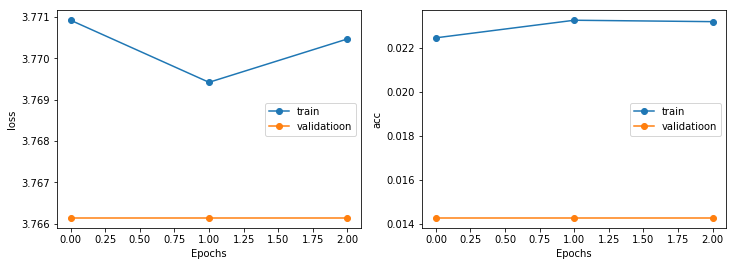

In [17]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics), '-o')
    plt.plot(history.history.get(val_metrics), '-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validatioon'])
    
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_train_history(history, 'loss', 'val_loss')

plt.subplot(1, 2, 2)
plot_train_history(history, 'acc', 'val_acc')

plt.show()

### Evaluation

In [18]:
import pandas as pd

csv_path = '/media/yinyunjie/WD_HDD/dataSets/GT-traffic-signs/data/GT-final_test.csv'

test = pd.read_csv(csv_path, sep=';')

X_test = []
y_test = []

TEST_ROOT_DIR = '/media/yinyunjie/WD_HDD/dataSets/GT-traffic-signs/data/Final_Test/Images/'

i = 0
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join(TEST_ROOT_DIR, file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)

print('Test accuracy = {}'.format(acc))

X_test.shape:  (12630, 48, 48, 3)
y_test.shape:  (12630,)


Test accuracy = 0.015518606492478226


### Training with data augumentation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2)

datagen.fit(X_train)

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
nb_epoch = 30

history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    callbacks=[LearningRateScheduler(lr_schedule),
               ModelCheckpoint('model2.h5', save_best_only=True)]
)

In [ ]:
# Display resluts

import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics), '-o')
    plt.plot(history.history.get(val_metrics), '-o')
    plt.xlabel('Epochs')
    plt.ylabel(train_metrics)
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_train_history(history, 'loss', 'val_loss')

plt.subplot(1, 2, 2)
plot_train_history(history, 'acc', 'val_acc')

plt.show()

In [ ]:
# Evaluation
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)

print('Test accuracy = {}'.format(acc))